In [1]:
!pip install torch
import numpy as np
import matplotlib.pyplot as plt
import PIL

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from torch.autograd import Variable

use_cuda = torch.cuda.is_available()
np.load.__defaults__=(None, True, True, 'ASCII')

import os
os.environ['KMP_DUPLICATE_LIB_OK']="True"

In [2]:
class HParams():
    def __init__(self):
        self.data_location = '../Datasets/sketchrnn_chair.npz'
        self.enc_hidden_size = 256
        self.dec_hidden_size = 512
        self.Nz = 128
        self.M = 20
        self.dropout = 0.9
        self.batch_size = 100
        self.eta_min = 0.01
        self.R = 0.99995
        self.KL_min = 0.2
        self.wKL = 0.5
        self.lr = 0.001
        self.lr_decay = 0.9999
        self.min_lr = 0.00001
        self.grad_clip = 1.
        self.temperature = 0.001
        self.max_seq_length = 200

hp = HParams()

In [3]:
def max_size(data):
    """larger sequence length in the data set"""
    sizes = [len(seq) for seq in data]
    return max(sizes)

def purify(strokes):
    """removes to small or too long sequences + removes large gaps"""
    data = []
    for seq in strokes:
        if seq.shape[0] <= hp.max_seq_length and seq.shape[0] > 10:
            seq = np.minimum(seq, 1000)
            seq = np.maximum(seq, -1000)
            seq = np.array(seq, dtype=np.float32)
            data.append(seq)
    return data

def calculate_normalizing_scale_factor(strokes):
    """Calculate the normalizing factor explained in appendix of sketch-rnn."""
    data = []
    for i in range(len(strokes)):
        for j in range(len(strokes[i])):
            data.append(strokes[i][j, 0])
            data.append(strokes[i][j, 1])
    data = np.array(data)
    return np.std(data)

def normalize(strokes):
    """Normalize entire dataset (delta_x, delta_y) by the scaling factor."""
    data = []
    scale_factor = calculate_normalizing_scale_factor(strokes)
    for seq in strokes:
        seq[:, 0:2] /= scale_factor
        data.append(seq)
    return data

dataset = np.load(hp.data_location, encoding='latin1')
data = dataset['train']
data = purify(data)
data = normalize(data)
Nmax = max_size(data)

In [4]:
def make_batch(batch_size):
    batch_idx = np.random.choice(len(data),batch_size)
    batch_sequences = [data[idx] for idx in batch_idx]
    strokes = []
    lengths = []
    indice = 0
    for seq in batch_sequences:
        len_seq = len(seq[:,0])
        new_seq = np.zeros((Nmax,5)) # 66,5
        new_seq[:len_seq,:2] = seq[:,:2]
        new_seq[:len_seq-1,2] = 1-seq[:-1,2]
        new_seq[:len_seq,3] = seq[:,2]
        new_seq[(len_seq-1):,4] = 1
        new_seq[len_seq-1,2:4] = 0
        lengths.append(len(seq[:,0]))
        strokes.append(new_seq)
        indice += 1

    if use_cuda:
        batch = Variable(torch.from_numpy(np.stack(strokes,1)).cuda().float())
    else:
        batch = Variable(torch.from_numpy(np.stack(strokes,1)).float())
    return batch, lengths

In [5]:
def lr_decay(optimizer):
    """Decay learning rate by a factor of lr_decay"""
    for param_group in optimizer.param_groups:
        if param_group['lr']>hp.min_lr:
            param_group['lr'] *= hp.lr_decay
    return optimizer

In [6]:
class EncoderRNN(nn.Module):
    def __init__(self):
        super(EncoderRNN, self).__init__()
        # bidirectional lstm:
        self.lstm = nn.LSTM(5, hp.enc_hidden_size, \
            dropout=hp.dropout, bidirectional=True)
        # create mu and sigma from lstm's last output:
        self.fc_mu = nn.Linear(2*hp.enc_hidden_size, hp.Nz)
        self.fc_sigma = nn.Linear(2*hp.enc_hidden_size, hp.Nz)
        # active dropout:
        self.train()

    def forward(self, inputs, batch_size, hidden_cell=None):
        if hidden_cell is None:
            # then must init with zeros
            if use_cuda:
                hidden = torch.zeros(2, batch_size, hp.enc_hidden_size).cuda()
                cell = torch.zeros(2, batch_size, hp.enc_hidden_size).cuda()
            else:
                hidden = torch.zeros(2, batch_size, hp.enc_hidden_size)
                cell = torch.zeros(2, batch_size, hp.enc_hidden_size)
            hidden_cell = (hidden, cell)
        _, (hidden,cell) = self.lstm(inputs.float(), hidden_cell)
        # hidden is (2, batch_size, hidden_size), we want (batch_size, 2*hidden_size):
        hidden_forward, hidden_backward = torch.split(hidden,1,0)
        hidden_cat = torch.cat([hidden_forward.squeeze(0), hidden_backward.squeeze(0)],1)
        # mu and sigma:
        mu = self.fc_mu(hidden_cat)
        sigma_hat = self.fc_sigma(hidden_cat)
        sigma = torch.exp(sigma_hat/2.)
        # N ~ N(0,1)
        z_size = mu.size()
                                   
        if use_cuda:
            N = torch.normal(torch.zeros(z_size),torch.ones(z_size)).cuda()
        else:
            N = torch.normal(torch.zeros(z_size),torch.ones(z_size))
        z = mu + sigma*N
        # mu and sigma_hat are needed for LKL loss
        return z, mu, sigma_hat

In [7]:
class DecoderRNN(nn.Module):
    def __init__(self):
        super(DecoderRNN, self).__init__()
        # to init hidden and cell from z:
        self.fc_hc = nn.Linear(hp.Nz, 2*hp.dec_hidden_size)
        # unidirectional lstm:
        self.lstm = nn.LSTM(hp.Nz+5, hp.dec_hidden_size, dropout=hp.dropout)
        # create proba distribution parameters from hiddens:
        self.fc_params = nn.Linear(hp.dec_hidden_size,6*hp.M+3)

    def forward(self, inputs, z, hidden_cell=None):
        if hidden_cell is None:
            # then we must init from z
            hidden,cell = torch.split(F.tanh(self.fc_hc(z)),hp.dec_hidden_size,1)
            hidden_cell = (hidden.unsqueeze(0).contiguous(), cell.unsqueeze(0).contiguous())
        outputs,(hidden,cell) = self.lstm(inputs, hidden_cell)
        # in training we feed the lstm with the whole input in one shot
        # and use all outputs contained in 'outputs', while in generate
        # mode we just feed with the last generated sample:
        if self.training:
            y = self.fc_params(outputs.view(-1, hp.dec_hidden_size))
        else:
            y = self.fc_params(hidden.view(-1, hp.dec_hidden_size))
        # separate pen and mixture params:
        params = torch.split(y,6,1)
        params_mixture = torch.stack(params[:-1]) # trajectory
        params_pen = params[-1] # pen up/down
        # identify mixture params:
        pi,mu_x,mu_y,sigma_x,sigma_y,rho_xy = torch.split(params_mixture,1,2)
        # preprocess params::
        if self.training:
            len_out = Nmax+1
        else:
            len_out = 1
                                   
        pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
        sigma_x = torch.exp(sigma_x.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
        sigma_y = torch.exp(sigma_y.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
        rho_xy = torch.tanh(rho_xy.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
        mu_x = mu_x.transpose(0,1).squeeze().contiguous().view(len_out,-1,hp.M)
        mu_y = mu_y.transpose(0,1).squeeze().contiguous().view(len_out,-1,hp.M)
        q = F.softmax(params_pen).view(len_out,-1,3)
        return pi,mu_x,mu_y,sigma_x,sigma_y,rho_xy,q,hidden,cell

In [8]:
class Model():
    def __init__(self):
        if use_cuda:
            self.encoder = EncoderRNN().cuda()
            self.decoder = DecoderRNN().cuda()
        else:
            self.encoder = EncoderRNN()
            self.decoder = DecoderRNN()
        self.encoder_optimizer = optim.Adam(self.encoder.parameters(), hp.lr)
        self.decoder_optimizer = optim.Adam(self.decoder.parameters(), hp.lr)
        self.eta_step = hp.eta_min
        self.lost_array = []

    def make_target(self, batch, lengths):
        if use_cuda:
            eos = torch.stack([torch.Tensor([0,0,0,0,1])]*batch.size()[1]).cuda().unsqueeze(0)
        else:
            eos = torch.stack([torch.Tensor([0,0,0,0,1])]*batch.size()[1]).unsqueeze(0)
        batch = torch.cat([batch, eos], 0)
        mask = torch.zeros(Nmax+1, batch.size()[1])
        for indice,length in enumerate(lengths):
            mask[:length,indice] = 1
        if use_cuda:
            mask = mask.cuda()
        dx = torch.stack([batch.data[:,:,0]]*hp.M,2)
        dy = torch.stack([batch.data[:,:,1]]*hp.M,2)
        p1 = batch.data[:,:,2]
        p2 = batch.data[:,:,3]
        p3 = batch.data[:,:,4]
        p = torch.stack([p1,p2,p3],2)
        return mask,dx,dy,p

    def train(self, epoch):
        self.encoder.train()
        self.decoder.train()
        batch, lengths = make_batch(hp.batch_size)
        # encode:
        z, self.mu, self.sigma = self.encoder(batch, hp.batch_size)
        # create start of sequence:
        if use_cuda:
            sos = torch.stack([torch.Tensor([0,0,1,0,0])]*hp.batch_size).cuda().unsqueeze(0)
        else:
            sos = torch.stack([torch.Tensor([0,0,1,0,0])]*hp.batch_size).unsqueeze(0)
        # had sos at the begining of the batch:
        batch_init = torch.cat([sos, batch],0)
        # expend z to be ready to concatenate with inputs:
        z_stack = torch.stack([z]*(Nmax+1))
        # inputs is concatenation of z and batch_inputs
        inputs = torch.cat([batch_init, z_stack],2)
        # decode:
        self.pi, self.mu_x, self.mu_y, self.sigma_x, self.sigma_y, \
            self.rho_xy, self.q, _, _ = self.decoder(inputs, z)
        # prepare targets:
        mask,dx,dy,p = self.make_target(batch, lengths)
        # prepare optimizers:
        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()
        # update eta for LKL:
        self.eta_step = 1-(1-hp.eta_min)*hp.R
        # compute losses:
        LKL = self.kullback_leibler_loss()
        LR = self.reconstruction_loss(mask,dx,dy,p,epoch)
        loss = LR + LKL
        # gradient step
        loss.backward()
        # gradient cliping
        nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
        nn.utils.clip_grad_norm(self.decoder.parameters(), hp.grad_clip)
        # optim step
        self.encoder_optimizer.step()
        self.decoder_optimizer.step()
        # some print and save:
        print(f"The number of epochs is: {epoch}")
        if epoch%1==0:
#             print('epoch',epoch,'loss',loss.data[0],'LR',LR.data[0],'LKL',LKL.data[0])
            print(f"epoch: {epoch} loss is {loss}")
            self.encoder_optimizer = lr_decay(self.encoder_optimizer)
            self.decoder_optimizer = lr_decay(self.decoder_optimizer)
        if epoch%100==0:
            #self.save(epoch)
            self.lost_array.append(loss.item())
            self.conditional_generation(epoch)

    def bivariate_normal_pdf(self, dx, dy):
        z_x = ((dx-self.mu_x)/self.sigma_x)**2
        z_y = ((dy-self.mu_y)/self.sigma_y)**2
        z_xy = (dx-self.mu_x)*(dy-self.mu_y)/(self.sigma_x*self.sigma_y)
        z = z_x + z_y -2*self.rho_xy*z_xy
        exp = torch.exp(-z/(2*(1-self.rho_xy**2)))
        norm = 2*np.pi*self.sigma_x*self.sigma_y*torch.sqrt(1-self.rho_xy**2)
        return exp/norm

    def reconstruction_loss(self, mask, dx, dy, p, epoch):
        pdf = self.bivariate_normal_pdf(dx, dy)
        LS = -torch.sum(mask*torch.log(1e-5+torch.sum(self.pi * pdf, 2)))\
            /float(Nmax*hp.batch_size)
        LP = -torch.sum(p*torch.log(self.q))/float(Nmax*hp.batch_size)
        return LS+LP

    def kullback_leibler_loss(self):
        LKL = -0.5*torch.sum(1+self.sigma-self.mu**2-torch.exp(self.sigma))\
            /float(hp.Nz*hp.batch_size)
        if use_cuda:
            KL_min = Variable(torch.Tensor([hp.KL_min]).cuda()).detach()
        else:
            KL_min = Variable(torch.Tensor([hp.KL_min])).detach()
        return hp.wKL*self.eta_step * torch.max(LKL,KL_min)

    def save(self, epoch):
        random_number = np.random.rand()
        enc_model_name = 'sketchRNN_encoder_%3f_%d.pt' % (random_number, epoch)
        enc_path = F"../Models_Chairs/{enc_model_name}"
        torch.save(self.encoder.state_dict(), enc_path)
        dec_model_name = 'sketchRNN_decoder_%3f_%d.pt' % (random_number, epoch)
        dec_path = F"../Models_Chairs/{dec_model_name}"
        torch.save(self.decoder.state_dict(), dec_path)
        
#         torch.save(self.encoder.state_dict(), 'encoderRNN_sel_%3f_epoch_%d.pth' % (sel,epoch))
#         torch.save(self.decoder.state_dict(), 'decoderRNN_sel_%3f_epoch_%d.pth' % (sel,epoch))

    def load(self, encoder_name, decoder_name):
        saved_encoder = torch.load(encoder_name)
        saved_decoder = torch.load(decoder_name)
        self.encoder.load_state_dict(saved_encoder)
        self.decoder.load_state_dict(saved_decoder)

    def conditional_generation(self, epoch):
        batch,lengths = make_batch(1)
        # should remove dropouts:
        self.encoder.train(False)
        self.decoder.train(False)
        # encode:
        z, _, _ = self.encoder(batch, 1)
        if use_cuda:
            sos = Variable(torch.Tensor([0,0,1,0,0]).view(1,1,-1).cuda())
        else:
            sos = Variable(torch.Tensor([0,0,1,0,0]).view(1,1,-1))
        s = sos
        seq_x = []
        seq_y = []
        seq_z = []
        hidden_cell = None
        for i in range(Nmax):
            input = torch.cat([s,z.unsqueeze(0)],2)
            # decode:
            self.pi, self.mu_x, self.mu_y, self.sigma_x, self.sigma_y, \
                self.rho_xy, self.q, hidden, cell = \
                    self.decoder(input, z, hidden_cell)
            hidden_cell = (hidden, cell)
            # sample from parameters:
            s, dx, dy, pen_down, eos = self.sample_next_state()
            #------
            seq_x.append(dx)
            seq_y.append(dy)
            seq_z.append(pen_down)
            if eos:
                print(i)
                break
        # visualize result:
        x_sample = np.cumsum(seq_x, 0)
        y_sample = np.cumsum(seq_y, 0)
        z_sample = np.array(seq_z)
        sequence = np.stack([x_sample,y_sample,z_sample]).T
        make_image(sequence, epoch)

    def sample_next_state(self):
        def adjust_temp(pi_pdf):
            pi_pdf = np.log(pi_pdf)/hp.temperature
            pi_pdf -= pi_pdf.max()
            pi_pdf = np.exp(pi_pdf)
            pi_pdf /= pi_pdf.sum()
            return pi_pdf

        # get mixture indice:
        pi = self.pi.data[0,0,:].cpu().numpy()
        pi = adjust_temp(pi)
        pi_idx = np.random.choice(hp.M, p=pi)
        # get pen state:
        q = self.q.data[0,0,:].cpu().numpy()
        q = adjust_temp(q)
        q_idx = np.random.choice(3, p=q)
        # get mixture params:
        mu_x = self.mu_x.data[0,0,pi_idx]
        mu_y = self.mu_y.data[0,0,pi_idx]
        sigma_x = self.sigma_x.data[0,0,pi_idx]
        sigma_y = self.sigma_y.data[0,0,pi_idx]
        rho_xy = self.rho_xy.data[0,0,pi_idx]
        x,y = sample_bivariate_normal(mu_x,mu_y,sigma_x,sigma_y,rho_xy,greedy=False)
        next_state = torch.zeros(5)
        next_state[0] = x
        next_state[1] = y
        next_state[q_idx+2] = 1
        if use_cuda:
            return Variable(next_state.cuda()).view(1,1,-1),x,y,q_idx==1,q_idx==2
        else:
            return Variable(next_state).view(1,1,-1),x,y,q_idx==1,q_idx==2

def sample_bivariate_normal(mu_x,mu_y,sigma_x,sigma_y,rho_xy, greedy=False):
    # inputs must be floats
    if greedy:
        return mu_x,mu_y
    mean = [mu_x, mu_y]
    sigma_x *= np.sqrt(hp.temperature)
    sigma_y *= np.sqrt(hp.temperature)
    cov = [[sigma_x * sigma_x, rho_xy * sigma_x * sigma_y],\
        [rho_xy * sigma_x * sigma_y, sigma_y * sigma_y]]
    x = np.random.multivariate_normal(mean, cov, 1)
    return x[0][0], x[0][1]

def make_image(sequence, epoch, name='_output_'):
    """plot drawing with separated strokes"""
    strokes = np.split(sequence, np.where(sequence[:,2]>0)[0]+1)
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    for s in strokes:
        plt.plot(s[:,0],-s[:,1])
    print("Outputting sketch")
    plt.show()
    name = str(epoch)+name+'.jpg'
    plt.savefig(F"./outputs_chair/{name}")
    
#     canvas = plt.get_current_fig_manager().canvas
#     canvas.draw()
#     pil_image = PIL.Image.frombytes('RGB', canvas.get_width_height(),
#                  canvas.tostring_rgb())
#     name = str(epoch)+name+'.jpg'
#     pil_image.save(F"./outputs_chair/{name}","JPEG")
#     plt.close("all")


In [9]:
# model = Model()
# for epoch in range(50001):
#     model.train(epoch)

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.9 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/

epoch: 0 loss is tensor([2.3688], grad_fn=<AddBackward0>)
0


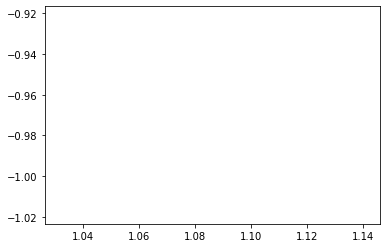

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in fa

epoch: 1 loss is tensor([2.2534], grad_fn=<AddBackward0>)
epoch: 2 loss is tensor([2.2996], grad_fn=<AddBackward0>)
epoch: 3 loss is tensor([2.1165], grad_fn=<AddBackward0>)
epoch: 4 loss is tensor([2.0429], grad_fn=<AddBackward0>)
epoch: 5 loss is tensor([1.9262], grad_fn=<AddBackward0>)
epoch: 6 loss is tensor([1.9035], grad_fn=<AddBackward0>)
epoch: 7 loss is tensor([2.0001], grad_fn=<AddBackward0>)
epoch: 8 loss is tensor([1.7129], grad_fn=<AddBackward0>)
epoch: 9 loss is tensor([1.8701], grad_fn=<AddBackward0>)
epoch: 10 loss is tensor([1.8235], grad_fn=<AddBackward0>)
epoch: 11 loss is tensor([1.6834], grad_fn=<AddBackward0>)
epoch: 12 loss is tensor([1.7313], grad_fn=<AddBackward0>)
epoch: 13 loss is tensor([1.5631], grad_fn=<AddBackward0>)
epoch: 14 loss is tensor([1.7253], grad_fn=<AddBackward0>)
epoch: 15 loss is tensor([1.6629], grad_fn=<AddBackward0>)
epoch: 16 loss is tensor([1.5541], grad_fn=<AddBackward0>)
epoch: 17 loss is tensor([1.5736], grad_fn=<AddBackward0>)
epoch:

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 101 loss is tensor([0.9436], grad_fn=<AddBackward0>)
epoch: 102 loss is tensor([0.8964], grad_fn=<AddBackward0>)
epoch: 103 loss is tensor([1.0730], grad_fn=<AddBackward0>)
epoch: 104 loss is tensor([0.9640], grad_fn=<AddBackward0>)
epoch: 105 loss is tensor([0.9399], grad_fn=<AddBackward0>)
epoch: 106 loss is tensor([0.9746], grad_fn=<AddBackward0>)
epoch: 107 loss is tensor([1.0172], grad_fn=<AddBackward0>)
epoch: 108 loss is tensor([0.9633], grad_fn=<AddBackward0>)
epoch: 109 loss is tensor([0.9731], grad_fn=<AddBackward0>)
epoch: 110 loss is tensor([0.8795], grad_fn=<AddBackward0>)
epoch: 111 loss is tensor([1.0078], grad_fn=<AddBackward0>)
epoch: 112 loss is tensor([0.9841], grad_fn=<AddBackward0>)
epoch: 113 loss is tensor([0.9619], grad_fn=<AddBackward0>)
epoch: 114 loss is tensor([1.0270], grad_fn=<AddBackward0>)
epoch: 115 loss is tensor([1.0086], grad_fn=<AddBackward0>)
epoch: 116 loss is tensor([1.0884], grad_fn=<AddBackward0>)
epoch: 117 loss is tensor([0.9844], grad

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 201 loss is tensor([0.7760], grad_fn=<AddBackward0>)
epoch: 202 loss is tensor([0.7604], grad_fn=<AddBackward0>)
epoch: 203 loss is tensor([0.7551], grad_fn=<AddBackward0>)
epoch: 204 loss is tensor([0.6732], grad_fn=<AddBackward0>)
epoch: 205 loss is tensor([0.7009], grad_fn=<AddBackward0>)
epoch: 206 loss is tensor([0.7487], grad_fn=<AddBackward0>)
epoch: 207 loss is tensor([0.7454], grad_fn=<AddBackward0>)
epoch: 208 loss is tensor([0.7760], grad_fn=<AddBackward0>)
epoch: 209 loss is tensor([0.6924], grad_fn=<AddBackward0>)
epoch: 210 loss is tensor([0.7876], grad_fn=<AddBackward0>)
epoch: 211 loss is tensor([0.7290], grad_fn=<AddBackward0>)
epoch: 212 loss is tensor([0.6795], grad_fn=<AddBackward0>)
epoch: 213 loss is tensor([0.7193], grad_fn=<AddBackward0>)
epoch: 214 loss is tensor([0.7648], grad_fn=<AddBackward0>)
epoch: 215 loss is tensor([0.7341], grad_fn=<AddBackward0>)
epoch: 216 loss is tensor([0.6543], grad_fn=<AddBackward0>)
epoch: 217 loss is tensor([0.6784], grad

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 301 loss is tensor([0.6520], grad_fn=<AddBackward0>)
epoch: 302 loss is tensor([0.6321], grad_fn=<AddBackward0>)
epoch: 303 loss is tensor([0.6473], grad_fn=<AddBackward0>)
epoch: 304 loss is tensor([0.6274], grad_fn=<AddBackward0>)
epoch: 305 loss is tensor([0.6345], grad_fn=<AddBackward0>)
epoch: 306 loss is tensor([0.5647], grad_fn=<AddBackward0>)
epoch: 307 loss is tensor([0.6821], grad_fn=<AddBackward0>)
epoch: 308 loss is tensor([0.5284], grad_fn=<AddBackward0>)
epoch: 309 loss is tensor([0.6945], grad_fn=<AddBackward0>)
epoch: 310 loss is tensor([0.6266], grad_fn=<AddBackward0>)
epoch: 311 loss is tensor([0.6372], grad_fn=<AddBackward0>)
epoch: 312 loss is tensor([0.6479], grad_fn=<AddBackward0>)
epoch: 313 loss is tensor([0.6397], grad_fn=<AddBackward0>)
epoch: 314 loss is tensor([0.5683], grad_fn=<AddBackward0>)
epoch: 315 loss is tensor([0.6382], grad_fn=<AddBackward0>)
epoch: 316 loss is tensor([0.6158], grad_fn=<AddBackward0>)
epoch: 317 loss is tensor([0.5978], grad

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 401 loss is tensor([0.5507], grad_fn=<AddBackward0>)
epoch: 402 loss is tensor([0.6228], grad_fn=<AddBackward0>)
epoch: 403 loss is tensor([0.5532], grad_fn=<AddBackward0>)
epoch: 404 loss is tensor([0.5587], grad_fn=<AddBackward0>)
epoch: 405 loss is tensor([0.5616], grad_fn=<AddBackward0>)
epoch: 406 loss is tensor([0.5808], grad_fn=<AddBackward0>)
epoch: 407 loss is tensor([0.5840], grad_fn=<AddBackward0>)
epoch: 408 loss is tensor([0.5900], grad_fn=<AddBackward0>)
epoch: 409 loss is tensor([0.4918], grad_fn=<AddBackward0>)
epoch: 410 loss is tensor([0.5763], grad_fn=<AddBackward0>)
epoch: 411 loss is tensor([0.4934], grad_fn=<AddBackward0>)
epoch: 412 loss is tensor([0.5235], grad_fn=<AddBackward0>)
epoch: 413 loss is tensor([0.5506], grad_fn=<AddBackward0>)
epoch: 414 loss is tensor([0.6247], grad_fn=<AddBackward0>)
epoch: 415 loss is tensor([0.5282], grad_fn=<AddBackward0>)
epoch: 416 loss is tensor([0.5452], grad_fn=<AddBackward0>)
epoch: 417 loss is tensor([0.5840], grad

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 501 loss is tensor([0.4962], grad_fn=<AddBackward0>)
epoch: 502 loss is tensor([0.4174], grad_fn=<AddBackward0>)
epoch: 503 loss is tensor([0.4273], grad_fn=<AddBackward0>)
epoch: 504 loss is tensor([0.4475], grad_fn=<AddBackward0>)
epoch: 505 loss is tensor([0.5138], grad_fn=<AddBackward0>)
epoch: 506 loss is tensor([0.4657], grad_fn=<AddBackward0>)
epoch: 507 loss is tensor([0.5155], grad_fn=<AddBackward0>)
epoch: 508 loss is tensor([0.4364], grad_fn=<AddBackward0>)
epoch: 509 loss is tensor([0.4752], grad_fn=<AddBackward0>)
epoch: 510 loss is tensor([0.4917], grad_fn=<AddBackward0>)
epoch: 511 loss is tensor([0.4879], grad_fn=<AddBackward0>)
epoch: 512 loss is tensor([0.5168], grad_fn=<AddBackward0>)
epoch: 513 loss is tensor([0.4819], grad_fn=<AddBackward0>)
epoch: 514 loss is tensor([0.4685], grad_fn=<AddBackward0>)
epoch: 515 loss is tensor([0.4646], grad_fn=<AddBackward0>)
epoch: 516 loss is tensor([0.5199], grad_fn=<AddBackward0>)
epoch: 517 loss is tensor([0.4870], grad

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 601 loss is tensor([0.4500], grad_fn=<AddBackward0>)
epoch: 602 loss is tensor([0.4375], grad_fn=<AddBackward0>)
epoch: 603 loss is tensor([0.4322], grad_fn=<AddBackward0>)
epoch: 604 loss is tensor([0.4746], grad_fn=<AddBackward0>)
epoch: 605 loss is tensor([0.4154], grad_fn=<AddBackward0>)
epoch: 606 loss is tensor([0.3948], grad_fn=<AddBackward0>)
epoch: 607 loss is tensor([0.3884], grad_fn=<AddBackward0>)
epoch: 608 loss is tensor([0.4213], grad_fn=<AddBackward0>)
epoch: 609 loss is tensor([0.4346], grad_fn=<AddBackward0>)
epoch: 610 loss is tensor([0.4103], grad_fn=<AddBackward0>)
epoch: 611 loss is tensor([0.4107], grad_fn=<AddBackward0>)
epoch: 612 loss is tensor([0.5083], grad_fn=<AddBackward0>)
epoch: 613 loss is tensor([0.4757], grad_fn=<AddBackward0>)
epoch: 614 loss is tensor([0.4774], grad_fn=<AddBackward0>)
epoch: 615 loss is tensor([0.5071], grad_fn=<AddBackward0>)
epoch: 616 loss is tensor([0.4906], grad_fn=<AddBackward0>)
epoch: 617 loss is tensor([0.4917], grad

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 701 loss is tensor([0.4495], grad_fn=<AddBackward0>)
epoch: 702 loss is tensor([0.3952], grad_fn=<AddBackward0>)
epoch: 703 loss is tensor([0.2912], grad_fn=<AddBackward0>)
epoch: 704 loss is tensor([0.3727], grad_fn=<AddBackward0>)
epoch: 705 loss is tensor([0.4628], grad_fn=<AddBackward0>)
epoch: 706 loss is tensor([0.3762], grad_fn=<AddBackward0>)
epoch: 707 loss is tensor([0.3988], grad_fn=<AddBackward0>)
epoch: 708 loss is tensor([0.3964], grad_fn=<AddBackward0>)
epoch: 709 loss is tensor([0.4202], grad_fn=<AddBackward0>)
epoch: 710 loss is tensor([0.4594], grad_fn=<AddBackward0>)
epoch: 711 loss is tensor([0.4381], grad_fn=<AddBackward0>)
epoch: 712 loss is tensor([0.3954], grad_fn=<AddBackward0>)
epoch: 713 loss is tensor([0.3951], grad_fn=<AddBackward0>)
epoch: 714 loss is tensor([0.4578], grad_fn=<AddBackward0>)
epoch: 715 loss is tensor([0.3858], grad_fn=<AddBackward0>)
epoch: 716 loss is tensor([0.3781], grad_fn=<AddBackward0>)
epoch: 717 loss is tensor([0.3896], grad

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 801 loss is tensor([0.3534], grad_fn=<AddBackward0>)
epoch: 802 loss is tensor([0.3627], grad_fn=<AddBackward0>)
epoch: 803 loss is tensor([0.3690], grad_fn=<AddBackward0>)
epoch: 804 loss is tensor([0.3124], grad_fn=<AddBackward0>)
epoch: 805 loss is tensor([0.2984], grad_fn=<AddBackward0>)
epoch: 806 loss is tensor([0.4299], grad_fn=<AddBackward0>)
epoch: 807 loss is tensor([0.2939], grad_fn=<AddBackward0>)
epoch: 808 loss is tensor([0.3379], grad_fn=<AddBackward0>)
epoch: 809 loss is tensor([0.3504], grad_fn=<AddBackward0>)
epoch: 810 loss is tensor([0.3107], grad_fn=<AddBackward0>)
epoch: 811 loss is tensor([0.3891], grad_fn=<AddBackward0>)
epoch: 812 loss is tensor([0.4039], grad_fn=<AddBackward0>)
epoch: 813 loss is tensor([0.3051], grad_fn=<AddBackward0>)
epoch: 814 loss is tensor([0.3431], grad_fn=<AddBackward0>)
epoch: 815 loss is tensor([0.3836], grad_fn=<AddBackward0>)
epoch: 816 loss is tensor([0.4020], grad_fn=<AddBackward0>)
epoch: 817 loss is tensor([0.3605], grad

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 901 loss is tensor([0.3597], grad_fn=<AddBackward0>)
epoch: 902 loss is tensor([0.3295], grad_fn=<AddBackward0>)
epoch: 903 loss is tensor([0.3408], grad_fn=<AddBackward0>)
epoch: 904 loss is tensor([0.3739], grad_fn=<AddBackward0>)
epoch: 905 loss is tensor([0.2613], grad_fn=<AddBackward0>)
epoch: 906 loss is tensor([0.3051], grad_fn=<AddBackward0>)
epoch: 907 loss is tensor([0.3791], grad_fn=<AddBackward0>)
epoch: 908 loss is tensor([0.3797], grad_fn=<AddBackward0>)
epoch: 909 loss is tensor([0.2779], grad_fn=<AddBackward0>)
epoch: 910 loss is tensor([0.3450], grad_fn=<AddBackward0>)
epoch: 911 loss is tensor([0.3677], grad_fn=<AddBackward0>)
epoch: 912 loss is tensor([0.3215], grad_fn=<AddBackward0>)
epoch: 913 loss is tensor([0.3432], grad_fn=<AddBackward0>)
epoch: 914 loss is tensor([0.3164], grad_fn=<AddBackward0>)
epoch: 915 loss is tensor([0.3173], grad_fn=<AddBackward0>)
epoch: 916 loss is tensor([0.3470], grad_fn=<AddBackward0>)
epoch: 917 loss is tensor([0.3458], grad

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 1001 loss is tensor([0.2732], grad_fn=<AddBackward0>)
epoch: 1002 loss is tensor([0.3379], grad_fn=<AddBackward0>)
epoch: 1003 loss is tensor([0.3077], grad_fn=<AddBackward0>)
epoch: 1004 loss is tensor([0.3113], grad_fn=<AddBackward0>)
epoch: 1005 loss is tensor([0.3149], grad_fn=<AddBackward0>)
epoch: 1006 loss is tensor([0.3107], grad_fn=<AddBackward0>)
epoch: 1007 loss is tensor([0.3219], grad_fn=<AddBackward0>)
epoch: 1008 loss is tensor([0.3612], grad_fn=<AddBackward0>)
epoch: 1009 loss is tensor([0.3084], grad_fn=<AddBackward0>)
epoch: 1010 loss is tensor([0.3690], grad_fn=<AddBackward0>)
epoch: 1011 loss is tensor([0.2166], grad_fn=<AddBackward0>)
epoch: 1012 loss is tensor([0.2776], grad_fn=<AddBackward0>)
epoch: 1013 loss is tensor([0.2720], grad_fn=<AddBackward0>)
epoch: 1014 loss is tensor([0.2219], grad_fn=<AddBackward0>)
epoch: 1015 loss is tensor([0.3026], grad_fn=<AddBackward0>)
epoch: 1016 loss is tensor([0.2768], grad_fn=<AddBackward0>)
epoch: 1017 loss is tens

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 1101 loss is tensor([0.2070], grad_fn=<AddBackward0>)
epoch: 1102 loss is tensor([0.2609], grad_fn=<AddBackward0>)
epoch: 1103 loss is tensor([0.2462], grad_fn=<AddBackward0>)
epoch: 1104 loss is tensor([0.2372], grad_fn=<AddBackward0>)
epoch: 1105 loss is tensor([0.2648], grad_fn=<AddBackward0>)
epoch: 1106 loss is tensor([0.2455], grad_fn=<AddBackward0>)
epoch: 1107 loss is tensor([0.2344], grad_fn=<AddBackward0>)
epoch: 1108 loss is tensor([0.2991], grad_fn=<AddBackward0>)
epoch: 1109 loss is tensor([0.2168], grad_fn=<AddBackward0>)
epoch: 1110 loss is tensor([0.3485], grad_fn=<AddBackward0>)
epoch: 1111 loss is tensor([0.2537], grad_fn=<AddBackward0>)
epoch: 1112 loss is tensor([0.2918], grad_fn=<AddBackward0>)
epoch: 1113 loss is tensor([0.2926], grad_fn=<AddBackward0>)
epoch: 1114 loss is tensor([0.2515], grad_fn=<AddBackward0>)
epoch: 1115 loss is tensor([0.2460], grad_fn=<AddBackward0>)
epoch: 1116 loss is tensor([0.2270], grad_fn=<AddBackward0>)
epoch: 1117 loss is tens

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 1201 loss is tensor([0.1828], grad_fn=<AddBackward0>)
epoch: 1202 loss is tensor([0.2359], grad_fn=<AddBackward0>)
epoch: 1203 loss is tensor([0.2273], grad_fn=<AddBackward0>)
epoch: 1204 loss is tensor([0.2521], grad_fn=<AddBackward0>)
epoch: 1205 loss is tensor([0.2555], grad_fn=<AddBackward0>)
epoch: 1206 loss is tensor([0.2056], grad_fn=<AddBackward0>)
epoch: 1207 loss is tensor([0.2146], grad_fn=<AddBackward0>)
epoch: 1208 loss is tensor([0.2072], grad_fn=<AddBackward0>)
epoch: 1209 loss is tensor([0.2542], grad_fn=<AddBackward0>)
epoch: 1210 loss is tensor([0.2297], grad_fn=<AddBackward0>)
epoch: 1211 loss is tensor([0.2717], grad_fn=<AddBackward0>)
epoch: 1212 loss is tensor([0.1874], grad_fn=<AddBackward0>)
epoch: 1213 loss is tensor([0.2280], grad_fn=<AddBackward0>)
epoch: 1214 loss is tensor([0.2228], grad_fn=<AddBackward0>)
epoch: 1215 loss is tensor([0.2702], grad_fn=<AddBackward0>)
epoch: 1216 loss is tensor([0.1586], grad_fn=<AddBackward0>)
epoch: 1217 loss is tens

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 1301 loss is tensor([0.2056], grad_fn=<AddBackward0>)
epoch: 1302 loss is tensor([0.2015], grad_fn=<AddBackward0>)
epoch: 1303 loss is tensor([0.1596], grad_fn=<AddBackward0>)
epoch: 1304 loss is tensor([0.2352], grad_fn=<AddBackward0>)
epoch: 1305 loss is tensor([0.2870], grad_fn=<AddBackward0>)
epoch: 1306 loss is tensor([0.2493], grad_fn=<AddBackward0>)
epoch: 1307 loss is tensor([0.2953], grad_fn=<AddBackward0>)
epoch: 1308 loss is tensor([0.2426], grad_fn=<AddBackward0>)
epoch: 1309 loss is tensor([0.2000], grad_fn=<AddBackward0>)
epoch: 1310 loss is tensor([0.2100], grad_fn=<AddBackward0>)
epoch: 1311 loss is tensor([0.2237], grad_fn=<AddBackward0>)
epoch: 1312 loss is tensor([0.2485], grad_fn=<AddBackward0>)
epoch: 1313 loss is tensor([0.2392], grad_fn=<AddBackward0>)
epoch: 1314 loss is tensor([0.2317], grad_fn=<AddBackward0>)
epoch: 1315 loss is tensor([0.2077], grad_fn=<AddBackward0>)
epoch: 1316 loss is tensor([0.2027], grad_fn=<AddBackward0>)
epoch: 1317 loss is tens

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 1401 loss is tensor([0.2106], grad_fn=<AddBackward0>)
epoch: 1402 loss is tensor([0.2440], grad_fn=<AddBackward0>)
epoch: 1403 loss is tensor([0.2531], grad_fn=<AddBackward0>)
epoch: 1404 loss is tensor([0.1842], grad_fn=<AddBackward0>)
epoch: 1405 loss is tensor([0.2638], grad_fn=<AddBackward0>)
epoch: 1406 loss is tensor([0.2030], grad_fn=<AddBackward0>)
epoch: 1407 loss is tensor([0.2190], grad_fn=<AddBackward0>)
epoch: 1408 loss is tensor([0.2419], grad_fn=<AddBackward0>)
epoch: 1409 loss is tensor([0.2236], grad_fn=<AddBackward0>)
epoch: 1410 loss is tensor([0.2623], grad_fn=<AddBackward0>)
epoch: 1411 loss is tensor([0.2666], grad_fn=<AddBackward0>)
epoch: 1412 loss is tensor([0.2479], grad_fn=<AddBackward0>)
epoch: 1413 loss is tensor([0.2259], grad_fn=<AddBackward0>)
epoch: 1414 loss is tensor([0.2112], grad_fn=<AddBackward0>)
epoch: 1415 loss is tensor([0.2468], grad_fn=<AddBackward0>)
epoch: 1416 loss is tensor([0.1821], grad_fn=<AddBackward0>)
epoch: 1417 loss is tens

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 1501 loss is tensor([0.1503], grad_fn=<AddBackward0>)
epoch: 1502 loss is tensor([0.1990], grad_fn=<AddBackward0>)
epoch: 1503 loss is tensor([0.2108], grad_fn=<AddBackward0>)
epoch: 1504 loss is tensor([0.1808], grad_fn=<AddBackward0>)
epoch: 1505 loss is tensor([0.1727], grad_fn=<AddBackward0>)
epoch: 1506 loss is tensor([0.1727], grad_fn=<AddBackward0>)
epoch: 1507 loss is tensor([0.2015], grad_fn=<AddBackward0>)
epoch: 1508 loss is tensor([0.2119], grad_fn=<AddBackward0>)
epoch: 1509 loss is tensor([0.2304], grad_fn=<AddBackward0>)
epoch: 1510 loss is tensor([0.1933], grad_fn=<AddBackward0>)
epoch: 1511 loss is tensor([0.1452], grad_fn=<AddBackward0>)
epoch: 1512 loss is tensor([0.1997], grad_fn=<AddBackward0>)
epoch: 1513 loss is tensor([0.1268], grad_fn=<AddBackward0>)
epoch: 1514 loss is tensor([0.1921], grad_fn=<AddBackward0>)
epoch: 1515 loss is tensor([0.1760], grad_fn=<AddBackward0>)
epoch: 1516 loss is tensor([0.1557], grad_fn=<AddBackward0>)
epoch: 1517 loss is tens

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 1601 loss is tensor([0.1821], grad_fn=<AddBackward0>)
epoch: 1602 loss is tensor([0.2128], grad_fn=<AddBackward0>)
epoch: 1603 loss is tensor([0.1375], grad_fn=<AddBackward0>)
epoch: 1604 loss is tensor([0.1578], grad_fn=<AddBackward0>)
epoch: 1605 loss is tensor([0.1502], grad_fn=<AddBackward0>)
epoch: 1606 loss is tensor([0.1499], grad_fn=<AddBackward0>)
epoch: 1607 loss is tensor([0.2092], grad_fn=<AddBackward0>)
epoch: 1608 loss is tensor([0.1553], grad_fn=<AddBackward0>)
epoch: 1609 loss is tensor([0.1675], grad_fn=<AddBackward0>)
epoch: 1610 loss is tensor([0.2144], grad_fn=<AddBackward0>)
epoch: 1611 loss is tensor([0.1420], grad_fn=<AddBackward0>)
epoch: 1612 loss is tensor([0.1294], grad_fn=<AddBackward0>)
epoch: 1613 loss is tensor([0.1769], grad_fn=<AddBackward0>)
epoch: 1614 loss is tensor([0.1628], grad_fn=<AddBackward0>)
epoch: 1615 loss is tensor([0.1307], grad_fn=<AddBackward0>)
epoch: 1616 loss is tensor([0.1072], grad_fn=<AddBackward0>)
epoch: 1617 loss is tens

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 1701 loss is tensor([0.1266], grad_fn=<AddBackward0>)
epoch: 1702 loss is tensor([0.1389], grad_fn=<AddBackward0>)
epoch: 1703 loss is tensor([0.1233], grad_fn=<AddBackward0>)
epoch: 1704 loss is tensor([0.1802], grad_fn=<AddBackward0>)
epoch: 1705 loss is tensor([0.1457], grad_fn=<AddBackward0>)
epoch: 1706 loss is tensor([0.1923], grad_fn=<AddBackward0>)
epoch: 1707 loss is tensor([0.1958], grad_fn=<AddBackward0>)
epoch: 1708 loss is tensor([0.1207], grad_fn=<AddBackward0>)
epoch: 1709 loss is tensor([0.2276], grad_fn=<AddBackward0>)
epoch: 1710 loss is tensor([0.1441], grad_fn=<AddBackward0>)
epoch: 1711 loss is tensor([0.0759], grad_fn=<AddBackward0>)
epoch: 1712 loss is tensor([0.1380], grad_fn=<AddBackward0>)
epoch: 1713 loss is tensor([0.1226], grad_fn=<AddBackward0>)
epoch: 1714 loss is tensor([0.1581], grad_fn=<AddBackward0>)
epoch: 1715 loss is tensor([0.1037], grad_fn=<AddBackward0>)
epoch: 1716 loss is tensor([0.1575], grad_fn=<AddBackward0>)
epoch: 1717 loss is tens

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 1801 loss is tensor([0.1312], grad_fn=<AddBackward0>)
epoch: 1802 loss is tensor([0.1393], grad_fn=<AddBackward0>)
epoch: 1803 loss is tensor([0.1082], grad_fn=<AddBackward0>)
epoch: 1804 loss is tensor([0.1303], grad_fn=<AddBackward0>)
epoch: 1805 loss is tensor([0.1665], grad_fn=<AddBackward0>)
epoch: 1806 loss is tensor([0.1140], grad_fn=<AddBackward0>)
epoch: 1807 loss is tensor([0.1434], grad_fn=<AddBackward0>)
epoch: 1808 loss is tensor([0.1389], grad_fn=<AddBackward0>)
epoch: 1809 loss is tensor([0.1864], grad_fn=<AddBackward0>)
epoch: 1810 loss is tensor([0.2435], grad_fn=<AddBackward0>)
epoch: 1811 loss is tensor([0.1415], grad_fn=<AddBackward0>)
epoch: 1812 loss is tensor([0.1434], grad_fn=<AddBackward0>)
epoch: 1813 loss is tensor([0.1131], grad_fn=<AddBackward0>)
epoch: 1814 loss is tensor([0.2103], grad_fn=<AddBackward0>)
epoch: 1815 loss is tensor([0.1756], grad_fn=<AddBackward0>)
epoch: 1816 loss is tensor([0.1143], grad_fn=<AddBackward0>)
epoch: 1817 loss is tens

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 1901 loss is tensor([0.1982], grad_fn=<AddBackward0>)
epoch: 1902 loss is tensor([0.1777], grad_fn=<AddBackward0>)
epoch: 1903 loss is tensor([0.1382], grad_fn=<AddBackward0>)
epoch: 1904 loss is tensor([0.1558], grad_fn=<AddBackward0>)
epoch: 1905 loss is tensor([0.2148], grad_fn=<AddBackward0>)
epoch: 1906 loss is tensor([0.1345], grad_fn=<AddBackward0>)
epoch: 1907 loss is tensor([0.0867], grad_fn=<AddBackward0>)
epoch: 1908 loss is tensor([0.1678], grad_fn=<AddBackward0>)
epoch: 1909 loss is tensor([0.1902], grad_fn=<AddBackward0>)
epoch: 1910 loss is tensor([0.1105], grad_fn=<AddBackward0>)
epoch: 1911 loss is tensor([0.1230], grad_fn=<AddBackward0>)
epoch: 1912 loss is tensor([0.0359], grad_fn=<AddBackward0>)
epoch: 1913 loss is tensor([0.0817], grad_fn=<AddBackward0>)
epoch: 1914 loss is tensor([0.1474], grad_fn=<AddBackward0>)
epoch: 1915 loss is tensor([0.1594], grad_fn=<AddBackward0>)
epoch: 1916 loss is tensor([0.1153], grad_fn=<AddBackward0>)
epoch: 1917 loss is tens

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 2001 loss is tensor([0.0911], grad_fn=<AddBackward0>)
epoch: 2002 loss is tensor([0.1288], grad_fn=<AddBackward0>)
epoch: 2003 loss is tensor([0.1237], grad_fn=<AddBackward0>)
epoch: 2004 loss is tensor([0.1504], grad_fn=<AddBackward0>)
epoch: 2005 loss is tensor([0.1386], grad_fn=<AddBackward0>)
epoch: 2006 loss is tensor([0.1155], grad_fn=<AddBackward0>)
epoch: 2007 loss is tensor([0.1001], grad_fn=<AddBackward0>)
epoch: 2008 loss is tensor([0.1199], grad_fn=<AddBackward0>)
epoch: 2009 loss is tensor([0.1265], grad_fn=<AddBackward0>)
epoch: 2010 loss is tensor([0.1348], grad_fn=<AddBackward0>)
epoch: 2011 loss is tensor([0.1349], grad_fn=<AddBackward0>)
epoch: 2012 loss is tensor([0.1351], grad_fn=<AddBackward0>)
epoch: 2013 loss is tensor([0.1354], grad_fn=<AddBackward0>)
epoch: 2014 loss is tensor([0.0856], grad_fn=<AddBackward0>)
epoch: 2015 loss is tensor([0.0882], grad_fn=<AddBackward0>)
epoch: 2016 loss is tensor([0.0505], grad_fn=<AddBackward0>)
epoch: 2017 loss is tens

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 2101 loss is tensor([0.1206], grad_fn=<AddBackward0>)
epoch: 2102 loss is tensor([0.0776], grad_fn=<AddBackward0>)
epoch: 2103 loss is tensor([0.0806], grad_fn=<AddBackward0>)
epoch: 2104 loss is tensor([0.0731], grad_fn=<AddBackward0>)
epoch: 2105 loss is tensor([0.1199], grad_fn=<AddBackward0>)
epoch: 2106 loss is tensor([0.0441], grad_fn=<AddBackward0>)
epoch: 2107 loss is tensor([0.1023], grad_fn=<AddBackward0>)
epoch: 2108 loss is tensor([0.1100], grad_fn=<AddBackward0>)
epoch: 2109 loss is tensor([0.1325], grad_fn=<AddBackward0>)
epoch: 2110 loss is tensor([0.0819], grad_fn=<AddBackward0>)
epoch: 2111 loss is tensor([0.1017], grad_fn=<AddBackward0>)
epoch: 2112 loss is tensor([0.0450], grad_fn=<AddBackward0>)
epoch: 2113 loss is tensor([0.1547], grad_fn=<AddBackward0>)
epoch: 2114 loss is tensor([0.0804], grad_fn=<AddBackward0>)
epoch: 2115 loss is tensor([0.1176], grad_fn=<AddBackward0>)
epoch: 2116 loss is tensor([0.1635], grad_fn=<AddBackward0>)
epoch: 2117 loss is tens

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 2201 loss is tensor([0.0820], grad_fn=<AddBackward0>)
epoch: 2202 loss is tensor([0.0462], grad_fn=<AddBackward0>)
epoch: 2203 loss is tensor([0.1306], grad_fn=<AddBackward0>)
epoch: 2204 loss is tensor([0.0836], grad_fn=<AddBackward0>)
epoch: 2205 loss is tensor([0.0435], grad_fn=<AddBackward0>)
epoch: 2206 loss is tensor([0.0899], grad_fn=<AddBackward0>)
epoch: 2207 loss is tensor([0.1394], grad_fn=<AddBackward0>)
epoch: 2208 loss is tensor([0.0757], grad_fn=<AddBackward0>)
epoch: 2209 loss is tensor([0.1459], grad_fn=<AddBackward0>)
epoch: 2210 loss is tensor([0.0623], grad_fn=<AddBackward0>)
epoch: 2211 loss is tensor([0.0200], grad_fn=<AddBackward0>)
epoch: 2212 loss is tensor([0.0181], grad_fn=<AddBackward0>)
epoch: 2213 loss is tensor([0.0905], grad_fn=<AddBackward0>)
epoch: 2214 loss is tensor([0.0737], grad_fn=<AddBackward0>)
epoch: 2215 loss is tensor([0.0974], grad_fn=<AddBackward0>)
epoch: 2216 loss is tensor([0.1224], grad_fn=<AddBackward0>)
epoch: 2217 loss is tens

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 2301 loss is tensor([0.0439], grad_fn=<AddBackward0>)
epoch: 2302 loss is tensor([0.0595], grad_fn=<AddBackward0>)
epoch: 2303 loss is tensor([0.0363], grad_fn=<AddBackward0>)
epoch: 2304 loss is tensor([-0.0003], grad_fn=<AddBackward0>)
epoch: 2305 loss is tensor([0.0292], grad_fn=<AddBackward0>)
epoch: 2306 loss is tensor([0.0240], grad_fn=<AddBackward0>)
epoch: 2307 loss is tensor([0.1217], grad_fn=<AddBackward0>)
epoch: 2308 loss is tensor([0.0484], grad_fn=<AddBackward0>)
epoch: 2309 loss is tensor([-0.0040], grad_fn=<AddBackward0>)
epoch: 2310 loss is tensor([0.1094], grad_fn=<AddBackward0>)
epoch: 2311 loss is tensor([0.0816], grad_fn=<AddBackward0>)
epoch: 2312 loss is tensor([0.0114], grad_fn=<AddBackward0>)
epoch: 2313 loss is tensor([0.0716], grad_fn=<AddBackward0>)
epoch: 2314 loss is tensor([0.0091], grad_fn=<AddBackward0>)
epoch: 2315 loss is tensor([0.0224], grad_fn=<AddBackward0>)
epoch: 2316 loss is tensor([0.0729], grad_fn=<AddBackward0>)
epoch: 2317 loss is te

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 2401 loss is tensor([0.0696], grad_fn=<AddBackward0>)
epoch: 2402 loss is tensor([0.0650], grad_fn=<AddBackward0>)
epoch: 2403 loss is tensor([0.1248], grad_fn=<AddBackward0>)
epoch: 2404 loss is tensor([0.1055], grad_fn=<AddBackward0>)
epoch: 2405 loss is tensor([0.0659], grad_fn=<AddBackward0>)
epoch: 2406 loss is tensor([0.0753], grad_fn=<AddBackward0>)
epoch: 2407 loss is tensor([0.0631], grad_fn=<AddBackward0>)
epoch: 2408 loss is tensor([0.0492], grad_fn=<AddBackward0>)
epoch: 2409 loss is tensor([0.0270], grad_fn=<AddBackward0>)
epoch: 2410 loss is tensor([0.0709], grad_fn=<AddBackward0>)
epoch: 2411 loss is tensor([0.0598], grad_fn=<AddBackward0>)
epoch: 2412 loss is tensor([0.0479], grad_fn=<AddBackward0>)
epoch: 2413 loss is tensor([0.0641], grad_fn=<AddBackward0>)
epoch: 2414 loss is tensor([-0.0023], grad_fn=<AddBackward0>)
epoch: 2415 loss is tensor([0.0950], grad_fn=<AddBackward0>)
epoch: 2416 loss is tensor([0.0444], grad_fn=<AddBackward0>)
epoch: 2417 loss is ten

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 2501 loss is tensor([0.0308], grad_fn=<AddBackward0>)
epoch: 2502 loss is tensor([0.0149], grad_fn=<AddBackward0>)
epoch: 2503 loss is tensor([0.0989], grad_fn=<AddBackward0>)
epoch: 2504 loss is tensor([0.0662], grad_fn=<AddBackward0>)
epoch: 2505 loss is tensor([0.0709], grad_fn=<AddBackward0>)
epoch: 2506 loss is tensor([0.0123], grad_fn=<AddBackward0>)
epoch: 2507 loss is tensor([0.0609], grad_fn=<AddBackward0>)
epoch: 2508 loss is tensor([-0.0030], grad_fn=<AddBackward0>)
epoch: 2509 loss is tensor([0.0048], grad_fn=<AddBackward0>)
epoch: 2510 loss is tensor([0.0157], grad_fn=<AddBackward0>)
epoch: 2511 loss is tensor([-0.0048], grad_fn=<AddBackward0>)
epoch: 2512 loss is tensor([0.0681], grad_fn=<AddBackward0>)
epoch: 2513 loss is tensor([0.0162], grad_fn=<AddBackward0>)
epoch: 2514 loss is tensor([0.0615], grad_fn=<AddBackward0>)
epoch: 2515 loss is tensor([0.0294], grad_fn=<AddBackward0>)
epoch: 2516 loss is tensor([0.0110], grad_fn=<AddBackward0>)
epoch: 2517 loss is te

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 2601 loss is tensor([0.0177], grad_fn=<AddBackward0>)
epoch: 2602 loss is tensor([-0.0320], grad_fn=<AddBackward0>)
epoch: 2603 loss is tensor([0.0354], grad_fn=<AddBackward0>)
epoch: 2604 loss is tensor([0.0569], grad_fn=<AddBackward0>)
epoch: 2605 loss is tensor([0.0144], grad_fn=<AddBackward0>)
epoch: 2606 loss is tensor([-0.0007], grad_fn=<AddBackward0>)
epoch: 2607 loss is tensor([0.0369], grad_fn=<AddBackward0>)
epoch: 2608 loss is tensor([0.0716], grad_fn=<AddBackward0>)
epoch: 2609 loss is tensor([0.0145], grad_fn=<AddBackward0>)
epoch: 2610 loss is tensor([0.0127], grad_fn=<AddBackward0>)
epoch: 2611 loss is tensor([0.0514], grad_fn=<AddBackward0>)
epoch: 2612 loss is tensor([0.0683], grad_fn=<AddBackward0>)
epoch: 2613 loss is tensor([0.0738], grad_fn=<AddBackward0>)
epoch: 2614 loss is tensor([0.0075], grad_fn=<AddBackward0>)
epoch: 2615 loss is tensor([0.0837], grad_fn=<AddBackward0>)
epoch: 2616 loss is tensor([0.0570], grad_fn=<AddBackward0>)
epoch: 2617 loss is te

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 2701 loss is tensor([-0.0198], grad_fn=<AddBackward0>)
epoch: 2702 loss is tensor([0.0318], grad_fn=<AddBackward0>)
epoch: 2703 loss is tensor([0.0244], grad_fn=<AddBackward0>)
epoch: 2704 loss is tensor([0.0396], grad_fn=<AddBackward0>)
epoch: 2705 loss is tensor([-0.0313], grad_fn=<AddBackward0>)
epoch: 2706 loss is tensor([-0.0006], grad_fn=<AddBackward0>)
epoch: 2707 loss is tensor([-0.0122], grad_fn=<AddBackward0>)
epoch: 2708 loss is tensor([-0.0240], grad_fn=<AddBackward0>)
epoch: 2709 loss is tensor([-0.0287], grad_fn=<AddBackward0>)
epoch: 2710 loss is tensor([-0.0435], grad_fn=<AddBackward0>)
epoch: 2711 loss is tensor([-0.0360], grad_fn=<AddBackward0>)
epoch: 2712 loss is tensor([-0.0007], grad_fn=<AddBackward0>)
epoch: 2713 loss is tensor([-0.0319], grad_fn=<AddBackward0>)
epoch: 2714 loss is tensor([-0.0572], grad_fn=<AddBackward0>)
epoch: 2715 loss is tensor([-0.0076], grad_fn=<AddBackward0>)
epoch: 2716 loss is tensor([-0.0376], grad_fn=<AddBackward0>)
epoch: 2717

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 2801 loss is tensor([-0.0570], grad_fn=<AddBackward0>)
epoch: 2802 loss is tensor([-0.0240], grad_fn=<AddBackward0>)
epoch: 2803 loss is tensor([-0.0033], grad_fn=<AddBackward0>)
epoch: 2804 loss is tensor([0.0098], grad_fn=<AddBackward0>)
epoch: 2805 loss is tensor([0.0073], grad_fn=<AddBackward0>)
epoch: 2806 loss is tensor([0.0814], grad_fn=<AddBackward0>)
epoch: 2807 loss is tensor([0.0802], grad_fn=<AddBackward0>)
epoch: 2808 loss is tensor([-0.0221], grad_fn=<AddBackward0>)
epoch: 2809 loss is tensor([0.0004], grad_fn=<AddBackward0>)
epoch: 2810 loss is tensor([0.0081], grad_fn=<AddBackward0>)
epoch: 2811 loss is tensor([0.0647], grad_fn=<AddBackward0>)
epoch: 2812 loss is tensor([0.0118], grad_fn=<AddBackward0>)
epoch: 2813 loss is tensor([-0.0445], grad_fn=<AddBackward0>)
epoch: 2814 loss is tensor([0.0154], grad_fn=<AddBackward0>)
epoch: 2815 loss is tensor([0.0113], grad_fn=<AddBackward0>)
epoch: 2816 loss is tensor([-0.0220], grad_fn=<AddBackward0>)
epoch: 2817 loss i

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 2901 loss is tensor([-0.0413], grad_fn=<AddBackward0>)
epoch: 2902 loss is tensor([-0.0421], grad_fn=<AddBackward0>)
epoch: 2903 loss is tensor([0.0242], grad_fn=<AddBackward0>)
epoch: 2904 loss is tensor([-0.0104], grad_fn=<AddBackward0>)
epoch: 2905 loss is tensor([-0.0155], grad_fn=<AddBackward0>)
epoch: 2906 loss is tensor([0.0393], grad_fn=<AddBackward0>)
epoch: 2907 loss is tensor([-0.0367], grad_fn=<AddBackward0>)
epoch: 2908 loss is tensor([0.0255], grad_fn=<AddBackward0>)
epoch: 2909 loss is tensor([0.0174], grad_fn=<AddBackward0>)
epoch: 2910 loss is tensor([-0.0082], grad_fn=<AddBackward0>)
epoch: 2911 loss is tensor([-0.0078], grad_fn=<AddBackward0>)
epoch: 2912 loss is tensor([0.0355], grad_fn=<AddBackward0>)
epoch: 2913 loss is tensor([0.0050], grad_fn=<AddBackward0>)
epoch: 2914 loss is tensor([-0.0319], grad_fn=<AddBackward0>)
epoch: 2915 loss is tensor([-0.0449], grad_fn=<AddBackward0>)
epoch: 2916 loss is tensor([-0.0363], grad_fn=<AddBackward0>)
epoch: 2917 lo

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 3001 loss is tensor([0.0253], grad_fn=<AddBackward0>)
epoch: 3002 loss is tensor([0.0407], grad_fn=<AddBackward0>)
epoch: 3003 loss is tensor([-0.0827], grad_fn=<AddBackward0>)
epoch: 3004 loss is tensor([-0.0715], grad_fn=<AddBackward0>)
epoch: 3005 loss is tensor([-0.0576], grad_fn=<AddBackward0>)
epoch: 3006 loss is tensor([-0.0130], grad_fn=<AddBackward0>)
epoch: 3007 loss is tensor([-0.0307], grad_fn=<AddBackward0>)
epoch: 3008 loss is tensor([-0.0353], grad_fn=<AddBackward0>)
epoch: 3009 loss is tensor([-0.0488], grad_fn=<AddBackward0>)
epoch: 3010 loss is tensor([0.0060], grad_fn=<AddBackward0>)
epoch: 3011 loss is tensor([-0.0092], grad_fn=<AddBackward0>)
epoch: 3012 loss is tensor([-0.0377], grad_fn=<AddBackward0>)
epoch: 3013 loss is tensor([0.0229], grad_fn=<AddBackward0>)
epoch: 3014 loss is tensor([-0.0312], grad_fn=<AddBackward0>)
epoch: 3015 loss is tensor([-0.0083], grad_fn=<AddBackward0>)
epoch: 3016 loss is tensor([-0.0451], grad_fn=<AddBackward0>)
epoch: 3017 

<Figure size 432x288 with 0 Axes>

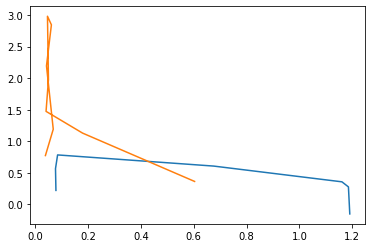

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 3101 loss is tensor([0.0048], grad_fn=<AddBackward0>)
epoch: 3102 loss is tensor([-0.0545], grad_fn=<AddBackward0>)
epoch: 3103 loss is tensor([-0.0138], grad_fn=<AddBackward0>)
epoch: 3104 loss is tensor([-0.0616], grad_fn=<AddBackward0>)
epoch: 3105 loss is tensor([-0.0153], grad_fn=<AddBackward0>)
epoch: 3106 loss is tensor([-0.0621], grad_fn=<AddBackward0>)
epoch: 3107 loss is tensor([0.0070], grad_fn=<AddBackward0>)
epoch: 3108 loss is tensor([0.0060], grad_fn=<AddBackward0>)
epoch: 3109 loss is tensor([-0.0662], grad_fn=<AddBackward0>)
epoch: 3110 loss is tensor([-0.0346], grad_fn=<AddBackward0>)
epoch: 3111 loss is tensor([0.0149], grad_fn=<AddBackward0>)
epoch: 3112 loss is tensor([-0.0883], grad_fn=<AddBackward0>)
epoch: 3113 loss is tensor([-0.0304], grad_fn=<AddBackward0>)
epoch: 3114 loss is tensor([-0.0530], grad_fn=<AddBackward0>)
epoch: 3115 loss is tensor([-0.0176], grad_fn=<AddBackward0>)
epoch: 3116 loss is tensor([-0.0170], grad_fn=<AddBackward0>)
epoch: 3117 

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 3201 loss is tensor([-0.0530], grad_fn=<AddBackward0>)
epoch: 3202 loss is tensor([-0.0880], grad_fn=<AddBackward0>)
epoch: 3203 loss is tensor([-0.0612], grad_fn=<AddBackward0>)
epoch: 3204 loss is tensor([-0.0652], grad_fn=<AddBackward0>)
epoch: 3205 loss is tensor([-0.0669], grad_fn=<AddBackward0>)
epoch: 3206 loss is tensor([-0.1012], grad_fn=<AddBackward0>)
epoch: 3207 loss is tensor([-0.0433], grad_fn=<AddBackward0>)
epoch: 3208 loss is tensor([-0.0681], grad_fn=<AddBackward0>)
epoch: 3209 loss is tensor([0.0351], grad_fn=<AddBackward0>)
epoch: 3210 loss is tensor([-0.0991], grad_fn=<AddBackward0>)
epoch: 3211 loss is tensor([-0.0485], grad_fn=<AddBackward0>)
epoch: 3212 loss is tensor([-0.0284], grad_fn=<AddBackward0>)
epoch: 3213 loss is tensor([-0.0075], grad_fn=<AddBackward0>)
epoch: 3214 loss is tensor([-0.0335], grad_fn=<AddBackward0>)
epoch: 3215 loss is tensor([-0.0547], grad_fn=<AddBackward0>)
epoch: 3216 loss is tensor([-0.0363], grad_fn=<AddBackward0>)
epoch: 32

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 3301 loss is tensor([-0.0649], grad_fn=<AddBackward0>)
epoch: 3302 loss is tensor([-0.0691], grad_fn=<AddBackward0>)
epoch: 3303 loss is tensor([-0.0429], grad_fn=<AddBackward0>)
epoch: 3304 loss is tensor([-0.0325], grad_fn=<AddBackward0>)
epoch: 3305 loss is tensor([-0.0129], grad_fn=<AddBackward0>)
epoch: 3306 loss is tensor([-0.0066], grad_fn=<AddBackward0>)
epoch: 3307 loss is tensor([-0.0588], grad_fn=<AddBackward0>)
epoch: 3308 loss is tensor([-0.0757], grad_fn=<AddBackward0>)
epoch: 3309 loss is tensor([-0.0066], grad_fn=<AddBackward0>)
epoch: 3310 loss is tensor([-0.0253], grad_fn=<AddBackward0>)
epoch: 3311 loss is tensor([0.0339], grad_fn=<AddBackward0>)
epoch: 3312 loss is tensor([-0.0620], grad_fn=<AddBackward0>)
epoch: 3313 loss is tensor([-0.0304], grad_fn=<AddBackward0>)
epoch: 3314 loss is tensor([-0.0443], grad_fn=<AddBackward0>)
epoch: 3315 loss is tensor([-0.0675], grad_fn=<AddBackward0>)
epoch: 3316 loss is tensor([-0.0734], grad_fn=<AddBackward0>)
epoch: 33

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 3401 loss is tensor([0.0107], grad_fn=<AddBackward0>)
epoch: 3402 loss is tensor([-0.0382], grad_fn=<AddBackward0>)
epoch: 3403 loss is tensor([-0.0590], grad_fn=<AddBackward0>)
epoch: 3404 loss is tensor([-0.0438], grad_fn=<AddBackward0>)
epoch: 3405 loss is tensor([-0.0118], grad_fn=<AddBackward0>)
epoch: 3406 loss is tensor([-0.0697], grad_fn=<AddBackward0>)
epoch: 3407 loss is tensor([-0.0537], grad_fn=<AddBackward0>)
epoch: 3408 loss is tensor([-0.0763], grad_fn=<AddBackward0>)
epoch: 3409 loss is tensor([-0.0477], grad_fn=<AddBackward0>)
epoch: 3410 loss is tensor([-0.0917], grad_fn=<AddBackward0>)
epoch: 3411 loss is tensor([-0.0641], grad_fn=<AddBackward0>)
epoch: 3412 loss is tensor([-0.0905], grad_fn=<AddBackward0>)
epoch: 3413 loss is tensor([-0.0326], grad_fn=<AddBackward0>)
epoch: 3414 loss is tensor([-0.0701], grad_fn=<AddBackward0>)
epoch: 3415 loss is tensor([-0.0451], grad_fn=<AddBackward0>)
epoch: 3416 loss is tensor([-0.0388], grad_fn=<AddBackward0>)
epoch: 34

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 3501 loss is tensor([-0.0323], grad_fn=<AddBackward0>)
epoch: 3502 loss is tensor([0.0055], grad_fn=<AddBackward0>)
epoch: 3503 loss is tensor([-0.0031], grad_fn=<AddBackward0>)
epoch: 3504 loss is tensor([-0.0730], grad_fn=<AddBackward0>)
epoch: 3505 loss is tensor([-0.1184], grad_fn=<AddBackward0>)
epoch: 3506 loss is tensor([-0.1118], grad_fn=<AddBackward0>)
epoch: 3507 loss is tensor([-0.0894], grad_fn=<AddBackward0>)
epoch: 3508 loss is tensor([-0.0669], grad_fn=<AddBackward0>)
epoch: 3509 loss is tensor([0.0293], grad_fn=<AddBackward0>)
epoch: 3510 loss is tensor([-0.0354], grad_fn=<AddBackward0>)
epoch: 3511 loss is tensor([-0.0901], grad_fn=<AddBackward0>)
epoch: 3512 loss is tensor([-0.0883], grad_fn=<AddBackward0>)
epoch: 3513 loss is tensor([-0.0916], grad_fn=<AddBackward0>)
epoch: 3514 loss is tensor([-0.1194], grad_fn=<AddBackward0>)
epoch: 3515 loss is tensor([0.0005], grad_fn=<AddBackward0>)
epoch: 3516 loss is tensor([-0.0596], grad_fn=<AddBackward0>)
epoch: 3517

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 3601 loss is tensor([-0.0659], grad_fn=<AddBackward0>)
epoch: 3602 loss is tensor([-0.1294], grad_fn=<AddBackward0>)
epoch: 3603 loss is tensor([-0.1116], grad_fn=<AddBackward0>)
epoch: 3604 loss is tensor([-0.0240], grad_fn=<AddBackward0>)
epoch: 3605 loss is tensor([-0.0950], grad_fn=<AddBackward0>)
epoch: 3606 loss is tensor([-0.1273], grad_fn=<AddBackward0>)
epoch: 3607 loss is tensor([-0.0366], grad_fn=<AddBackward0>)
epoch: 3608 loss is tensor([-0.0780], grad_fn=<AddBackward0>)
epoch: 3609 loss is tensor([-0.0974], grad_fn=<AddBackward0>)
epoch: 3610 loss is tensor([-0.1027], grad_fn=<AddBackward0>)
epoch: 3611 loss is tensor([-0.0873], grad_fn=<AddBackward0>)
epoch: 3612 loss is tensor([-0.1529], grad_fn=<AddBackward0>)
epoch: 3613 loss is tensor([-0.0939], grad_fn=<AddBackward0>)
epoch: 3614 loss is tensor([-0.0995], grad_fn=<AddBackward0>)
epoch: 3615 loss is tensor([-0.0722], grad_fn=<AddBackward0>)
epoch: 3616 loss is tensor([-0.1345], grad_fn=<AddBackward0>)
epoch: 3

<Figure size 432x288 with 0 Axes>

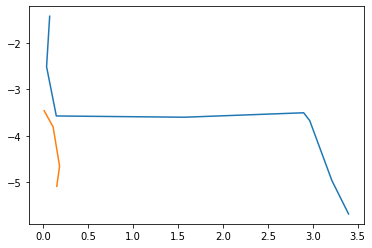

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 3701 loss is tensor([0.0058], grad_fn=<AddBackward0>)
epoch: 3702 loss is tensor([-0.0887], grad_fn=<AddBackward0>)
epoch: 3703 loss is tensor([-0.0617], grad_fn=<AddBackward0>)
epoch: 3704 loss is tensor([-0.0551], grad_fn=<AddBackward0>)
epoch: 3705 loss is tensor([-0.1155], grad_fn=<AddBackward0>)
epoch: 3706 loss is tensor([-0.0300], grad_fn=<AddBackward0>)
epoch: 3707 loss is tensor([-0.0788], grad_fn=<AddBackward0>)
epoch: 3708 loss is tensor([-0.0657], grad_fn=<AddBackward0>)
epoch: 3709 loss is tensor([-0.1340], grad_fn=<AddBackward0>)
epoch: 3710 loss is tensor([-0.0710], grad_fn=<AddBackward0>)
epoch: 3711 loss is tensor([-0.0830], grad_fn=<AddBackward0>)
epoch: 3712 loss is tensor([-0.1020], grad_fn=<AddBackward0>)
epoch: 3713 loss is tensor([-0.0354], grad_fn=<AddBackward0>)
epoch: 3714 loss is tensor([0.0073], grad_fn=<AddBackward0>)
epoch: 3715 loss is tensor([-0.0713], grad_fn=<AddBackward0>)
epoch: 3716 loss is tensor([-0.0759], grad_fn=<AddBackward0>)
epoch: 371

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 3801 loss is tensor([-0.0696], grad_fn=<AddBackward0>)
epoch: 3802 loss is tensor([-0.0907], grad_fn=<AddBackward0>)
epoch: 3803 loss is tensor([-0.1406], grad_fn=<AddBackward0>)
epoch: 3804 loss is tensor([-0.1477], grad_fn=<AddBackward0>)
epoch: 3805 loss is tensor([-0.1362], grad_fn=<AddBackward0>)
epoch: 3806 loss is tensor([-0.0969], grad_fn=<AddBackward0>)
epoch: 3807 loss is tensor([-0.0308], grad_fn=<AddBackward0>)
epoch: 3808 loss is tensor([-0.0973], grad_fn=<AddBackward0>)
epoch: 3809 loss is tensor([-0.1171], grad_fn=<AddBackward0>)
epoch: 3810 loss is tensor([-0.0853], grad_fn=<AddBackward0>)
epoch: 3811 loss is tensor([-0.0981], grad_fn=<AddBackward0>)
epoch: 3812 loss is tensor([-0.1088], grad_fn=<AddBackward0>)
epoch: 3813 loss is tensor([-0.1031], grad_fn=<AddBackward0>)
epoch: 3814 loss is tensor([-0.0838], grad_fn=<AddBackward0>)
epoch: 3815 loss is tensor([-0.1109], grad_fn=<AddBackward0>)
epoch: 3816 loss is tensor([-0.0888], grad_fn=<AddBackward0>)
epoch: 3

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 3901 loss is tensor([-0.0696], grad_fn=<AddBackward0>)
epoch: 3902 loss is tensor([-0.0493], grad_fn=<AddBackward0>)
epoch: 3903 loss is tensor([-0.0407], grad_fn=<AddBackward0>)
epoch: 3904 loss is tensor([-0.0595], grad_fn=<AddBackward0>)
epoch: 3905 loss is tensor([-0.0884], grad_fn=<AddBackward0>)
epoch: 3906 loss is tensor([-0.0578], grad_fn=<AddBackward0>)
epoch: 3907 loss is tensor([-0.0333], grad_fn=<AddBackward0>)
epoch: 3908 loss is tensor([-0.0798], grad_fn=<AddBackward0>)
epoch: 3909 loss is tensor([-0.0620], grad_fn=<AddBackward0>)
epoch: 3910 loss is tensor([-0.0396], grad_fn=<AddBackward0>)
epoch: 3911 loss is tensor([-0.0431], grad_fn=<AddBackward0>)
epoch: 3912 loss is tensor([-0.0531], grad_fn=<AddBackward0>)
epoch: 3913 loss is tensor([-0.1063], grad_fn=<AddBackward0>)
epoch: 3914 loss is tensor([-0.1085], grad_fn=<AddBackward0>)
epoch: 3915 loss is tensor([-0.0874], grad_fn=<AddBackward0>)
epoch: 3916 loss is tensor([-0.0464], grad_fn=<AddBackward0>)
epoch: 3

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 4001 loss is tensor([-0.0988], grad_fn=<AddBackward0>)
epoch: 4002 loss is tensor([-0.1444], grad_fn=<AddBackward0>)
epoch: 4003 loss is tensor([-0.1023], grad_fn=<AddBackward0>)
epoch: 4004 loss is tensor([-0.1815], grad_fn=<AddBackward0>)
epoch: 4005 loss is tensor([-0.1554], grad_fn=<AddBackward0>)
epoch: 4006 loss is tensor([-0.1065], grad_fn=<AddBackward0>)
epoch: 4007 loss is tensor([-0.0909], grad_fn=<AddBackward0>)
epoch: 4008 loss is tensor([-0.0739], grad_fn=<AddBackward0>)
epoch: 4009 loss is tensor([-0.1545], grad_fn=<AddBackward0>)
epoch: 4010 loss is tensor([-0.1306], grad_fn=<AddBackward0>)
epoch: 4011 loss is tensor([-0.1040], grad_fn=<AddBackward0>)
epoch: 4012 loss is tensor([-0.0972], grad_fn=<AddBackward0>)
epoch: 4013 loss is tensor([-0.0868], grad_fn=<AddBackward0>)
epoch: 4014 loss is tensor([-0.0642], grad_fn=<AddBackward0>)
epoch: 4015 loss is tensor([-0.0465], grad_fn=<AddBackward0>)
epoch: 4016 loss is tensor([-0.0497], grad_fn=<AddBackward0>)
epoch: 4

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 4101 loss is tensor([-0.0396], grad_fn=<AddBackward0>)
epoch: 4102 loss is tensor([-0.0755], grad_fn=<AddBackward0>)
epoch: 4103 loss is tensor([-0.1095], grad_fn=<AddBackward0>)
epoch: 4104 loss is tensor([-0.0757], grad_fn=<AddBackward0>)
epoch: 4105 loss is tensor([-0.1276], grad_fn=<AddBackward0>)
epoch: 4106 loss is tensor([-0.0835], grad_fn=<AddBackward0>)
epoch: 4107 loss is tensor([-0.1158], grad_fn=<AddBackward0>)
epoch: 4108 loss is tensor([-0.1159], grad_fn=<AddBackward0>)
epoch: 4109 loss is tensor([-0.1080], grad_fn=<AddBackward0>)
epoch: 4110 loss is tensor([-0.1196], grad_fn=<AddBackward0>)
epoch: 4111 loss is tensor([-0.0902], grad_fn=<AddBackward0>)
epoch: 4112 loss is tensor([-0.1210], grad_fn=<AddBackward0>)
epoch: 4113 loss is tensor([-0.1275], grad_fn=<AddBackward0>)
epoch: 4114 loss is tensor([-0.1089], grad_fn=<AddBackward0>)
epoch: 4115 loss is tensor([-0.0963], grad_fn=<AddBackward0>)
epoch: 4116 loss is tensor([-0.0997], grad_fn=<AddBackward0>)
epoch: 4

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 4201 loss is tensor([-0.1484], grad_fn=<AddBackward0>)
epoch: 4202 loss is tensor([-0.1615], grad_fn=<AddBackward0>)
epoch: 4203 loss is tensor([-0.1333], grad_fn=<AddBackward0>)
epoch: 4204 loss is tensor([-0.1142], grad_fn=<AddBackward0>)
epoch: 4205 loss is tensor([-0.1281], grad_fn=<AddBackward0>)
epoch: 4206 loss is tensor([-0.1261], grad_fn=<AddBackward0>)
epoch: 4207 loss is tensor([-0.1050], grad_fn=<AddBackward0>)
epoch: 4208 loss is tensor([-0.1595], grad_fn=<AddBackward0>)
epoch: 4209 loss is tensor([-0.1342], grad_fn=<AddBackward0>)
epoch: 4210 loss is tensor([-0.1169], grad_fn=<AddBackward0>)
epoch: 4211 loss is tensor([-0.1789], grad_fn=<AddBackward0>)
epoch: 4212 loss is tensor([-0.0849], grad_fn=<AddBackward0>)
epoch: 4213 loss is tensor([-0.1045], grad_fn=<AddBackward0>)
epoch: 4214 loss is tensor([-0.1468], grad_fn=<AddBackward0>)
epoch: 4215 loss is tensor([-0.1071], grad_fn=<AddBackward0>)
epoch: 4216 loss is tensor([-0.1384], grad_fn=<AddBackward0>)
epoch: 4

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 4301 loss is tensor([-0.1031], grad_fn=<AddBackward0>)
epoch: 4302 loss is tensor([-0.0699], grad_fn=<AddBackward0>)
epoch: 4303 loss is tensor([-0.0668], grad_fn=<AddBackward0>)
epoch: 4304 loss is tensor([-0.0827], grad_fn=<AddBackward0>)
epoch: 4305 loss is tensor([-0.1166], grad_fn=<AddBackward0>)
epoch: 4306 loss is tensor([-0.0954], grad_fn=<AddBackward0>)
epoch: 4307 loss is tensor([-0.1584], grad_fn=<AddBackward0>)
epoch: 4308 loss is tensor([-0.1275], grad_fn=<AddBackward0>)
epoch: 4309 loss is tensor([-0.0829], grad_fn=<AddBackward0>)
epoch: 4310 loss is tensor([-0.0972], grad_fn=<AddBackward0>)
epoch: 4311 loss is tensor([-0.1718], grad_fn=<AddBackward0>)
epoch: 4312 loss is tensor([-0.0698], grad_fn=<AddBackward0>)
epoch: 4313 loss is tensor([-0.1349], grad_fn=<AddBackward0>)
epoch: 4314 loss is tensor([-0.0958], grad_fn=<AddBackward0>)
epoch: 4315 loss is tensor([-0.0928], grad_fn=<AddBackward0>)
epoch: 4316 loss is tensor([-0.1624], grad_fn=<AddBackward0>)
epoch: 4

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 4401 loss is tensor([-0.1642], grad_fn=<AddBackward0>)
epoch: 4402 loss is tensor([-0.1342], grad_fn=<AddBackward0>)
epoch: 4403 loss is tensor([-0.0792], grad_fn=<AddBackward0>)
epoch: 4404 loss is tensor([-0.1663], grad_fn=<AddBackward0>)
epoch: 4405 loss is tensor([-0.1092], grad_fn=<AddBackward0>)
epoch: 4406 loss is tensor([-0.1341], grad_fn=<AddBackward0>)
epoch: 4407 loss is tensor([-0.0958], grad_fn=<AddBackward0>)
epoch: 4408 loss is tensor([-0.1448], grad_fn=<AddBackward0>)
epoch: 4409 loss is tensor([-0.0895], grad_fn=<AddBackward0>)
epoch: 4410 loss is tensor([-0.1730], grad_fn=<AddBackward0>)
epoch: 4411 loss is tensor([-0.0603], grad_fn=<AddBackward0>)
epoch: 4412 loss is tensor([-0.0969], grad_fn=<AddBackward0>)
epoch: 4413 loss is tensor([-0.0949], grad_fn=<AddBackward0>)
epoch: 4414 loss is tensor([-0.1541], grad_fn=<AddBackward0>)
epoch: 4415 loss is tensor([-0.1249], grad_fn=<AddBackward0>)
epoch: 4416 loss is tensor([-0.1717], grad_fn=<AddBackward0>)
epoch: 4

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 4501 loss is tensor([-0.1108], grad_fn=<AddBackward0>)
epoch: 4502 loss is tensor([-0.1554], grad_fn=<AddBackward0>)
epoch: 4503 loss is tensor([-0.1421], grad_fn=<AddBackward0>)
epoch: 4504 loss is tensor([-0.1099], grad_fn=<AddBackward0>)
epoch: 4505 loss is tensor([-0.1435], grad_fn=<AddBackward0>)
epoch: 4506 loss is tensor([-0.1462], grad_fn=<AddBackward0>)
epoch: 4507 loss is tensor([-0.1288], grad_fn=<AddBackward0>)
epoch: 4508 loss is tensor([-0.1262], grad_fn=<AddBackward0>)
epoch: 4509 loss is tensor([-0.1232], grad_fn=<AddBackward0>)
epoch: 4510 loss is tensor([-0.1728], grad_fn=<AddBackward0>)
epoch: 4511 loss is tensor([-0.1288], grad_fn=<AddBackward0>)
epoch: 4512 loss is tensor([-0.1784], grad_fn=<AddBackward0>)
epoch: 4513 loss is tensor([-0.0951], grad_fn=<AddBackward0>)
epoch: 4514 loss is tensor([-0.1857], grad_fn=<AddBackward0>)
epoch: 4515 loss is tensor([-0.1580], grad_fn=<AddBackward0>)
epoch: 4516 loss is tensor([-0.1732], grad_fn=<AddBackward0>)
epoch: 4

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 4601 loss is tensor([-0.0571], grad_fn=<AddBackward0>)
epoch: 4602 loss is tensor([-0.1197], grad_fn=<AddBackward0>)
epoch: 4603 loss is tensor([-0.1200], grad_fn=<AddBackward0>)
epoch: 4604 loss is tensor([-0.1503], grad_fn=<AddBackward0>)
epoch: 4605 loss is tensor([-0.1413], grad_fn=<AddBackward0>)
epoch: 4606 loss is tensor([-0.1783], grad_fn=<AddBackward0>)
epoch: 4607 loss is tensor([-0.1268], grad_fn=<AddBackward0>)
epoch: 4608 loss is tensor([-0.1437], grad_fn=<AddBackward0>)
epoch: 4609 loss is tensor([-0.1002], grad_fn=<AddBackward0>)
epoch: 4610 loss is tensor([-0.0149], grad_fn=<AddBackward0>)
epoch: 4611 loss is tensor([-0.1189], grad_fn=<AddBackward0>)
epoch: 4612 loss is tensor([-0.0891], grad_fn=<AddBackward0>)
epoch: 4613 loss is tensor([-0.0527], grad_fn=<AddBackward0>)
epoch: 4614 loss is tensor([-0.0262], grad_fn=<AddBackward0>)
epoch: 4615 loss is tensor([-0.0533], grad_fn=<AddBackward0>)
epoch: 4616 loss is tensor([-0.0759], grad_fn=<AddBackward0>)
epoch: 4

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 4701 loss is tensor([-0.1401], grad_fn=<AddBackward0>)
epoch: 4702 loss is tensor([-0.1860], grad_fn=<AddBackward0>)
epoch: 4703 loss is tensor([-0.2036], grad_fn=<AddBackward0>)
epoch: 4704 loss is tensor([-0.1765], grad_fn=<AddBackward0>)
epoch: 4705 loss is tensor([-0.1924], grad_fn=<AddBackward0>)
epoch: 4706 loss is tensor([-0.1437], grad_fn=<AddBackward0>)
epoch: 4707 loss is tensor([-0.0964], grad_fn=<AddBackward0>)
epoch: 4708 loss is tensor([-0.1492], grad_fn=<AddBackward0>)
epoch: 4709 loss is tensor([-0.1132], grad_fn=<AddBackward0>)
epoch: 4710 loss is tensor([-0.1247], grad_fn=<AddBackward0>)
epoch: 4711 loss is tensor([-0.1183], grad_fn=<AddBackward0>)
epoch: 4712 loss is tensor([-0.1361], grad_fn=<AddBackward0>)
epoch: 4713 loss is tensor([-0.1522], grad_fn=<AddBackward0>)
epoch: 4714 loss is tensor([-0.1118], grad_fn=<AddBackward0>)
epoch: 4715 loss is tensor([-0.1521], grad_fn=<AddBackward0>)
epoch: 4716 loss is tensor([-0.1554], grad_fn=<AddBackward0>)
epoch: 4

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 4801 loss is tensor([-0.0825], grad_fn=<AddBackward0>)
epoch: 4802 loss is tensor([-0.1350], grad_fn=<AddBackward0>)
epoch: 4803 loss is tensor([-0.1449], grad_fn=<AddBackward0>)
epoch: 4804 loss is tensor([-0.1600], grad_fn=<AddBackward0>)
epoch: 4805 loss is tensor([-0.1552], grad_fn=<AddBackward0>)
epoch: 4806 loss is tensor([-0.0747], grad_fn=<AddBackward0>)
epoch: 4807 loss is tensor([-0.1443], grad_fn=<AddBackward0>)
epoch: 4808 loss is tensor([-0.1272], grad_fn=<AddBackward0>)
epoch: 4809 loss is tensor([-0.1846], grad_fn=<AddBackward0>)
epoch: 4810 loss is tensor([-0.1381], grad_fn=<AddBackward0>)
epoch: 4811 loss is tensor([-0.1825], grad_fn=<AddBackward0>)
epoch: 4812 loss is tensor([-0.2264], grad_fn=<AddBackward0>)
epoch: 4813 loss is tensor([-0.1738], grad_fn=<AddBackward0>)
epoch: 4814 loss is tensor([-0.1785], grad_fn=<AddBackward0>)
epoch: 4815 loss is tensor([-0.1873], grad_fn=<AddBackward0>)
epoch: 4816 loss is tensor([-0.1610], grad_fn=<AddBackward0>)
epoch: 4

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 4901 loss is tensor([-0.1925], grad_fn=<AddBackward0>)
epoch: 4902 loss is tensor([-0.0680], grad_fn=<AddBackward0>)
epoch: 4903 loss is tensor([-0.1194], grad_fn=<AddBackward0>)
epoch: 4904 loss is tensor([-0.0915], grad_fn=<AddBackward0>)
epoch: 4905 loss is tensor([-0.1396], grad_fn=<AddBackward0>)
epoch: 4906 loss is tensor([-0.0888], grad_fn=<AddBackward0>)
epoch: 4907 loss is tensor([-0.1639], grad_fn=<AddBackward0>)
epoch: 4908 loss is tensor([-0.0802], grad_fn=<AddBackward0>)
epoch: 4909 loss is tensor([-0.1267], grad_fn=<AddBackward0>)
epoch: 4910 loss is tensor([-0.0676], grad_fn=<AddBackward0>)
epoch: 4911 loss is tensor([-0.1094], grad_fn=<AddBackward0>)
epoch: 4912 loss is tensor([-0.1415], grad_fn=<AddBackward0>)
epoch: 4913 loss is tensor([-0.0562], grad_fn=<AddBackward0>)
epoch: 4914 loss is tensor([-0.2115], grad_fn=<AddBackward0>)
epoch: 4915 loss is tensor([-0.1611], grad_fn=<AddBackward0>)
epoch: 4916 loss is tensor([-0.1909], grad_fn=<AddBackward0>)
epoch: 4

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 5001 loss is tensor([-0.1781], grad_fn=<AddBackward0>)
epoch: 5002 loss is tensor([-0.2104], grad_fn=<AddBackward0>)
epoch: 5003 loss is tensor([-0.1630], grad_fn=<AddBackward0>)
epoch: 5004 loss is tensor([-0.2461], grad_fn=<AddBackward0>)
epoch: 5005 loss is tensor([-0.1624], grad_fn=<AddBackward0>)
epoch: 5006 loss is tensor([-0.1930], grad_fn=<AddBackward0>)
epoch: 5007 loss is tensor([-0.1887], grad_fn=<AddBackward0>)
epoch: 5008 loss is tensor([-0.2127], grad_fn=<AddBackward0>)
epoch: 5009 loss is tensor([-0.2015], grad_fn=<AddBackward0>)
epoch: 5010 loss is tensor([-0.1579], grad_fn=<AddBackward0>)
epoch: 5011 loss is tensor([-0.1373], grad_fn=<AddBackward0>)
epoch: 5012 loss is tensor([-0.1847], grad_fn=<AddBackward0>)
epoch: 5013 loss is tensor([-0.2173], grad_fn=<AddBackward0>)
epoch: 5014 loss is tensor([-0.1279], grad_fn=<AddBackward0>)
epoch: 5015 loss is tensor([-0.1739], grad_fn=<AddBackward0>)
epoch: 5016 loss is tensor([-0.2041], grad_fn=<AddBackward0>)
epoch: 5

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 5101 loss is tensor([-0.1479], grad_fn=<AddBackward0>)
epoch: 5102 loss is tensor([-0.1919], grad_fn=<AddBackward0>)
epoch: 5103 loss is tensor([-0.2249], grad_fn=<AddBackward0>)
epoch: 5104 loss is tensor([-0.1860], grad_fn=<AddBackward0>)
epoch: 5105 loss is tensor([-0.1394], grad_fn=<AddBackward0>)
epoch: 5106 loss is tensor([-0.1064], grad_fn=<AddBackward0>)
epoch: 5107 loss is tensor([-0.1633], grad_fn=<AddBackward0>)
epoch: 5108 loss is tensor([-0.1773], grad_fn=<AddBackward0>)
epoch: 5109 loss is tensor([-0.1899], grad_fn=<AddBackward0>)
epoch: 5110 loss is tensor([-0.2202], grad_fn=<AddBackward0>)
epoch: 5111 loss is tensor([-0.1742], grad_fn=<AddBackward0>)
epoch: 5112 loss is tensor([-0.1207], grad_fn=<AddBackward0>)
epoch: 5113 loss is tensor([-0.1567], grad_fn=<AddBackward0>)
epoch: 5114 loss is tensor([-0.2166], grad_fn=<AddBackward0>)
epoch: 5115 loss is tensor([-0.1526], grad_fn=<AddBackward0>)
epoch: 5116 loss is tensor([-0.1905], grad_fn=<AddBackward0>)
epoch: 5

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 5201 loss is tensor([-0.1820], grad_fn=<AddBackward0>)
epoch: 5202 loss is tensor([-0.1465], grad_fn=<AddBackward0>)
epoch: 5203 loss is tensor([-0.1085], grad_fn=<AddBackward0>)
epoch: 5204 loss is tensor([-0.1531], grad_fn=<AddBackward0>)
epoch: 5205 loss is tensor([-0.1751], grad_fn=<AddBackward0>)
epoch: 5206 loss is tensor([-0.1447], grad_fn=<AddBackward0>)
epoch: 5207 loss is tensor([-0.1825], grad_fn=<AddBackward0>)
epoch: 5208 loss is tensor([-0.1404], grad_fn=<AddBackward0>)
epoch: 5209 loss is tensor([-0.1230], grad_fn=<AddBackward0>)
epoch: 5210 loss is tensor([-0.1234], grad_fn=<AddBackward0>)
epoch: 5211 loss is tensor([-0.1909], grad_fn=<AddBackward0>)
epoch: 5212 loss is tensor([-0.1799], grad_fn=<AddBackward0>)
epoch: 5213 loss is tensor([-0.1895], grad_fn=<AddBackward0>)
epoch: 5214 loss is tensor([-0.1286], grad_fn=<AddBackward0>)
epoch: 5215 loss is tensor([-0.1521], grad_fn=<AddBackward0>)
epoch: 5216 loss is tensor([-0.1860], grad_fn=<AddBackward0>)
epoch: 5

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 5301 loss is tensor([-0.2187], grad_fn=<AddBackward0>)
epoch: 5302 loss is tensor([-0.2427], grad_fn=<AddBackward0>)
epoch: 5303 loss is tensor([-0.1667], grad_fn=<AddBackward0>)
epoch: 5304 loss is tensor([-0.1958], grad_fn=<AddBackward0>)
epoch: 5305 loss is tensor([-0.2277], grad_fn=<AddBackward0>)
epoch: 5306 loss is tensor([-0.1615], grad_fn=<AddBackward0>)
epoch: 5307 loss is tensor([-0.1898], grad_fn=<AddBackward0>)
epoch: 5308 loss is tensor([-0.1019], grad_fn=<AddBackward0>)
epoch: 5309 loss is tensor([-0.1902], grad_fn=<AddBackward0>)
epoch: 5310 loss is tensor([-0.2090], grad_fn=<AddBackward0>)
epoch: 5311 loss is tensor([-0.1303], grad_fn=<AddBackward0>)
epoch: 5312 loss is tensor([-0.2301], grad_fn=<AddBackward0>)
epoch: 5313 loss is tensor([-0.2228], grad_fn=<AddBackward0>)
epoch: 5314 loss is tensor([-0.1892], grad_fn=<AddBackward0>)
epoch: 5315 loss is tensor([-0.1706], grad_fn=<AddBackward0>)
epoch: 5316 loss is tensor([-0.1551], grad_fn=<AddBackward0>)
epoch: 5

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 5401 loss is tensor([-0.1411], grad_fn=<AddBackward0>)
epoch: 5402 loss is tensor([-0.2144], grad_fn=<AddBackward0>)
epoch: 5403 loss is tensor([-0.1684], grad_fn=<AddBackward0>)
epoch: 5404 loss is tensor([-0.1891], grad_fn=<AddBackward0>)
epoch: 5405 loss is tensor([-0.1485], grad_fn=<AddBackward0>)
epoch: 5406 loss is tensor([-0.1509], grad_fn=<AddBackward0>)
epoch: 5407 loss is tensor([-0.1526], grad_fn=<AddBackward0>)
epoch: 5408 loss is tensor([-0.1256], grad_fn=<AddBackward0>)
epoch: 5409 loss is tensor([-0.1688], grad_fn=<AddBackward0>)
epoch: 5410 loss is tensor([-0.1159], grad_fn=<AddBackward0>)
epoch: 5411 loss is tensor([-0.1499], grad_fn=<AddBackward0>)
epoch: 5412 loss is tensor([-0.1869], grad_fn=<AddBackward0>)
epoch: 5413 loss is tensor([-0.1189], grad_fn=<AddBackward0>)
epoch: 5414 loss is tensor([-0.1937], grad_fn=<AddBackward0>)
epoch: 5415 loss is tensor([-0.1557], grad_fn=<AddBackward0>)
epoch: 5416 loss is tensor([-0.1964], grad_fn=<AddBackward0>)
epoch: 5

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 5501 loss is tensor([-0.2538], grad_fn=<AddBackward0>)
epoch: 5502 loss is tensor([-0.2116], grad_fn=<AddBackward0>)
epoch: 5503 loss is tensor([-0.1950], grad_fn=<AddBackward0>)
epoch: 5504 loss is tensor([-0.2387], grad_fn=<AddBackward0>)
epoch: 5505 loss is tensor([-0.1983], grad_fn=<AddBackward0>)
epoch: 5506 loss is tensor([-0.1355], grad_fn=<AddBackward0>)
epoch: 5507 loss is tensor([-0.1752], grad_fn=<AddBackward0>)
epoch: 5508 loss is tensor([-0.2026], grad_fn=<AddBackward0>)
epoch: 5509 loss is tensor([-0.1686], grad_fn=<AddBackward0>)
epoch: 5510 loss is tensor([-0.1807], grad_fn=<AddBackward0>)
epoch: 5511 loss is tensor([-0.1661], grad_fn=<AddBackward0>)
epoch: 5512 loss is tensor([-0.1522], grad_fn=<AddBackward0>)
epoch: 5513 loss is tensor([-0.0781], grad_fn=<AddBackward0>)
epoch: 5514 loss is tensor([-0.1168], grad_fn=<AddBackward0>)
epoch: 5515 loss is tensor([-0.1652], grad_fn=<AddBackward0>)
epoch: 5516 loss is tensor([-0.1591], grad_fn=<AddBackward0>)
epoch: 5

<Figure size 432x288 with 0 Axes>

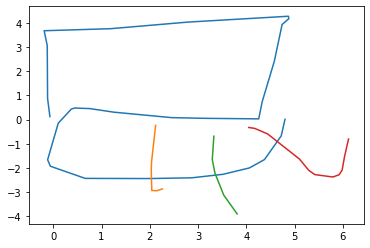

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 5601 loss is tensor([-0.3030], grad_fn=<AddBackward0>)
epoch: 5602 loss is tensor([-0.2124], grad_fn=<AddBackward0>)
epoch: 5603 loss is tensor([-0.2281], grad_fn=<AddBackward0>)
epoch: 5604 loss is tensor([-0.2388], grad_fn=<AddBackward0>)
epoch: 5605 loss is tensor([-0.1817], grad_fn=<AddBackward0>)
epoch: 5606 loss is tensor([-0.2181], grad_fn=<AddBackward0>)
epoch: 5607 loss is tensor([-0.2165], grad_fn=<AddBackward0>)
epoch: 5608 loss is tensor([-0.2562], grad_fn=<AddBackward0>)
epoch: 5609 loss is tensor([-0.2298], grad_fn=<AddBackward0>)
epoch: 5610 loss is tensor([-0.1406], grad_fn=<AddBackward0>)
epoch: 5611 loss is tensor([-0.1810], grad_fn=<AddBackward0>)
epoch: 5612 loss is tensor([-0.2021], grad_fn=<AddBackward0>)
epoch: 5613 loss is tensor([-0.2003], grad_fn=<AddBackward0>)
epoch: 5614 loss is tensor([-0.1944], grad_fn=<AddBackward0>)
epoch: 5615 loss is tensor([-0.1962], grad_fn=<AddBackward0>)
epoch: 5616 loss is tensor([-0.1723], grad_fn=<AddBackward0>)
epoch: 5

<Figure size 432x288 with 0 Axes>

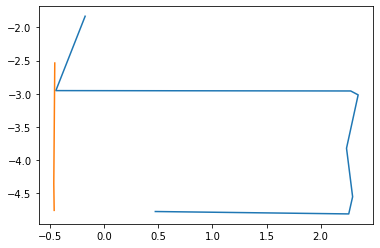

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 5701 loss is tensor([-0.2323], grad_fn=<AddBackward0>)
epoch: 5702 loss is tensor([-0.1721], grad_fn=<AddBackward0>)
epoch: 5703 loss is tensor([-0.2246], grad_fn=<AddBackward0>)
epoch: 5704 loss is tensor([-0.2253], grad_fn=<AddBackward0>)
epoch: 5705 loss is tensor([-0.1891], grad_fn=<AddBackward0>)
epoch: 5706 loss is tensor([-0.1868], grad_fn=<AddBackward0>)
epoch: 5707 loss is tensor([-0.2310], grad_fn=<AddBackward0>)
epoch: 5708 loss is tensor([-0.2057], grad_fn=<AddBackward0>)
epoch: 5709 loss is tensor([-0.2048], grad_fn=<AddBackward0>)
epoch: 5710 loss is tensor([-0.2125], grad_fn=<AddBackward0>)
epoch: 5711 loss is tensor([-0.2665], grad_fn=<AddBackward0>)
epoch: 5712 loss is tensor([-0.2056], grad_fn=<AddBackward0>)
epoch: 5713 loss is tensor([-0.1931], grad_fn=<AddBackward0>)
epoch: 5714 loss is tensor([-0.2692], grad_fn=<AddBackward0>)
epoch: 5715 loss is tensor([-0.2204], grad_fn=<AddBackward0>)
epoch: 5716 loss is tensor([-0.1625], grad_fn=<AddBackward0>)
epoch: 5

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 5801 loss is tensor([-0.2749], grad_fn=<AddBackward0>)
epoch: 5802 loss is tensor([-0.2059], grad_fn=<AddBackward0>)
epoch: 5803 loss is tensor([-0.2224], grad_fn=<AddBackward0>)
epoch: 5804 loss is tensor([-0.2516], grad_fn=<AddBackward0>)
epoch: 5805 loss is tensor([-0.1953], grad_fn=<AddBackward0>)
epoch: 5806 loss is tensor([-0.1973], grad_fn=<AddBackward0>)
epoch: 5807 loss is tensor([-0.1922], grad_fn=<AddBackward0>)
epoch: 5808 loss is tensor([-0.1604], grad_fn=<AddBackward0>)
epoch: 5809 loss is tensor([-0.1868], grad_fn=<AddBackward0>)
epoch: 5810 loss is tensor([-0.2379], grad_fn=<AddBackward0>)
epoch: 5811 loss is tensor([-0.2367], grad_fn=<AddBackward0>)
epoch: 5812 loss is tensor([-0.2008], grad_fn=<AddBackward0>)
epoch: 5813 loss is tensor([-0.1801], grad_fn=<AddBackward0>)
epoch: 5814 loss is tensor([-0.2077], grad_fn=<AddBackward0>)
epoch: 5815 loss is tensor([-0.2074], grad_fn=<AddBackward0>)
epoch: 5816 loss is tensor([-0.2001], grad_fn=<AddBackward0>)
epoch: 5

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 5901 loss is tensor([-0.2270], grad_fn=<AddBackward0>)
epoch: 5902 loss is tensor([-0.1672], grad_fn=<AddBackward0>)
epoch: 5903 loss is tensor([-0.1895], grad_fn=<AddBackward0>)
epoch: 5904 loss is tensor([-0.2208], grad_fn=<AddBackward0>)
epoch: 5905 loss is tensor([-0.2577], grad_fn=<AddBackward0>)
epoch: 5906 loss is tensor([-0.1757], grad_fn=<AddBackward0>)
epoch: 5907 loss is tensor([-0.1962], grad_fn=<AddBackward0>)
epoch: 5908 loss is tensor([-0.2216], grad_fn=<AddBackward0>)
epoch: 5909 loss is tensor([-0.2398], grad_fn=<AddBackward0>)
epoch: 5910 loss is tensor([-0.1710], grad_fn=<AddBackward0>)
epoch: 5911 loss is tensor([-0.2399], grad_fn=<AddBackward0>)
epoch: 5912 loss is tensor([-0.1724], grad_fn=<AddBackward0>)
epoch: 5913 loss is tensor([-0.2195], grad_fn=<AddBackward0>)
epoch: 5914 loss is tensor([-0.2203], grad_fn=<AddBackward0>)
epoch: 5915 loss is tensor([-0.1563], grad_fn=<AddBackward0>)
epoch: 5916 loss is tensor([-0.2114], grad_fn=<AddBackward0>)
epoch: 5

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 6001 loss is tensor([-0.1838], grad_fn=<AddBackward0>)
epoch: 6002 loss is tensor([-0.1860], grad_fn=<AddBackward0>)
epoch: 6003 loss is tensor([-0.1622], grad_fn=<AddBackward0>)
epoch: 6004 loss is tensor([-0.1783], grad_fn=<AddBackward0>)
epoch: 6005 loss is tensor([-0.2108], grad_fn=<AddBackward0>)
epoch: 6006 loss is tensor([-0.1630], grad_fn=<AddBackward0>)
epoch: 6007 loss is tensor([-0.1466], grad_fn=<AddBackward0>)
epoch: 6008 loss is tensor([-0.2100], grad_fn=<AddBackward0>)
epoch: 6009 loss is tensor([-0.1528], grad_fn=<AddBackward0>)
epoch: 6010 loss is tensor([-0.2504], grad_fn=<AddBackward0>)
epoch: 6011 loss is tensor([-0.1088], grad_fn=<AddBackward0>)
epoch: 6012 loss is tensor([-0.2066], grad_fn=<AddBackward0>)
epoch: 6013 loss is tensor([-0.1264], grad_fn=<AddBackward0>)
epoch: 6014 loss is tensor([-0.1738], grad_fn=<AddBackward0>)
epoch: 6015 loss is tensor([-0.1796], grad_fn=<AddBackward0>)
epoch: 6016 loss is tensor([-0.2032], grad_fn=<AddBackward0>)
epoch: 6

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 6101 loss is tensor([-0.2596], grad_fn=<AddBackward0>)
epoch: 6102 loss is tensor([-0.2416], grad_fn=<AddBackward0>)
epoch: 6103 loss is tensor([-0.2757], grad_fn=<AddBackward0>)
epoch: 6104 loss is tensor([-0.2316], grad_fn=<AddBackward0>)
epoch: 6105 loss is tensor([-0.2940], grad_fn=<AddBackward0>)
epoch: 6106 loss is tensor([-0.2433], grad_fn=<AddBackward0>)
epoch: 6107 loss is tensor([-0.2556], grad_fn=<AddBackward0>)
epoch: 6108 loss is tensor([-0.2096], grad_fn=<AddBackward0>)
epoch: 6109 loss is tensor([-0.2610], grad_fn=<AddBackward0>)
epoch: 6110 loss is tensor([-0.2179], grad_fn=<AddBackward0>)
epoch: 6111 loss is tensor([-0.2206], grad_fn=<AddBackward0>)
epoch: 6112 loss is tensor([-0.2767], grad_fn=<AddBackward0>)
epoch: 6113 loss is tensor([-0.2798], grad_fn=<AddBackward0>)
epoch: 6114 loss is tensor([-0.2675], grad_fn=<AddBackward0>)
epoch: 6115 loss is tensor([-0.2348], grad_fn=<AddBackward0>)
epoch: 6116 loss is tensor([-0.2082], grad_fn=<AddBackward0>)
epoch: 6

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 6201 loss is tensor([-0.2942], grad_fn=<AddBackward0>)
epoch: 6202 loss is tensor([-0.2146], grad_fn=<AddBackward0>)
epoch: 6203 loss is tensor([-0.2322], grad_fn=<AddBackward0>)
epoch: 6204 loss is tensor([-0.1958], grad_fn=<AddBackward0>)
epoch: 6205 loss is tensor([-0.2593], grad_fn=<AddBackward0>)
epoch: 6206 loss is tensor([-0.2448], grad_fn=<AddBackward0>)
epoch: 6207 loss is tensor([-0.2293], grad_fn=<AddBackward0>)
epoch: 6208 loss is tensor([-0.2612], grad_fn=<AddBackward0>)
epoch: 6209 loss is tensor([-0.2168], grad_fn=<AddBackward0>)
epoch: 6210 loss is tensor([-0.2653], grad_fn=<AddBackward0>)
epoch: 6211 loss is tensor([-0.2191], grad_fn=<AddBackward0>)
epoch: 6212 loss is tensor([-0.2540], grad_fn=<AddBackward0>)
epoch: 6213 loss is tensor([-0.2097], grad_fn=<AddBackward0>)
epoch: 6214 loss is tensor([-0.2745], grad_fn=<AddBackward0>)
epoch: 6215 loss is tensor([-0.2230], grad_fn=<AddBackward0>)
epoch: 6216 loss is tensor([-0.2367], grad_fn=<AddBackward0>)
epoch: 6

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 6301 loss is tensor([-0.2905], grad_fn=<AddBackward0>)
epoch: 6302 loss is tensor([-0.2636], grad_fn=<AddBackward0>)
epoch: 6303 loss is tensor([-0.2652], grad_fn=<AddBackward0>)
epoch: 6304 loss is tensor([-0.2831], grad_fn=<AddBackward0>)
epoch: 6305 loss is tensor([-0.2672], grad_fn=<AddBackward0>)
epoch: 6306 loss is tensor([-0.2343], grad_fn=<AddBackward0>)
epoch: 6307 loss is tensor([-0.2429], grad_fn=<AddBackward0>)
epoch: 6308 loss is tensor([-0.2364], grad_fn=<AddBackward0>)
epoch: 6309 loss is tensor([-0.3610], grad_fn=<AddBackward0>)
epoch: 6310 loss is tensor([-0.2348], grad_fn=<AddBackward0>)
epoch: 6311 loss is tensor([-0.3381], grad_fn=<AddBackward0>)
epoch: 6312 loss is tensor([-0.2829], grad_fn=<AddBackward0>)
epoch: 6313 loss is tensor([-0.3359], grad_fn=<AddBackward0>)
epoch: 6314 loss is tensor([-0.2306], grad_fn=<AddBackward0>)
epoch: 6315 loss is tensor([-0.2467], grad_fn=<AddBackward0>)
epoch: 6316 loss is tensor([-0.2957], grad_fn=<AddBackward0>)
epoch: 6

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 6401 loss is tensor([-0.2716], grad_fn=<AddBackward0>)
epoch: 6402 loss is tensor([-0.2673], grad_fn=<AddBackward0>)
epoch: 6403 loss is tensor([-0.3087], grad_fn=<AddBackward0>)
epoch: 6404 loss is tensor([-0.2292], grad_fn=<AddBackward0>)
epoch: 6405 loss is tensor([-0.2881], grad_fn=<AddBackward0>)
epoch: 6406 loss is tensor([-0.2928], grad_fn=<AddBackward0>)
epoch: 6407 loss is tensor([-0.3370], grad_fn=<AddBackward0>)
epoch: 6408 loss is tensor([-0.2661], grad_fn=<AddBackward0>)
epoch: 6409 loss is tensor([-0.2624], grad_fn=<AddBackward0>)
epoch: 6410 loss is tensor([-0.2510], grad_fn=<AddBackward0>)
epoch: 6411 loss is tensor([-0.2923], grad_fn=<AddBackward0>)
epoch: 6412 loss is tensor([-0.2175], grad_fn=<AddBackward0>)
epoch: 6413 loss is tensor([-0.2496], grad_fn=<AddBackward0>)
epoch: 6414 loss is tensor([-0.1470], grad_fn=<AddBackward0>)
epoch: 6415 loss is tensor([-0.2672], grad_fn=<AddBackward0>)
epoch: 6416 loss is tensor([-0.2079], grad_fn=<AddBackward0>)
epoch: 6

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 6501 loss is tensor([-0.2251], grad_fn=<AddBackward0>)
epoch: 6502 loss is tensor([-0.3340], grad_fn=<AddBackward0>)
epoch: 6503 loss is tensor([-0.3255], grad_fn=<AddBackward0>)
epoch: 6504 loss is tensor([-0.2972], grad_fn=<AddBackward0>)
epoch: 6505 loss is tensor([-0.3279], grad_fn=<AddBackward0>)
epoch: 6506 loss is tensor([-0.3102], grad_fn=<AddBackward0>)
epoch: 6507 loss is tensor([-0.2816], grad_fn=<AddBackward0>)
epoch: 6508 loss is tensor([-0.3013], grad_fn=<AddBackward0>)
epoch: 6509 loss is tensor([-0.2180], grad_fn=<AddBackward0>)
epoch: 6510 loss is tensor([-0.2983], grad_fn=<AddBackward0>)
epoch: 6511 loss is tensor([-0.2744], grad_fn=<AddBackward0>)
epoch: 6512 loss is tensor([-0.2152], grad_fn=<AddBackward0>)
epoch: 6513 loss is tensor([-0.2737], grad_fn=<AddBackward0>)
epoch: 6514 loss is tensor([-0.2912], grad_fn=<AddBackward0>)
epoch: 6515 loss is tensor([-0.3209], grad_fn=<AddBackward0>)
epoch: 6516 loss is tensor([-0.3238], grad_fn=<AddBackward0>)
epoch: 6

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 6601 loss is tensor([-0.2479], grad_fn=<AddBackward0>)
epoch: 6602 loss is tensor([-0.2267], grad_fn=<AddBackward0>)
epoch: 6603 loss is tensor([-0.2673], grad_fn=<AddBackward0>)
epoch: 6604 loss is tensor([-0.2298], grad_fn=<AddBackward0>)
epoch: 6605 loss is tensor([-0.1967], grad_fn=<AddBackward0>)
epoch: 6606 loss is tensor([-0.2738], grad_fn=<AddBackward0>)
epoch: 6607 loss is tensor([-0.2287], grad_fn=<AddBackward0>)
epoch: 6608 loss is tensor([-0.1940], grad_fn=<AddBackward0>)
epoch: 6609 loss is tensor([-0.2539], grad_fn=<AddBackward0>)
epoch: 6610 loss is tensor([-0.2636], grad_fn=<AddBackward0>)
epoch: 6611 loss is tensor([-0.2390], grad_fn=<AddBackward0>)
epoch: 6612 loss is tensor([-0.2322], grad_fn=<AddBackward0>)
epoch: 6613 loss is tensor([-0.2824], grad_fn=<AddBackward0>)
epoch: 6614 loss is tensor([-0.2713], grad_fn=<AddBackward0>)
epoch: 6615 loss is tensor([-0.2079], grad_fn=<AddBackward0>)
epoch: 6616 loss is tensor([-0.2411], grad_fn=<AddBackward0>)
epoch: 6

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 6701 loss is tensor([-0.2282], grad_fn=<AddBackward0>)
epoch: 6702 loss is tensor([-0.2036], grad_fn=<AddBackward0>)
epoch: 6703 loss is tensor([-0.2810], grad_fn=<AddBackward0>)
epoch: 6704 loss is tensor([-0.2554], grad_fn=<AddBackward0>)
epoch: 6705 loss is tensor([-0.3000], grad_fn=<AddBackward0>)
epoch: 6706 loss is tensor([-0.2398], grad_fn=<AddBackward0>)
epoch: 6707 loss is tensor([-0.1976], grad_fn=<AddBackward0>)
epoch: 6708 loss is tensor([-0.2846], grad_fn=<AddBackward0>)
epoch: 6709 loss is tensor([-0.2294], grad_fn=<AddBackward0>)
epoch: 6710 loss is tensor([-0.3321], grad_fn=<AddBackward0>)
epoch: 6711 loss is tensor([-0.3203], grad_fn=<AddBackward0>)
epoch: 6712 loss is tensor([-0.2529], grad_fn=<AddBackward0>)
epoch: 6713 loss is tensor([-0.2911], grad_fn=<AddBackward0>)
epoch: 6714 loss is tensor([-0.2970], grad_fn=<AddBackward0>)
epoch: 6715 loss is tensor([-0.2661], grad_fn=<AddBackward0>)
epoch: 6716 loss is tensor([-0.3319], grad_fn=<AddBackward0>)
epoch: 6

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 6801 loss is tensor([-0.2686], grad_fn=<AddBackward0>)
epoch: 6802 loss is tensor([-0.3047], grad_fn=<AddBackward0>)
epoch: 6803 loss is tensor([-0.2732], grad_fn=<AddBackward0>)
epoch: 6804 loss is tensor([-0.2874], grad_fn=<AddBackward0>)
epoch: 6805 loss is tensor([-0.2699], grad_fn=<AddBackward0>)
epoch: 6806 loss is tensor([-0.3322], grad_fn=<AddBackward0>)
epoch: 6807 loss is tensor([-0.2382], grad_fn=<AddBackward0>)
epoch: 6808 loss is tensor([-0.2902], grad_fn=<AddBackward0>)
epoch: 6809 loss is tensor([-0.3326], grad_fn=<AddBackward0>)
epoch: 6810 loss is tensor([-0.2843], grad_fn=<AddBackward0>)
epoch: 6811 loss is tensor([-0.3084], grad_fn=<AddBackward0>)
epoch: 6812 loss is tensor([-0.2623], grad_fn=<AddBackward0>)
epoch: 6813 loss is tensor([-0.3386], grad_fn=<AddBackward0>)
epoch: 6814 loss is tensor([-0.2815], grad_fn=<AddBackward0>)
epoch: 6815 loss is tensor([-0.2815], grad_fn=<AddBackward0>)
epoch: 6816 loss is tensor([-0.3248], grad_fn=<AddBackward0>)
epoch: 6

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 6901 loss is tensor([-0.2944], grad_fn=<AddBackward0>)
epoch: 6902 loss is tensor([-0.2790], grad_fn=<AddBackward0>)
epoch: 6903 loss is tensor([-0.2961], grad_fn=<AddBackward0>)
epoch: 6904 loss is tensor([-0.2941], grad_fn=<AddBackward0>)
epoch: 6905 loss is tensor([-0.3300], grad_fn=<AddBackward0>)
epoch: 6906 loss is tensor([-0.2971], grad_fn=<AddBackward0>)
epoch: 6907 loss is tensor([-0.3020], grad_fn=<AddBackward0>)
epoch: 6908 loss is tensor([-0.2926], grad_fn=<AddBackward0>)
epoch: 6909 loss is tensor([-0.3218], grad_fn=<AddBackward0>)
epoch: 6910 loss is tensor([-0.3423], grad_fn=<AddBackward0>)
epoch: 6911 loss is tensor([-0.2850], grad_fn=<AddBackward0>)
epoch: 6912 loss is tensor([-0.2975], grad_fn=<AddBackward0>)
epoch: 6913 loss is tensor([-0.3007], grad_fn=<AddBackward0>)
epoch: 6914 loss is tensor([-0.3059], grad_fn=<AddBackward0>)
epoch: 6915 loss is tensor([-0.2794], grad_fn=<AddBackward0>)
epoch: 6916 loss is tensor([-0.3556], grad_fn=<AddBackward0>)
epoch: 6

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 7001 loss is tensor([-0.3033], grad_fn=<AddBackward0>)
epoch: 7002 loss is tensor([-0.3849], grad_fn=<AddBackward0>)
epoch: 7003 loss is tensor([-0.3221], grad_fn=<AddBackward0>)
epoch: 7004 loss is tensor([-0.3372], grad_fn=<AddBackward0>)
epoch: 7005 loss is tensor([-0.3030], grad_fn=<AddBackward0>)
epoch: 7006 loss is tensor([-0.3112], grad_fn=<AddBackward0>)
epoch: 7007 loss is tensor([-0.3021], grad_fn=<AddBackward0>)
epoch: 7008 loss is tensor([-0.3768], grad_fn=<AddBackward0>)
epoch: 7009 loss is tensor([-0.2676], grad_fn=<AddBackward0>)
epoch: 7010 loss is tensor([-0.3582], grad_fn=<AddBackward0>)
epoch: 7011 loss is tensor([-0.2765], grad_fn=<AddBackward0>)
epoch: 7012 loss is tensor([-0.3184], grad_fn=<AddBackward0>)
epoch: 7013 loss is tensor([-0.3116], grad_fn=<AddBackward0>)
epoch: 7014 loss is tensor([-0.3106], grad_fn=<AddBackward0>)
epoch: 7015 loss is tensor([-0.2837], grad_fn=<AddBackward0>)
epoch: 7016 loss is tensor([-0.3215], grad_fn=<AddBackward0>)
epoch: 7

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 7101 loss is tensor([-0.2324], grad_fn=<AddBackward0>)
epoch: 7102 loss is tensor([-0.3084], grad_fn=<AddBackward0>)
epoch: 7103 loss is tensor([-0.3210], grad_fn=<AddBackward0>)
epoch: 7104 loss is tensor([-0.2581], grad_fn=<AddBackward0>)
epoch: 7105 loss is tensor([-0.3101], grad_fn=<AddBackward0>)
epoch: 7106 loss is tensor([-0.2437], grad_fn=<AddBackward0>)
epoch: 7107 loss is tensor([-0.2753], grad_fn=<AddBackward0>)
epoch: 7108 loss is tensor([-0.3008], grad_fn=<AddBackward0>)
epoch: 7109 loss is tensor([-0.2386], grad_fn=<AddBackward0>)
epoch: 7110 loss is tensor([-0.2726], grad_fn=<AddBackward0>)
epoch: 7111 loss is tensor([-0.2795], grad_fn=<AddBackward0>)
epoch: 7112 loss is tensor([-0.2734], grad_fn=<AddBackward0>)
epoch: 7113 loss is tensor([-0.2989], grad_fn=<AddBackward0>)
epoch: 7114 loss is tensor([-0.2797], grad_fn=<AddBackward0>)
epoch: 7115 loss is tensor([-0.2306], grad_fn=<AddBackward0>)
epoch: 7116 loss is tensor([-0.2875], grad_fn=<AddBackward0>)
epoch: 7

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 7201 loss is tensor([-0.3091], grad_fn=<AddBackward0>)
epoch: 7202 loss is tensor([-0.3405], grad_fn=<AddBackward0>)
epoch: 7203 loss is tensor([-0.1983], grad_fn=<AddBackward0>)
epoch: 7204 loss is tensor([-0.3092], grad_fn=<AddBackward0>)
epoch: 7205 loss is tensor([-0.2717], grad_fn=<AddBackward0>)
epoch: 7206 loss is tensor([-0.2934], grad_fn=<AddBackward0>)
epoch: 7207 loss is tensor([-0.3195], grad_fn=<AddBackward0>)
epoch: 7208 loss is tensor([-0.3169], grad_fn=<AddBackward0>)
epoch: 7209 loss is tensor([-0.2630], grad_fn=<AddBackward0>)
epoch: 7210 loss is tensor([-0.2939], grad_fn=<AddBackward0>)
epoch: 7211 loss is tensor([-0.3152], grad_fn=<AddBackward0>)
epoch: 7212 loss is tensor([-0.3021], grad_fn=<AddBackward0>)
epoch: 7213 loss is tensor([-0.3095], grad_fn=<AddBackward0>)
epoch: 7214 loss is tensor([-0.2867], grad_fn=<AddBackward0>)
epoch: 7215 loss is tensor([-0.3173], grad_fn=<AddBackward0>)
epoch: 7216 loss is tensor([-0.2586], grad_fn=<AddBackward0>)
epoch: 7

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 7301 loss is tensor([-0.3078], grad_fn=<AddBackward0>)
epoch: 7302 loss is tensor([-0.3541], grad_fn=<AddBackward0>)
epoch: 7303 loss is tensor([-0.2775], grad_fn=<AddBackward0>)
epoch: 7304 loss is tensor([-0.2963], grad_fn=<AddBackward0>)
epoch: 7305 loss is tensor([-0.2962], grad_fn=<AddBackward0>)
epoch: 7306 loss is tensor([-0.3252], grad_fn=<AddBackward0>)
epoch: 7307 loss is tensor([-0.2720], grad_fn=<AddBackward0>)
epoch: 7308 loss is tensor([-0.3015], grad_fn=<AddBackward0>)
epoch: 7309 loss is tensor([-0.2762], grad_fn=<AddBackward0>)
epoch: 7310 loss is tensor([-0.2931], grad_fn=<AddBackward0>)
epoch: 7311 loss is tensor([-0.3362], grad_fn=<AddBackward0>)
epoch: 7312 loss is tensor([-0.2823], grad_fn=<AddBackward0>)
epoch: 7313 loss is tensor([-0.2813], grad_fn=<AddBackward0>)
epoch: 7314 loss is tensor([-0.2942], grad_fn=<AddBackward0>)
epoch: 7315 loss is tensor([-0.2982], grad_fn=<AddBackward0>)
epoch: 7316 loss is tensor([-0.2951], grad_fn=<AddBackward0>)
epoch: 7

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 7401 loss is tensor([-0.3218], grad_fn=<AddBackward0>)
epoch: 7402 loss is tensor([-0.3501], grad_fn=<AddBackward0>)
epoch: 7403 loss is tensor([-0.3026], grad_fn=<AddBackward0>)
epoch: 7404 loss is tensor([-0.3455], grad_fn=<AddBackward0>)
epoch: 7405 loss is tensor([-0.3297], grad_fn=<AddBackward0>)
epoch: 7406 loss is tensor([-0.3645], grad_fn=<AddBackward0>)
epoch: 7407 loss is tensor([-0.3325], grad_fn=<AddBackward0>)
epoch: 7408 loss is tensor([-0.3732], grad_fn=<AddBackward0>)
epoch: 7409 loss is tensor([-0.3589], grad_fn=<AddBackward0>)
epoch: 7410 loss is tensor([-0.3863], grad_fn=<AddBackward0>)
epoch: 7411 loss is tensor([-0.3467], grad_fn=<AddBackward0>)
epoch: 7412 loss is tensor([-0.3403], grad_fn=<AddBackward0>)
epoch: 7413 loss is tensor([-0.3430], grad_fn=<AddBackward0>)
epoch: 7414 loss is tensor([-0.3644], grad_fn=<AddBackward0>)
epoch: 7415 loss is tensor([-0.3197], grad_fn=<AddBackward0>)
epoch: 7416 loss is tensor([-0.3137], grad_fn=<AddBackward0>)
epoch: 7

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 7501 loss is tensor([-0.2691], grad_fn=<AddBackward0>)
epoch: 7502 loss is tensor([-0.2710], grad_fn=<AddBackward0>)
epoch: 7503 loss is tensor([-0.2684], grad_fn=<AddBackward0>)
epoch: 7504 loss is tensor([-0.2860], grad_fn=<AddBackward0>)
epoch: 7505 loss is tensor([-0.2752], grad_fn=<AddBackward0>)
epoch: 7506 loss is tensor([-0.2452], grad_fn=<AddBackward0>)
epoch: 7507 loss is tensor([-0.3019], grad_fn=<AddBackward0>)
epoch: 7508 loss is tensor([-0.2946], grad_fn=<AddBackward0>)
epoch: 7509 loss is tensor([-0.2338], grad_fn=<AddBackward0>)
epoch: 7510 loss is tensor([-0.2238], grad_fn=<AddBackward0>)
epoch: 7511 loss is tensor([-0.2903], grad_fn=<AddBackward0>)
epoch: 7512 loss is tensor([-0.2039], grad_fn=<AddBackward0>)
epoch: 7513 loss is tensor([-0.2064], grad_fn=<AddBackward0>)
epoch: 7514 loss is tensor([-0.1619], grad_fn=<AddBackward0>)
epoch: 7515 loss is tensor([-0.3046], grad_fn=<AddBackward0>)
epoch: 7516 loss is tensor([-0.2813], grad_fn=<AddBackward0>)
epoch: 7

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 7601 loss is tensor([-0.3327], grad_fn=<AddBackward0>)
epoch: 7602 loss is tensor([-0.3040], grad_fn=<AddBackward0>)
epoch: 7603 loss is tensor([-0.3072], grad_fn=<AddBackward0>)
epoch: 7604 loss is tensor([-0.3919], grad_fn=<AddBackward0>)
epoch: 7605 loss is tensor([-0.3718], grad_fn=<AddBackward0>)
epoch: 7606 loss is tensor([-0.3246], grad_fn=<AddBackward0>)
epoch: 7607 loss is tensor([-0.3478], grad_fn=<AddBackward0>)
epoch: 7608 loss is tensor([-0.2892], grad_fn=<AddBackward0>)
epoch: 7609 loss is tensor([-0.3450], grad_fn=<AddBackward0>)
epoch: 7610 loss is tensor([-0.3254], grad_fn=<AddBackward0>)
epoch: 7611 loss is tensor([-0.3186], grad_fn=<AddBackward0>)
epoch: 7612 loss is tensor([-0.3123], grad_fn=<AddBackward0>)
epoch: 7613 loss is tensor([-0.3038], grad_fn=<AddBackward0>)
epoch: 7614 loss is tensor([-0.2901], grad_fn=<AddBackward0>)
epoch: 7615 loss is tensor([-0.2498], grad_fn=<AddBackward0>)
epoch: 7616 loss is tensor([-0.2635], grad_fn=<AddBackward0>)
epoch: 7

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 7701 loss is tensor([-0.3028], grad_fn=<AddBackward0>)
epoch: 7702 loss is tensor([-0.3429], grad_fn=<AddBackward0>)
epoch: 7703 loss is tensor([-0.3661], grad_fn=<AddBackward0>)
epoch: 7704 loss is tensor([-0.2903], grad_fn=<AddBackward0>)
epoch: 7705 loss is tensor([-0.3466], grad_fn=<AddBackward0>)
epoch: 7706 loss is tensor([-0.3416], grad_fn=<AddBackward0>)
epoch: 7707 loss is tensor([-0.3515], grad_fn=<AddBackward0>)
epoch: 7708 loss is tensor([-0.3362], grad_fn=<AddBackward0>)
epoch: 7709 loss is tensor([-0.3551], grad_fn=<AddBackward0>)
epoch: 7710 loss is tensor([-0.4065], grad_fn=<AddBackward0>)
epoch: 7711 loss is tensor([-0.3045], grad_fn=<AddBackward0>)
epoch: 7712 loss is tensor([-0.3794], grad_fn=<AddBackward0>)
epoch: 7713 loss is tensor([-0.3038], grad_fn=<AddBackward0>)
epoch: 7714 loss is tensor([-0.3599], grad_fn=<AddBackward0>)
epoch: 7715 loss is tensor([-0.3480], grad_fn=<AddBackward0>)
epoch: 7716 loss is tensor([-0.4047], grad_fn=<AddBackward0>)
epoch: 7

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 7801 loss is tensor([-0.2777], grad_fn=<AddBackward0>)
epoch: 7802 loss is tensor([-0.3372], grad_fn=<AddBackward0>)
epoch: 7803 loss is tensor([-0.2871], grad_fn=<AddBackward0>)
epoch: 7804 loss is tensor([-0.2914], grad_fn=<AddBackward0>)
epoch: 7805 loss is tensor([-0.3189], grad_fn=<AddBackward0>)
epoch: 7806 loss is tensor([-0.3351], grad_fn=<AddBackward0>)
epoch: 7807 loss is tensor([-0.3498], grad_fn=<AddBackward0>)
epoch: 7808 loss is tensor([-0.3320], grad_fn=<AddBackward0>)
epoch: 7809 loss is tensor([-0.3512], grad_fn=<AddBackward0>)
epoch: 7810 loss is tensor([-0.3316], grad_fn=<AddBackward0>)
epoch: 7811 loss is tensor([-0.3472], grad_fn=<AddBackward0>)
epoch: 7812 loss is tensor([-0.2706], grad_fn=<AddBackward0>)
epoch: 7813 loss is tensor([-0.3086], grad_fn=<AddBackward0>)
epoch: 7814 loss is tensor([-0.3015], grad_fn=<AddBackward0>)
epoch: 7815 loss is tensor([-0.1982], grad_fn=<AddBackward0>)
epoch: 7816 loss is tensor([-0.2301], grad_fn=<AddBackward0>)
epoch: 7

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 7901 loss is tensor([-0.3626], grad_fn=<AddBackward0>)
epoch: 7902 loss is tensor([-0.3091], grad_fn=<AddBackward0>)
epoch: 7903 loss is tensor([-0.3091], grad_fn=<AddBackward0>)
epoch: 7904 loss is tensor([-0.3784], grad_fn=<AddBackward0>)
epoch: 7905 loss is tensor([-0.3231], grad_fn=<AddBackward0>)
epoch: 7906 loss is tensor([-0.3542], grad_fn=<AddBackward0>)
epoch: 7907 loss is tensor([-0.3328], grad_fn=<AddBackward0>)
epoch: 7908 loss is tensor([-0.3921], grad_fn=<AddBackward0>)
epoch: 7909 loss is tensor([-0.3441], grad_fn=<AddBackward0>)
epoch: 7910 loss is tensor([-0.3622], grad_fn=<AddBackward0>)
epoch: 7911 loss is tensor([-0.3797], grad_fn=<AddBackward0>)
epoch: 7912 loss is tensor([-0.3392], grad_fn=<AddBackward0>)
epoch: 7913 loss is tensor([-0.3700], grad_fn=<AddBackward0>)
epoch: 7914 loss is tensor([-0.3417], grad_fn=<AddBackward0>)
epoch: 7915 loss is tensor([-0.3233], grad_fn=<AddBackward0>)
epoch: 7916 loss is tensor([-0.3209], grad_fn=<AddBackward0>)
epoch: 7

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 8001 loss is tensor([-0.3761], grad_fn=<AddBackward0>)
epoch: 8002 loss is tensor([-0.3161], grad_fn=<AddBackward0>)
epoch: 8003 loss is tensor([-0.3479], grad_fn=<AddBackward0>)
epoch: 8004 loss is tensor([-0.4182], grad_fn=<AddBackward0>)
epoch: 8005 loss is tensor([-0.3803], grad_fn=<AddBackward0>)
epoch: 8006 loss is tensor([-0.3335], grad_fn=<AddBackward0>)
epoch: 8007 loss is tensor([-0.3555], grad_fn=<AddBackward0>)
epoch: 8008 loss is tensor([-0.2922], grad_fn=<AddBackward0>)
epoch: 8009 loss is tensor([-0.3482], grad_fn=<AddBackward0>)
epoch: 8010 loss is tensor([-0.3769], grad_fn=<AddBackward0>)
epoch: 8011 loss is tensor([-0.3564], grad_fn=<AddBackward0>)
epoch: 8012 loss is tensor([-0.4098], grad_fn=<AddBackward0>)
epoch: 8013 loss is tensor([-0.3709], grad_fn=<AddBackward0>)
epoch: 8014 loss is tensor([-0.4256], grad_fn=<AddBackward0>)
epoch: 8015 loss is tensor([-0.3777], grad_fn=<AddBackward0>)
epoch: 8016 loss is tensor([-0.3678], grad_fn=<AddBackward0>)
epoch: 8

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 8101 loss is tensor([-0.3775], grad_fn=<AddBackward0>)
epoch: 8102 loss is tensor([-0.3368], grad_fn=<AddBackward0>)
epoch: 8103 loss is tensor([-0.3720], grad_fn=<AddBackward0>)
epoch: 8104 loss is tensor([-0.3578], grad_fn=<AddBackward0>)
epoch: 8105 loss is tensor([-0.3663], grad_fn=<AddBackward0>)
epoch: 8106 loss is tensor([-0.3432], grad_fn=<AddBackward0>)
epoch: 8107 loss is tensor([-0.3606], grad_fn=<AddBackward0>)
epoch: 8108 loss is tensor([-0.4054], grad_fn=<AddBackward0>)
epoch: 8109 loss is tensor([-0.3689], grad_fn=<AddBackward0>)
epoch: 8110 loss is tensor([-0.3474], grad_fn=<AddBackward0>)
epoch: 8111 loss is tensor([-0.3312], grad_fn=<AddBackward0>)
epoch: 8112 loss is tensor([-0.3462], grad_fn=<AddBackward0>)
epoch: 8113 loss is tensor([-0.3240], grad_fn=<AddBackward0>)
epoch: 8114 loss is tensor([-0.3981], grad_fn=<AddBackward0>)
epoch: 8115 loss is tensor([-0.3609], grad_fn=<AddBackward0>)
epoch: 8116 loss is tensor([-0.3267], grad_fn=<AddBackward0>)
epoch: 8

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 8201 loss is tensor([-0.3170], grad_fn=<AddBackward0>)
epoch: 8202 loss is tensor([-0.3169], grad_fn=<AddBackward0>)
epoch: 8203 loss is tensor([-0.2780], grad_fn=<AddBackward0>)
epoch: 8204 loss is tensor([-0.3547], grad_fn=<AddBackward0>)
epoch: 8205 loss is tensor([-0.3042], grad_fn=<AddBackward0>)
epoch: 8206 loss is tensor([-0.3418], grad_fn=<AddBackward0>)
epoch: 8207 loss is tensor([-0.3123], grad_fn=<AddBackward0>)
epoch: 8208 loss is tensor([-0.2213], grad_fn=<AddBackward0>)
epoch: 8209 loss is tensor([-0.2657], grad_fn=<AddBackward0>)
epoch: 8210 loss is tensor([-0.2953], grad_fn=<AddBackward0>)
epoch: 8211 loss is tensor([-0.3125], grad_fn=<AddBackward0>)
epoch: 8212 loss is tensor([-0.3558], grad_fn=<AddBackward0>)
epoch: 8213 loss is tensor([-0.2991], grad_fn=<AddBackward0>)
epoch: 8214 loss is tensor([-0.3959], grad_fn=<AddBackward0>)
epoch: 8215 loss is tensor([-0.3165], grad_fn=<AddBackward0>)
epoch: 8216 loss is tensor([-0.3233], grad_fn=<AddBackward0>)
epoch: 8

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 8301 loss is tensor([-0.3754], grad_fn=<AddBackward0>)
epoch: 8302 loss is tensor([-0.3543], grad_fn=<AddBackward0>)
epoch: 8303 loss is tensor([-0.3309], grad_fn=<AddBackward0>)
epoch: 8304 loss is tensor([-0.3879], grad_fn=<AddBackward0>)
epoch: 8305 loss is tensor([-0.3463], grad_fn=<AddBackward0>)
epoch: 8306 loss is tensor([-0.3724], grad_fn=<AddBackward0>)
epoch: 8307 loss is tensor([-0.3513], grad_fn=<AddBackward0>)
epoch: 8308 loss is tensor([-0.3554], grad_fn=<AddBackward0>)
epoch: 8309 loss is tensor([-0.2912], grad_fn=<AddBackward0>)
epoch: 8310 loss is tensor([-0.2752], grad_fn=<AddBackward0>)
epoch: 8311 loss is tensor([-0.3427], grad_fn=<AddBackward0>)
epoch: 8312 loss is tensor([-0.3020], grad_fn=<AddBackward0>)
epoch: 8313 loss is tensor([-0.3006], grad_fn=<AddBackward0>)
epoch: 8314 loss is tensor([-0.3248], grad_fn=<AddBackward0>)
epoch: 8315 loss is tensor([-0.3372], grad_fn=<AddBackward0>)
epoch: 8316 loss is tensor([-0.2829], grad_fn=<AddBackward0>)
epoch: 8

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 8401 loss is tensor([-0.3605], grad_fn=<AddBackward0>)
epoch: 8402 loss is tensor([-0.3191], grad_fn=<AddBackward0>)
epoch: 8403 loss is tensor([-0.3361], grad_fn=<AddBackward0>)
epoch: 8404 loss is tensor([-0.3983], grad_fn=<AddBackward0>)
epoch: 8405 loss is tensor([-0.3371], grad_fn=<AddBackward0>)
epoch: 8406 loss is tensor([-0.3330], grad_fn=<AddBackward0>)
epoch: 8407 loss is tensor([-0.3444], grad_fn=<AddBackward0>)
epoch: 8408 loss is tensor([-0.4025], grad_fn=<AddBackward0>)
epoch: 8409 loss is tensor([-0.3184], grad_fn=<AddBackward0>)
epoch: 8410 loss is tensor([-0.3825], grad_fn=<AddBackward0>)
epoch: 8411 loss is tensor([-0.3895], grad_fn=<AddBackward0>)
epoch: 8412 loss is tensor([-0.3417], grad_fn=<AddBackward0>)
epoch: 8413 loss is tensor([-0.3668], grad_fn=<AddBackward0>)
epoch: 8414 loss is tensor([-0.3881], grad_fn=<AddBackward0>)
epoch: 8415 loss is tensor([-0.3822], grad_fn=<AddBackward0>)
epoch: 8416 loss is tensor([-0.4010], grad_fn=<AddBackward0>)
epoch: 8

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 8501 loss is tensor([-0.2836], grad_fn=<AddBackward0>)
epoch: 8502 loss is tensor([-0.3225], grad_fn=<AddBackward0>)
epoch: 8503 loss is tensor([-0.3257], grad_fn=<AddBackward0>)
epoch: 8504 loss is tensor([-0.2869], grad_fn=<AddBackward0>)
epoch: 8505 loss is tensor([-0.3411], grad_fn=<AddBackward0>)
epoch: 8506 loss is tensor([-0.3203], grad_fn=<AddBackward0>)
epoch: 8507 loss is tensor([-0.3302], grad_fn=<AddBackward0>)
epoch: 8508 loss is tensor([-0.3190], grad_fn=<AddBackward0>)
epoch: 8509 loss is tensor([-0.3617], grad_fn=<AddBackward0>)
epoch: 8510 loss is tensor([-0.3343], grad_fn=<AddBackward0>)
epoch: 8511 loss is tensor([-0.3325], grad_fn=<AddBackward0>)
epoch: 8512 loss is tensor([-0.3665], grad_fn=<AddBackward0>)
epoch: 8513 loss is tensor([-0.3760], grad_fn=<AddBackward0>)
epoch: 8514 loss is tensor([-0.3384], grad_fn=<AddBackward0>)
epoch: 8515 loss is tensor([-0.3362], grad_fn=<AddBackward0>)
epoch: 8516 loss is tensor([-0.3647], grad_fn=<AddBackward0>)
epoch: 8

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 8601 loss is tensor([-0.3079], grad_fn=<AddBackward0>)
epoch: 8602 loss is tensor([-0.3927], grad_fn=<AddBackward0>)
epoch: 8603 loss is tensor([-0.3323], grad_fn=<AddBackward0>)
epoch: 8604 loss is tensor([-0.3130], grad_fn=<AddBackward0>)
epoch: 8605 loss is tensor([-0.3679], grad_fn=<AddBackward0>)
epoch: 8606 loss is tensor([-0.4116], grad_fn=<AddBackward0>)
epoch: 8607 loss is tensor([-0.4070], grad_fn=<AddBackward0>)
epoch: 8608 loss is tensor([-0.3823], grad_fn=<AddBackward0>)
epoch: 8609 loss is tensor([-0.3613], grad_fn=<AddBackward0>)
epoch: 8610 loss is tensor([-0.4036], grad_fn=<AddBackward0>)
epoch: 8611 loss is tensor([-0.4123], grad_fn=<AddBackward0>)
epoch: 8612 loss is tensor([-0.3770], grad_fn=<AddBackward0>)
epoch: 8613 loss is tensor([-0.4193], grad_fn=<AddBackward0>)
epoch: 8614 loss is tensor([-0.3723], grad_fn=<AddBackward0>)
epoch: 8615 loss is tensor([-0.3731], grad_fn=<AddBackward0>)
epoch: 8616 loss is tensor([-0.4008], grad_fn=<AddBackward0>)
epoch: 8

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 8701 loss is tensor([-0.3359], grad_fn=<AddBackward0>)
epoch: 8702 loss is tensor([-0.3224], grad_fn=<AddBackward0>)
epoch: 8703 loss is tensor([-0.3132], grad_fn=<AddBackward0>)
epoch: 8704 loss is tensor([-0.2287], grad_fn=<AddBackward0>)
epoch: 8705 loss is tensor([-0.2957], grad_fn=<AddBackward0>)
epoch: 8706 loss is tensor([-0.2899], grad_fn=<AddBackward0>)
epoch: 8707 loss is tensor([-0.2997], grad_fn=<AddBackward0>)
epoch: 8708 loss is tensor([-0.3389], grad_fn=<AddBackward0>)
epoch: 8709 loss is tensor([-0.3725], grad_fn=<AddBackward0>)
epoch: 8710 loss is tensor([-0.3251], grad_fn=<AddBackward0>)
epoch: 8711 loss is tensor([-0.3493], grad_fn=<AddBackward0>)
epoch: 8712 loss is tensor([-0.3352], grad_fn=<AddBackward0>)
epoch: 8713 loss is tensor([-0.3229], grad_fn=<AddBackward0>)
epoch: 8714 loss is tensor([-0.3511], grad_fn=<AddBackward0>)
epoch: 8715 loss is tensor([-0.3125], grad_fn=<AddBackward0>)
epoch: 8716 loss is tensor([-0.2925], grad_fn=<AddBackward0>)
epoch: 8

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 8801 loss is tensor([-0.3295], grad_fn=<AddBackward0>)
epoch: 8802 loss is tensor([-0.3866], grad_fn=<AddBackward0>)
epoch: 8803 loss is tensor([-0.3722], grad_fn=<AddBackward0>)
epoch: 8804 loss is tensor([-0.3602], grad_fn=<AddBackward0>)
epoch: 8805 loss is tensor([-0.3935], grad_fn=<AddBackward0>)
epoch: 8806 loss is tensor([-0.3646], grad_fn=<AddBackward0>)
epoch: 8807 loss is tensor([-0.3681], grad_fn=<AddBackward0>)
epoch: 8808 loss is tensor([-0.3888], grad_fn=<AddBackward0>)
epoch: 8809 loss is tensor([-0.3392], grad_fn=<AddBackward0>)
epoch: 8810 loss is tensor([-0.3766], grad_fn=<AddBackward0>)
epoch: 8811 loss is tensor([-0.3824], grad_fn=<AddBackward0>)
epoch: 8812 loss is tensor([-0.3701], grad_fn=<AddBackward0>)
epoch: 8813 loss is tensor([-0.3772], grad_fn=<AddBackward0>)
epoch: 8814 loss is tensor([-0.3390], grad_fn=<AddBackward0>)
epoch: 8815 loss is tensor([-0.4598], grad_fn=<AddBackward0>)
epoch: 8816 loss is tensor([-0.3913], grad_fn=<AddBackward0>)
epoch: 8

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 8901 loss is tensor([-0.3800], grad_fn=<AddBackward0>)
epoch: 8902 loss is tensor([-0.3198], grad_fn=<AddBackward0>)
epoch: 8903 loss is tensor([-0.3991], grad_fn=<AddBackward0>)
epoch: 8904 loss is tensor([-0.4152], grad_fn=<AddBackward0>)
epoch: 8905 loss is tensor([-0.3914], grad_fn=<AddBackward0>)
epoch: 8906 loss is tensor([-0.3897], grad_fn=<AddBackward0>)
epoch: 8907 loss is tensor([-0.4303], grad_fn=<AddBackward0>)
epoch: 8908 loss is tensor([-0.4383], grad_fn=<AddBackward0>)
epoch: 8909 loss is tensor([-0.3708], grad_fn=<AddBackward0>)
epoch: 8910 loss is tensor([-0.4142], grad_fn=<AddBackward0>)
epoch: 8911 loss is tensor([-0.4020], grad_fn=<AddBackward0>)
epoch: 8912 loss is tensor([-0.4086], grad_fn=<AddBackward0>)
epoch: 8913 loss is tensor([-0.4041], grad_fn=<AddBackward0>)
epoch: 8914 loss is tensor([-0.3799], grad_fn=<AddBackward0>)
epoch: 8915 loss is tensor([-0.4193], grad_fn=<AddBackward0>)
epoch: 8916 loss is tensor([-0.3865], grad_fn=<AddBackward0>)
epoch: 8

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 9001 loss is tensor([-0.4938], grad_fn=<AddBackward0>)
epoch: 9002 loss is tensor([-0.4176], grad_fn=<AddBackward0>)
epoch: 9003 loss is tensor([-0.4354], grad_fn=<AddBackward0>)
epoch: 9004 loss is tensor([-0.4381], grad_fn=<AddBackward0>)
epoch: 9005 loss is tensor([-0.4348], grad_fn=<AddBackward0>)
epoch: 9006 loss is tensor([-0.4276], grad_fn=<AddBackward0>)
epoch: 9007 loss is tensor([-0.3863], grad_fn=<AddBackward0>)
epoch: 9008 loss is tensor([-0.4424], grad_fn=<AddBackward0>)
epoch: 9009 loss is tensor([-0.4311], grad_fn=<AddBackward0>)
epoch: 9010 loss is tensor([-0.4497], grad_fn=<AddBackward0>)
epoch: 9011 loss is tensor([-0.4213], grad_fn=<AddBackward0>)
epoch: 9012 loss is tensor([-0.3951], grad_fn=<AddBackward0>)
epoch: 9013 loss is tensor([-0.3749], grad_fn=<AddBackward0>)
epoch: 9014 loss is tensor([-0.3687], grad_fn=<AddBackward0>)
epoch: 9015 loss is tensor([-0.3422], grad_fn=<AddBackward0>)
epoch: 9016 loss is tensor([-0.3933], grad_fn=<AddBackward0>)
epoch: 9

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 9101 loss is tensor([-0.3899], grad_fn=<AddBackward0>)
epoch: 9102 loss is tensor([-0.3839], grad_fn=<AddBackward0>)
epoch: 9103 loss is tensor([-0.3859], grad_fn=<AddBackward0>)
epoch: 9104 loss is tensor([-0.3526], grad_fn=<AddBackward0>)
epoch: 9105 loss is tensor([-0.4445], grad_fn=<AddBackward0>)
epoch: 9106 loss is tensor([-0.3408], grad_fn=<AddBackward0>)
epoch: 9107 loss is tensor([-0.4174], grad_fn=<AddBackward0>)
epoch: 9108 loss is tensor([-0.4342], grad_fn=<AddBackward0>)
epoch: 9109 loss is tensor([-0.4298], grad_fn=<AddBackward0>)
epoch: 9110 loss is tensor([-0.3445], grad_fn=<AddBackward0>)
epoch: 9111 loss is tensor([-0.3967], grad_fn=<AddBackward0>)
epoch: 9112 loss is tensor([-0.4048], grad_fn=<AddBackward0>)
epoch: 9113 loss is tensor([-0.4048], grad_fn=<AddBackward0>)
epoch: 9114 loss is tensor([-0.4065], grad_fn=<AddBackward0>)
epoch: 9115 loss is tensor([-0.4364], grad_fn=<AddBackward0>)
epoch: 9116 loss is tensor([-0.3709], grad_fn=<AddBackward0>)
epoch: 9

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 9201 loss is tensor([-0.4226], grad_fn=<AddBackward0>)
epoch: 9202 loss is tensor([-0.4233], grad_fn=<AddBackward0>)
epoch: 9203 loss is tensor([-0.4592], grad_fn=<AddBackward0>)
epoch: 9204 loss is tensor([-0.4537], grad_fn=<AddBackward0>)
epoch: 9205 loss is tensor([-0.3811], grad_fn=<AddBackward0>)
epoch: 9206 loss is tensor([-0.3876], grad_fn=<AddBackward0>)
epoch: 9207 loss is tensor([-0.4314], grad_fn=<AddBackward0>)
epoch: 9208 loss is tensor([-0.4454], grad_fn=<AddBackward0>)
epoch: 9209 loss is tensor([-0.4238], grad_fn=<AddBackward0>)
epoch: 9210 loss is tensor([-0.4289], grad_fn=<AddBackward0>)
epoch: 9211 loss is tensor([-0.4447], grad_fn=<AddBackward0>)
epoch: 9212 loss is tensor([-0.4089], grad_fn=<AddBackward0>)
epoch: 9213 loss is tensor([-0.3733], grad_fn=<AddBackward0>)
epoch: 9214 loss is tensor([-0.4119], grad_fn=<AddBackward0>)
epoch: 9215 loss is tensor([-0.3572], grad_fn=<AddBackward0>)
epoch: 9216 loss is tensor([-0.3945], grad_fn=<AddBackward0>)
epoch: 9

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 9301 loss is tensor([-0.3588], grad_fn=<AddBackward0>)
epoch: 9302 loss is tensor([-0.3638], grad_fn=<AddBackward0>)
epoch: 9303 loss is tensor([-0.3939], grad_fn=<AddBackward0>)
epoch: 9304 loss is tensor([-0.4164], grad_fn=<AddBackward0>)
epoch: 9305 loss is tensor([-0.4152], grad_fn=<AddBackward0>)
epoch: 9306 loss is tensor([-0.3707], grad_fn=<AddBackward0>)
epoch: 9307 loss is tensor([-0.3841], grad_fn=<AddBackward0>)
epoch: 9308 loss is tensor([-0.3778], grad_fn=<AddBackward0>)
epoch: 9309 loss is tensor([-0.3597], grad_fn=<AddBackward0>)
epoch: 9310 loss is tensor([-0.3708], grad_fn=<AddBackward0>)
epoch: 9311 loss is tensor([-0.4198], grad_fn=<AddBackward0>)
epoch: 9312 loss is tensor([-0.3574], grad_fn=<AddBackward0>)
epoch: 9313 loss is tensor([-0.3940], grad_fn=<AddBackward0>)
epoch: 9314 loss is tensor([-0.3962], grad_fn=<AddBackward0>)
epoch: 9315 loss is tensor([-0.4103], grad_fn=<AddBackward0>)
epoch: 9316 loss is tensor([-0.3366], grad_fn=<AddBackward0>)
epoch: 9

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 9401 loss is tensor([-0.3168], grad_fn=<AddBackward0>)
epoch: 9402 loss is tensor([-0.3875], grad_fn=<AddBackward0>)
epoch: 9403 loss is tensor([-0.3100], grad_fn=<AddBackward0>)
epoch: 9404 loss is tensor([-0.3671], grad_fn=<AddBackward0>)
epoch: 9405 loss is tensor([-0.3846], grad_fn=<AddBackward0>)
epoch: 9406 loss is tensor([-0.3924], grad_fn=<AddBackward0>)
epoch: 9407 loss is tensor([-0.3820], grad_fn=<AddBackward0>)
epoch: 9408 loss is tensor([-0.3635], grad_fn=<AddBackward0>)
epoch: 9409 loss is tensor([-0.4054], grad_fn=<AddBackward0>)
epoch: 9410 loss is tensor([-0.3818], grad_fn=<AddBackward0>)
epoch: 9411 loss is tensor([-0.4046], grad_fn=<AddBackward0>)
epoch: 9412 loss is tensor([-0.4081], grad_fn=<AddBackward0>)
epoch: 9413 loss is tensor([-0.3496], grad_fn=<AddBackward0>)
epoch: 9414 loss is tensor([-0.4134], grad_fn=<AddBackward0>)
epoch: 9415 loss is tensor([-0.4219], grad_fn=<AddBackward0>)
epoch: 9416 loss is tensor([-0.4227], grad_fn=<AddBackward0>)
epoch: 9

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 9501 loss is tensor([-0.4155], grad_fn=<AddBackward0>)
epoch: 9502 loss is tensor([-0.3622], grad_fn=<AddBackward0>)
epoch: 9503 loss is tensor([-0.3528], grad_fn=<AddBackward0>)
epoch: 9504 loss is tensor([-0.3605], grad_fn=<AddBackward0>)
epoch: 9505 loss is tensor([-0.4103], grad_fn=<AddBackward0>)
epoch: 9506 loss is tensor([-0.3857], grad_fn=<AddBackward0>)
epoch: 9507 loss is tensor([-0.3592], grad_fn=<AddBackward0>)
epoch: 9508 loss is tensor([-0.3591], grad_fn=<AddBackward0>)
epoch: 9509 loss is tensor([-0.3398], grad_fn=<AddBackward0>)
epoch: 9510 loss is tensor([-0.3286], grad_fn=<AddBackward0>)
epoch: 9511 loss is tensor([-0.4085], grad_fn=<AddBackward0>)
epoch: 9512 loss is tensor([-0.3577], grad_fn=<AddBackward0>)
epoch: 9513 loss is tensor([-0.3133], grad_fn=<AddBackward0>)
epoch: 9514 loss is tensor([-0.2655], grad_fn=<AddBackward0>)
epoch: 9515 loss is tensor([-0.3461], grad_fn=<AddBackward0>)
epoch: 9516 loss is tensor([-0.3567], grad_fn=<AddBackward0>)
epoch: 9

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 9601 loss is tensor([-0.3761], grad_fn=<AddBackward0>)
epoch: 9602 loss is tensor([-0.3870], grad_fn=<AddBackward0>)
epoch: 9603 loss is tensor([-0.4188], grad_fn=<AddBackward0>)
epoch: 9604 loss is tensor([-0.4327], grad_fn=<AddBackward0>)
epoch: 9605 loss is tensor([-0.4480], grad_fn=<AddBackward0>)
epoch: 9606 loss is tensor([-0.3437], grad_fn=<AddBackward0>)
epoch: 9607 loss is tensor([-0.4426], grad_fn=<AddBackward0>)
epoch: 9608 loss is tensor([-0.4317], grad_fn=<AddBackward0>)
epoch: 9609 loss is tensor([-0.3959], grad_fn=<AddBackward0>)
epoch: 9610 loss is tensor([-0.3818], grad_fn=<AddBackward0>)
epoch: 9611 loss is tensor([-0.4036], grad_fn=<AddBackward0>)
epoch: 9612 loss is tensor([-0.3932], grad_fn=<AddBackward0>)
epoch: 9613 loss is tensor([-0.4435], grad_fn=<AddBackward0>)
epoch: 9614 loss is tensor([-0.3917], grad_fn=<AddBackward0>)
epoch: 9615 loss is tensor([-0.3597], grad_fn=<AddBackward0>)
epoch: 9616 loss is tensor([-0.4185], grad_fn=<AddBackward0>)
epoch: 9

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 9701 loss is tensor([-0.4303], grad_fn=<AddBackward0>)
epoch: 9702 loss is tensor([-0.3953], grad_fn=<AddBackward0>)
epoch: 9703 loss is tensor([-0.4266], grad_fn=<AddBackward0>)
epoch: 9704 loss is tensor([-0.4575], grad_fn=<AddBackward0>)
epoch: 9705 loss is tensor([-0.3905], grad_fn=<AddBackward0>)
epoch: 9706 loss is tensor([-0.4797], grad_fn=<AddBackward0>)
epoch: 9707 loss is tensor([-0.4306], grad_fn=<AddBackward0>)
epoch: 9708 loss is tensor([-0.4388], grad_fn=<AddBackward0>)
epoch: 9709 loss is tensor([-0.4417], grad_fn=<AddBackward0>)
epoch: 9710 loss is tensor([-0.4116], grad_fn=<AddBackward0>)
epoch: 9711 loss is tensor([-0.4767], grad_fn=<AddBackward0>)
epoch: 9712 loss is tensor([-0.4518], grad_fn=<AddBackward0>)
epoch: 9713 loss is tensor([-0.4739], grad_fn=<AddBackward0>)
epoch: 9714 loss is tensor([-0.4056], grad_fn=<AddBackward0>)
epoch: 9715 loss is tensor([-0.4346], grad_fn=<AddBackward0>)
epoch: 9716 loss is tensor([-0.4415], grad_fn=<AddBackward0>)
epoch: 9

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 9801 loss is tensor([-0.4883], grad_fn=<AddBackward0>)
epoch: 9802 loss is tensor([-0.4199], grad_fn=<AddBackward0>)
epoch: 9803 loss is tensor([-0.4137], grad_fn=<AddBackward0>)
epoch: 9804 loss is tensor([-0.4302], grad_fn=<AddBackward0>)
epoch: 9805 loss is tensor([-0.4237], grad_fn=<AddBackward0>)
epoch: 9806 loss is tensor([-0.4689], grad_fn=<AddBackward0>)
epoch: 9807 loss is tensor([-0.4933], grad_fn=<AddBackward0>)
epoch: 9808 loss is tensor([-0.4959], grad_fn=<AddBackward0>)
epoch: 9809 loss is tensor([-0.4197], grad_fn=<AddBackward0>)
epoch: 9810 loss is tensor([-0.4945], grad_fn=<AddBackward0>)
epoch: 9811 loss is tensor([-0.4472], grad_fn=<AddBackward0>)
epoch: 9812 loss is tensor([-0.4357], grad_fn=<AddBackward0>)
epoch: 9813 loss is tensor([-0.4929], grad_fn=<AddBackward0>)
epoch: 9814 loss is tensor([-0.4497], grad_fn=<AddBackward0>)
epoch: 9815 loss is tensor([-0.4201], grad_fn=<AddBackward0>)
epoch: 9816 loss is tensor([-0.3980], grad_fn=<AddBackward0>)
epoch: 9

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 9901 loss is tensor([-0.3293], grad_fn=<AddBackward0>)
epoch: 9902 loss is tensor([-0.3861], grad_fn=<AddBackward0>)
epoch: 9903 loss is tensor([-0.3778], grad_fn=<AddBackward0>)
epoch: 9904 loss is tensor([-0.3713], grad_fn=<AddBackward0>)
epoch: 9905 loss is tensor([-0.4249], grad_fn=<AddBackward0>)
epoch: 9906 loss is tensor([-0.3195], grad_fn=<AddBackward0>)
epoch: 9907 loss is tensor([-0.4156], grad_fn=<AddBackward0>)
epoch: 9908 loss is tensor([-0.4031], grad_fn=<AddBackward0>)
epoch: 9909 loss is tensor([-0.3079], grad_fn=<AddBackward0>)
epoch: 9910 loss is tensor([-0.3923], grad_fn=<AddBackward0>)
epoch: 9911 loss is tensor([-0.3158], grad_fn=<AddBackward0>)
epoch: 9912 loss is tensor([-0.4320], grad_fn=<AddBackward0>)
epoch: 9913 loss is tensor([-0.3926], grad_fn=<AddBackward0>)
epoch: 9914 loss is tensor([-0.4250], grad_fn=<AddBackward0>)
epoch: 9915 loss is tensor([-0.3847], grad_fn=<AddBackward0>)
epoch: 9916 loss is tensor([-0.4054], grad_fn=<AddBackward0>)
epoch: 9

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 10001 loss is tensor([-0.4110], grad_fn=<AddBackward0>)
epoch: 10002 loss is tensor([-0.4059], grad_fn=<AddBackward0>)
epoch: 10003 loss is tensor([-0.4880], grad_fn=<AddBackward0>)
epoch: 10004 loss is tensor([-0.3917], grad_fn=<AddBackward0>)
epoch: 10005 loss is tensor([-0.4902], grad_fn=<AddBackward0>)
epoch: 10006 loss is tensor([-0.4168], grad_fn=<AddBackward0>)
epoch: 10007 loss is tensor([-0.4301], grad_fn=<AddBackward0>)
epoch: 10008 loss is tensor([-0.5265], grad_fn=<AddBackward0>)
epoch: 10009 loss is tensor([-0.4891], grad_fn=<AddBackward0>)
epoch: 10010 loss is tensor([-0.5126], grad_fn=<AddBackward0>)
epoch: 10011 loss is tensor([-0.4585], grad_fn=<AddBackward0>)
epoch: 10012 loss is tensor([-0.4100], grad_fn=<AddBackward0>)
epoch: 10013 loss is tensor([-0.4744], grad_fn=<AddBackward0>)
epoch: 10014 loss is tensor([-0.3836], grad_fn=<AddBackward0>)
epoch: 10015 loss is tensor([-0.4792], grad_fn=<AddBackward0>)
epoch: 10016 loss is tensor([-0.4071], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 10101 loss is tensor([-0.3805], grad_fn=<AddBackward0>)
epoch: 10102 loss is tensor([-0.3538], grad_fn=<AddBackward0>)
epoch: 10103 loss is tensor([-0.4587], grad_fn=<AddBackward0>)
epoch: 10104 loss is tensor([-0.4228], grad_fn=<AddBackward0>)
epoch: 10105 loss is tensor([-0.3843], grad_fn=<AddBackward0>)
epoch: 10106 loss is tensor([-0.4138], grad_fn=<AddBackward0>)
epoch: 10107 loss is tensor([-0.4447], grad_fn=<AddBackward0>)
epoch: 10108 loss is tensor([-0.4507], grad_fn=<AddBackward0>)
epoch: 10109 loss is tensor([-0.4080], grad_fn=<AddBackward0>)
epoch: 10110 loss is tensor([-0.4416], grad_fn=<AddBackward0>)
epoch: 10111 loss is tensor([-0.4083], grad_fn=<AddBackward0>)
epoch: 10112 loss is tensor([-0.4068], grad_fn=<AddBackward0>)
epoch: 10113 loss is tensor([-0.4405], grad_fn=<AddBackward0>)
epoch: 10114 loss is tensor([-0.3991], grad_fn=<AddBackward0>)
epoch: 10115 loss is tensor([-0.3740], grad_fn=<AddBackward0>)
epoch: 10116 loss is tensor([-0.4369], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 10201 loss is tensor([-0.4578], grad_fn=<AddBackward0>)
epoch: 10202 loss is tensor([-0.4468], grad_fn=<AddBackward0>)
epoch: 10203 loss is tensor([-0.4146], grad_fn=<AddBackward0>)
epoch: 10204 loss is tensor([-0.4622], grad_fn=<AddBackward0>)
epoch: 10205 loss is tensor([-0.4069], grad_fn=<AddBackward0>)
epoch: 10206 loss is tensor([-0.4110], grad_fn=<AddBackward0>)
epoch: 10207 loss is tensor([-0.4170], grad_fn=<AddBackward0>)
epoch: 10208 loss is tensor([-0.4771], grad_fn=<AddBackward0>)
epoch: 10209 loss is tensor([-0.4970], grad_fn=<AddBackward0>)
epoch: 10210 loss is tensor([-0.4333], grad_fn=<AddBackward0>)
epoch: 10211 loss is tensor([-0.4766], grad_fn=<AddBackward0>)
epoch: 10212 loss is tensor([-0.4837], grad_fn=<AddBackward0>)
epoch: 10213 loss is tensor([-0.4438], grad_fn=<AddBackward0>)
epoch: 10214 loss is tensor([-0.4769], grad_fn=<AddBackward0>)
epoch: 10215 loss is tensor([-0.4370], grad_fn=<AddBackward0>)
epoch: 10216 loss is tensor([-0.4321], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 10301 loss is tensor([-0.3872], grad_fn=<AddBackward0>)
epoch: 10302 loss is tensor([-0.3814], grad_fn=<AddBackward0>)
epoch: 10303 loss is tensor([-0.3848], grad_fn=<AddBackward0>)
epoch: 10304 loss is tensor([-0.3758], grad_fn=<AddBackward0>)
epoch: 10305 loss is tensor([-0.3847], grad_fn=<AddBackward0>)
epoch: 10306 loss is tensor([-0.4021], grad_fn=<AddBackward0>)
epoch: 10307 loss is tensor([-0.4298], grad_fn=<AddBackward0>)
epoch: 10308 loss is tensor([-0.4049], grad_fn=<AddBackward0>)
epoch: 10309 loss is tensor([-0.4167], grad_fn=<AddBackward0>)
epoch: 10310 loss is tensor([-0.4293], grad_fn=<AddBackward0>)
epoch: 10311 loss is tensor([-0.3593], grad_fn=<AddBackward0>)
epoch: 10312 loss is tensor([-0.4378], grad_fn=<AddBackward0>)
epoch: 10313 loss is tensor([-0.3896], grad_fn=<AddBackward0>)
epoch: 10314 loss is tensor([-0.4792], grad_fn=<AddBackward0>)
epoch: 10315 loss is tensor([-0.4279], grad_fn=<AddBackward0>)
epoch: 10316 loss is tensor([-0.4042], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 10401 loss is tensor([-0.4459], grad_fn=<AddBackward0>)
epoch: 10402 loss is tensor([-0.4351], grad_fn=<AddBackward0>)
epoch: 10403 loss is tensor([-0.4829], grad_fn=<AddBackward0>)
epoch: 10404 loss is tensor([-0.4725], grad_fn=<AddBackward0>)
epoch: 10405 loss is tensor([-0.4691], grad_fn=<AddBackward0>)
epoch: 10406 loss is tensor([-0.4678], grad_fn=<AddBackward0>)
epoch: 10407 loss is tensor([-0.5070], grad_fn=<AddBackward0>)
epoch: 10408 loss is tensor([-0.4857], grad_fn=<AddBackward0>)
epoch: 10409 loss is tensor([-0.4664], grad_fn=<AddBackward0>)
epoch: 10410 loss is tensor([-0.4908], grad_fn=<AddBackward0>)
epoch: 10411 loss is tensor([-0.4482], grad_fn=<AddBackward0>)
epoch: 10412 loss is tensor([-0.4494], grad_fn=<AddBackward0>)
epoch: 10413 loss is tensor([-0.4608], grad_fn=<AddBackward0>)
epoch: 10414 loss is tensor([-0.4931], grad_fn=<AddBackward0>)
epoch: 10415 loss is tensor([-0.4290], grad_fn=<AddBackward0>)
epoch: 10416 loss is tensor([-0.4828], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 10501 loss is tensor([-0.4558], grad_fn=<AddBackward0>)
epoch: 10502 loss is tensor([-0.4418], grad_fn=<AddBackward0>)
epoch: 10503 loss is tensor([-0.4630], grad_fn=<AddBackward0>)
epoch: 10504 loss is tensor([-0.4421], grad_fn=<AddBackward0>)
epoch: 10505 loss is tensor([-0.4395], grad_fn=<AddBackward0>)
epoch: 10506 loss is tensor([-0.4362], grad_fn=<AddBackward0>)
epoch: 10507 loss is tensor([-0.4876], grad_fn=<AddBackward0>)
epoch: 10508 loss is tensor([-0.4592], grad_fn=<AddBackward0>)
epoch: 10509 loss is tensor([-0.4185], grad_fn=<AddBackward0>)
epoch: 10510 loss is tensor([-0.4078], grad_fn=<AddBackward0>)
epoch: 10511 loss is tensor([-0.3876], grad_fn=<AddBackward0>)
epoch: 10512 loss is tensor([-0.3779], grad_fn=<AddBackward0>)
epoch: 10513 loss is tensor([-0.4783], grad_fn=<AddBackward0>)
epoch: 10514 loss is tensor([-0.4034], grad_fn=<AddBackward0>)
epoch: 10515 loss is tensor([-0.4172], grad_fn=<AddBackward0>)
epoch: 10516 loss is tensor([-0.3962], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 10601 loss is tensor([-0.4134], grad_fn=<AddBackward0>)
epoch: 10602 loss is tensor([-0.4852], grad_fn=<AddBackward0>)
epoch: 10603 loss is tensor([-0.4561], grad_fn=<AddBackward0>)
epoch: 10604 loss is tensor([-0.4996], grad_fn=<AddBackward0>)
epoch: 10605 loss is tensor([-0.4668], grad_fn=<AddBackward0>)
epoch: 10606 loss is tensor([-0.4381], grad_fn=<AddBackward0>)
epoch: 10607 loss is tensor([-0.4900], grad_fn=<AddBackward0>)
epoch: 10608 loss is tensor([-0.4904], grad_fn=<AddBackward0>)
epoch: 10609 loss is tensor([-0.4425], grad_fn=<AddBackward0>)
epoch: 10610 loss is tensor([-0.4952], grad_fn=<AddBackward0>)
epoch: 10611 loss is tensor([-0.4811], grad_fn=<AddBackward0>)
epoch: 10612 loss is tensor([-0.4283], grad_fn=<AddBackward0>)
epoch: 10613 loss is tensor([-0.4291], grad_fn=<AddBackward0>)
epoch: 10614 loss is tensor([-0.3835], grad_fn=<AddBackward0>)
epoch: 10615 loss is tensor([-0.4708], grad_fn=<AddBackward0>)
epoch: 10616 loss is tensor([-0.4682], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 10701 loss is tensor([-0.5406], grad_fn=<AddBackward0>)
epoch: 10702 loss is tensor([-0.4682], grad_fn=<AddBackward0>)
epoch: 10703 loss is tensor([-0.3439], grad_fn=<AddBackward0>)
epoch: 10704 loss is tensor([-0.3683], grad_fn=<AddBackward0>)
epoch: 10705 loss is tensor([-0.4790], grad_fn=<AddBackward0>)
epoch: 10706 loss is tensor([-0.4898], grad_fn=<AddBackward0>)
epoch: 10707 loss is tensor([-0.4417], grad_fn=<AddBackward0>)
epoch: 10708 loss is tensor([-0.4178], grad_fn=<AddBackward0>)
epoch: 10709 loss is tensor([-0.3937], grad_fn=<AddBackward0>)
epoch: 10710 loss is tensor([-0.4420], grad_fn=<AddBackward0>)
epoch: 10711 loss is tensor([-0.4738], grad_fn=<AddBackward0>)
epoch: 10712 loss is tensor([-0.4238], grad_fn=<AddBackward0>)
epoch: 10713 loss is tensor([-0.4339], grad_fn=<AddBackward0>)
epoch: 10714 loss is tensor([-0.4521], grad_fn=<AddBackward0>)
epoch: 10715 loss is tensor([-0.4446], grad_fn=<AddBackward0>)
epoch: 10716 loss is tensor([-0.4071], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 10801 loss is tensor([-0.4579], grad_fn=<AddBackward0>)
epoch: 10802 loss is tensor([-0.4439], grad_fn=<AddBackward0>)
epoch: 10803 loss is tensor([-0.4131], grad_fn=<AddBackward0>)
epoch: 10804 loss is tensor([-0.5041], grad_fn=<AddBackward0>)
epoch: 10805 loss is tensor([-0.4777], grad_fn=<AddBackward0>)
epoch: 10806 loss is tensor([-0.4107], grad_fn=<AddBackward0>)
epoch: 10807 loss is tensor([-0.4611], grad_fn=<AddBackward0>)
epoch: 10808 loss is tensor([-0.4592], grad_fn=<AddBackward0>)
epoch: 10809 loss is tensor([-0.4213], grad_fn=<AddBackward0>)
epoch: 10810 loss is tensor([-0.4367], grad_fn=<AddBackward0>)
epoch: 10811 loss is tensor([-0.4732], grad_fn=<AddBackward0>)
epoch: 10812 loss is tensor([-0.4516], grad_fn=<AddBackward0>)
epoch: 10813 loss is tensor([-0.4506], grad_fn=<AddBackward0>)
epoch: 10814 loss is tensor([-0.4431], grad_fn=<AddBackward0>)
epoch: 10815 loss is tensor([-0.4599], grad_fn=<AddBackward0>)
epoch: 10816 loss is tensor([-0.4109], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 10901 loss is tensor([-0.4760], grad_fn=<AddBackward0>)
epoch: 10902 loss is tensor([-0.4510], grad_fn=<AddBackward0>)
epoch: 10903 loss is tensor([-0.5036], grad_fn=<AddBackward0>)
epoch: 10904 loss is tensor([-0.4698], grad_fn=<AddBackward0>)
epoch: 10905 loss is tensor([-0.4822], grad_fn=<AddBackward0>)
epoch: 10906 loss is tensor([-0.5087], grad_fn=<AddBackward0>)
epoch: 10907 loss is tensor([-0.4917], grad_fn=<AddBackward0>)
epoch: 10908 loss is tensor([-0.5131], grad_fn=<AddBackward0>)
epoch: 10909 loss is tensor([-0.4751], grad_fn=<AddBackward0>)
epoch: 10910 loss is tensor([-0.5178], grad_fn=<AddBackward0>)
epoch: 10911 loss is tensor([-0.5282], grad_fn=<AddBackward0>)
epoch: 10912 loss is tensor([-0.4656], grad_fn=<AddBackward0>)
epoch: 10913 loss is tensor([-0.4950], grad_fn=<AddBackward0>)
epoch: 10914 loss is tensor([-0.5032], grad_fn=<AddBackward0>)
epoch: 10915 loss is tensor([-0.4538], grad_fn=<AddBackward0>)
epoch: 10916 loss is tensor([-0.4301], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 11001 loss is tensor([-0.4597], grad_fn=<AddBackward0>)
epoch: 11002 loss is tensor([-0.5146], grad_fn=<AddBackward0>)
epoch: 11003 loss is tensor([-0.4938], grad_fn=<AddBackward0>)
epoch: 11004 loss is tensor([-0.5193], grad_fn=<AddBackward0>)
epoch: 11005 loss is tensor([-0.4728], grad_fn=<AddBackward0>)
epoch: 11006 loss is tensor([-0.5082], grad_fn=<AddBackward0>)
epoch: 11007 loss is tensor([-0.5183], grad_fn=<AddBackward0>)
epoch: 11008 loss is tensor([-0.4469], grad_fn=<AddBackward0>)
epoch: 11009 loss is tensor([-0.4672], grad_fn=<AddBackward0>)
epoch: 11010 loss is tensor([-0.5382], grad_fn=<AddBackward0>)
epoch: 11011 loss is tensor([-0.5124], grad_fn=<AddBackward0>)
epoch: 11012 loss is tensor([-0.5030], grad_fn=<AddBackward0>)
epoch: 11013 loss is tensor([-0.5155], grad_fn=<AddBackward0>)
epoch: 11014 loss is tensor([-0.5142], grad_fn=<AddBackward0>)
epoch: 11015 loss is tensor([-0.5237], grad_fn=<AddBackward0>)
epoch: 11016 loss is tensor([-0.4964], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 11101 loss is tensor([-0.3790], grad_fn=<AddBackward0>)
epoch: 11102 loss is tensor([-0.4717], grad_fn=<AddBackward0>)
epoch: 11103 loss is tensor([-0.4417], grad_fn=<AddBackward0>)
epoch: 11104 loss is tensor([-0.4482], grad_fn=<AddBackward0>)
epoch: 11105 loss is tensor([-0.4205], grad_fn=<AddBackward0>)
epoch: 11106 loss is tensor([-0.4701], grad_fn=<AddBackward0>)
epoch: 11107 loss is tensor([-0.4840], grad_fn=<AddBackward0>)
epoch: 11108 loss is tensor([-0.4705], grad_fn=<AddBackward0>)
epoch: 11109 loss is tensor([-0.4397], grad_fn=<AddBackward0>)
epoch: 11110 loss is tensor([-0.5065], grad_fn=<AddBackward0>)
epoch: 11111 loss is tensor([-0.4511], grad_fn=<AddBackward0>)
epoch: 11112 loss is tensor([-0.4367], grad_fn=<AddBackward0>)
epoch: 11113 loss is tensor([-0.4562], grad_fn=<AddBackward0>)
epoch: 11114 loss is tensor([-0.5426], grad_fn=<AddBackward0>)
epoch: 11115 loss is tensor([-0.4933], grad_fn=<AddBackward0>)
epoch: 11116 loss is tensor([-0.4730], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 11201 loss is tensor([-0.4575], grad_fn=<AddBackward0>)
epoch: 11202 loss is tensor([-0.5073], grad_fn=<AddBackward0>)
epoch: 11203 loss is tensor([-0.4757], grad_fn=<AddBackward0>)
epoch: 11204 loss is tensor([-0.4945], grad_fn=<AddBackward0>)
epoch: 11205 loss is tensor([-0.4754], grad_fn=<AddBackward0>)
epoch: 11206 loss is tensor([-0.4914], grad_fn=<AddBackward0>)
epoch: 11207 loss is tensor([-0.5043], grad_fn=<AddBackward0>)
epoch: 11208 loss is tensor([-0.5083], grad_fn=<AddBackward0>)
epoch: 11209 loss is tensor([-0.4976], grad_fn=<AddBackward0>)
epoch: 11210 loss is tensor([-0.4810], grad_fn=<AddBackward0>)
epoch: 11211 loss is tensor([-0.5539], grad_fn=<AddBackward0>)
epoch: 11212 loss is tensor([-0.5229], grad_fn=<AddBackward0>)
epoch: 11213 loss is tensor([-0.4707], grad_fn=<AddBackward0>)
epoch: 11214 loss is tensor([-0.4709], grad_fn=<AddBackward0>)
epoch: 11215 loss is tensor([-0.4841], grad_fn=<AddBackward0>)
epoch: 11216 loss is tensor([-0.5304], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 11301 loss is tensor([-0.5119], grad_fn=<AddBackward0>)
epoch: 11302 loss is tensor([-0.4994], grad_fn=<AddBackward0>)
epoch: 11303 loss is tensor([-0.5077], grad_fn=<AddBackward0>)
epoch: 11304 loss is tensor([-0.4983], grad_fn=<AddBackward0>)
epoch: 11305 loss is tensor([-0.4291], grad_fn=<AddBackward0>)
epoch: 11306 loss is tensor([-0.4962], grad_fn=<AddBackward0>)
epoch: 11307 loss is tensor([-0.4904], grad_fn=<AddBackward0>)
epoch: 11308 loss is tensor([-0.5160], grad_fn=<AddBackward0>)
epoch: 11309 loss is tensor([-0.4953], grad_fn=<AddBackward0>)
epoch: 11310 loss is tensor([-0.5189], grad_fn=<AddBackward0>)
epoch: 11311 loss is tensor([-0.4960], grad_fn=<AddBackward0>)
epoch: 11312 loss is tensor([-0.5165], grad_fn=<AddBackward0>)
epoch: 11313 loss is tensor([-0.4632], grad_fn=<AddBackward0>)
epoch: 11314 loss is tensor([-0.5083], grad_fn=<AddBackward0>)
epoch: 11315 loss is tensor([-0.4965], grad_fn=<AddBackward0>)
epoch: 11316 loss is tensor([-0.4911], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 11401 loss is tensor([-0.5224], grad_fn=<AddBackward0>)
epoch: 11402 loss is tensor([-0.4695], grad_fn=<AddBackward0>)
epoch: 11403 loss is tensor([-0.5092], grad_fn=<AddBackward0>)
epoch: 11404 loss is tensor([-0.4756], grad_fn=<AddBackward0>)
epoch: 11405 loss is tensor([-0.5041], grad_fn=<AddBackward0>)
epoch: 11406 loss is tensor([-0.4679], grad_fn=<AddBackward0>)
epoch: 11407 loss is tensor([-0.5217], grad_fn=<AddBackward0>)
epoch: 11408 loss is tensor([-0.4917], grad_fn=<AddBackward0>)
epoch: 11409 loss is tensor([-0.5094], grad_fn=<AddBackward0>)
epoch: 11410 loss is tensor([-0.4877], grad_fn=<AddBackward0>)
epoch: 11411 loss is tensor([-0.5538], grad_fn=<AddBackward0>)
epoch: 11412 loss is tensor([-0.4681], grad_fn=<AddBackward0>)
epoch: 11413 loss is tensor([-0.5190], grad_fn=<AddBackward0>)
epoch: 11414 loss is tensor([-0.4999], grad_fn=<AddBackward0>)
epoch: 11415 loss is tensor([-0.5237], grad_fn=<AddBackward0>)
epoch: 11416 loss is tensor([-0.5741], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 11501 loss is tensor([-0.4820], grad_fn=<AddBackward0>)
epoch: 11502 loss is tensor([-0.4848], grad_fn=<AddBackward0>)
epoch: 11503 loss is tensor([-0.4511], grad_fn=<AddBackward0>)
epoch: 11504 loss is tensor([-0.5043], grad_fn=<AddBackward0>)
epoch: 11505 loss is tensor([-0.5336], grad_fn=<AddBackward0>)
epoch: 11506 loss is tensor([-0.4619], grad_fn=<AddBackward0>)
epoch: 11507 loss is tensor([-0.4726], grad_fn=<AddBackward0>)
epoch: 11508 loss is tensor([-0.4722], grad_fn=<AddBackward0>)
epoch: 11509 loss is tensor([-0.4925], grad_fn=<AddBackward0>)
epoch: 11510 loss is tensor([-0.4847], grad_fn=<AddBackward0>)
epoch: 11511 loss is tensor([-0.4787], grad_fn=<AddBackward0>)
epoch: 11512 loss is tensor([-0.4858], grad_fn=<AddBackward0>)
epoch: 11513 loss is tensor([-0.5187], grad_fn=<AddBackward0>)
epoch: 11514 loss is tensor([-0.5131], grad_fn=<AddBackward0>)
epoch: 11515 loss is tensor([-0.4256], grad_fn=<AddBackward0>)
epoch: 11516 loss is tensor([-0.5205], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 11601 loss is tensor([-0.4918], grad_fn=<AddBackward0>)
epoch: 11602 loss is tensor([-0.4964], grad_fn=<AddBackward0>)
epoch: 11603 loss is tensor([-0.5019], grad_fn=<AddBackward0>)
epoch: 11604 loss is tensor([-0.4675], grad_fn=<AddBackward0>)
epoch: 11605 loss is tensor([-0.5202], grad_fn=<AddBackward0>)
epoch: 11606 loss is tensor([-0.4635], grad_fn=<AddBackward0>)
epoch: 11607 loss is tensor([-0.4880], grad_fn=<AddBackward0>)
epoch: 11608 loss is tensor([-0.5432], grad_fn=<AddBackward0>)
epoch: 11609 loss is tensor([-0.4644], grad_fn=<AddBackward0>)
epoch: 11610 loss is tensor([-0.5660], grad_fn=<AddBackward0>)
epoch: 11611 loss is tensor([-0.5128], grad_fn=<AddBackward0>)
epoch: 11612 loss is tensor([-0.5452], grad_fn=<AddBackward0>)
epoch: 11613 loss is tensor([-0.5224], grad_fn=<AddBackward0>)
epoch: 11614 loss is tensor([-0.5670], grad_fn=<AddBackward0>)
epoch: 11615 loss is tensor([-0.4791], grad_fn=<AddBackward0>)
epoch: 11616 loss is tensor([-0.5488], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 11701 loss is tensor([-0.4201], grad_fn=<AddBackward0>)
epoch: 11702 loss is tensor([-0.4792], grad_fn=<AddBackward0>)
epoch: 11703 loss is tensor([-0.5041], grad_fn=<AddBackward0>)
epoch: 11704 loss is tensor([-0.4784], grad_fn=<AddBackward0>)
epoch: 11705 loss is tensor([-0.4944], grad_fn=<AddBackward0>)
epoch: 11706 loss is tensor([-0.4309], grad_fn=<AddBackward0>)
epoch: 11707 loss is tensor([-0.4843], grad_fn=<AddBackward0>)
epoch: 11708 loss is tensor([-0.4976], grad_fn=<AddBackward0>)
epoch: 11709 loss is tensor([-0.5221], grad_fn=<AddBackward0>)
epoch: 11710 loss is tensor([-0.4873], grad_fn=<AddBackward0>)
epoch: 11711 loss is tensor([-0.4619], grad_fn=<AddBackward0>)
epoch: 11712 loss is tensor([-0.5197], grad_fn=<AddBackward0>)
epoch: 11713 loss is tensor([-0.5008], grad_fn=<AddBackward0>)
epoch: 11714 loss is tensor([-0.5198], grad_fn=<AddBackward0>)
epoch: 11715 loss is tensor([-0.4328], grad_fn=<AddBackward0>)
epoch: 11716 loss is tensor([-0.4463], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 11801 loss is tensor([-0.5284], grad_fn=<AddBackward0>)
epoch: 11802 loss is tensor([-0.5133], grad_fn=<AddBackward0>)
epoch: 11803 loss is tensor([-0.5184], grad_fn=<AddBackward0>)
epoch: 11804 loss is tensor([-0.5423], grad_fn=<AddBackward0>)
epoch: 11805 loss is tensor([-0.5501], grad_fn=<AddBackward0>)
epoch: 11806 loss is tensor([-0.4700], grad_fn=<AddBackward0>)
epoch: 11807 loss is tensor([-0.5076], grad_fn=<AddBackward0>)
epoch: 11808 loss is tensor([-0.4815], grad_fn=<AddBackward0>)
epoch: 11809 loss is tensor([-0.4862], grad_fn=<AddBackward0>)
epoch: 11810 loss is tensor([-0.5618], grad_fn=<AddBackward0>)
epoch: 11811 loss is tensor([-0.4361], grad_fn=<AddBackward0>)
epoch: 11812 loss is tensor([-0.4510], grad_fn=<AddBackward0>)
epoch: 11813 loss is tensor([-0.5508], grad_fn=<AddBackward0>)
epoch: 11814 loss is tensor([-0.4598], grad_fn=<AddBackward0>)
epoch: 11815 loss is tensor([-0.4670], grad_fn=<AddBackward0>)
epoch: 11816 loss is tensor([-0.4331], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 11901 loss is tensor([-0.5198], grad_fn=<AddBackward0>)
epoch: 11902 loss is tensor([-0.5441], grad_fn=<AddBackward0>)
epoch: 11903 loss is tensor([-0.5556], grad_fn=<AddBackward0>)
epoch: 11904 loss is tensor([-0.5326], grad_fn=<AddBackward0>)
epoch: 11905 loss is tensor([-0.5623], grad_fn=<AddBackward0>)
epoch: 11906 loss is tensor([-0.5679], grad_fn=<AddBackward0>)
epoch: 11907 loss is tensor([-0.5425], grad_fn=<AddBackward0>)
epoch: 11908 loss is tensor([-0.5176], grad_fn=<AddBackward0>)
epoch: 11909 loss is tensor([-0.5185], grad_fn=<AddBackward0>)
epoch: 11910 loss is tensor([-0.5064], grad_fn=<AddBackward0>)
epoch: 11911 loss is tensor([-0.5421], grad_fn=<AddBackward0>)
epoch: 11912 loss is tensor([-0.5016], grad_fn=<AddBackward0>)
epoch: 11913 loss is tensor([-0.5238], grad_fn=<AddBackward0>)
epoch: 11914 loss is tensor([-0.5656], grad_fn=<AddBackward0>)
epoch: 11915 loss is tensor([-0.5620], grad_fn=<AddBackward0>)
epoch: 11916 loss is tensor([-0.5101], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 12001 loss is tensor([-0.4069], grad_fn=<AddBackward0>)
epoch: 12002 loss is tensor([-0.4396], grad_fn=<AddBackward0>)
epoch: 12003 loss is tensor([-0.4638], grad_fn=<AddBackward0>)
epoch: 12004 loss is tensor([-0.4888], grad_fn=<AddBackward0>)
epoch: 12005 loss is tensor([-0.4555], grad_fn=<AddBackward0>)
epoch: 12006 loss is tensor([-0.4801], grad_fn=<AddBackward0>)
epoch: 12007 loss is tensor([-0.4641], grad_fn=<AddBackward0>)
epoch: 12008 loss is tensor([-0.5135], grad_fn=<AddBackward0>)
epoch: 12009 loss is tensor([-0.4778], grad_fn=<AddBackward0>)
epoch: 12010 loss is tensor([-0.4800], grad_fn=<AddBackward0>)
epoch: 12011 loss is tensor([-0.4500], grad_fn=<AddBackward0>)
epoch: 12012 loss is tensor([-0.4928], grad_fn=<AddBackward0>)
epoch: 12013 loss is tensor([-0.4982], grad_fn=<AddBackward0>)
epoch: 12014 loss is tensor([-0.5347], grad_fn=<AddBackward0>)
epoch: 12015 loss is tensor([-0.5630], grad_fn=<AddBackward0>)
epoch: 12016 loss is tensor([-0.5410], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 12101 loss is tensor([-0.4676], grad_fn=<AddBackward0>)
epoch: 12102 loss is tensor([-0.5218], grad_fn=<AddBackward0>)
epoch: 12103 loss is tensor([-0.5606], grad_fn=<AddBackward0>)
epoch: 12104 loss is tensor([-0.5002], grad_fn=<AddBackward0>)
epoch: 12105 loss is tensor([-0.4477], grad_fn=<AddBackward0>)
epoch: 12106 loss is tensor([-0.4960], grad_fn=<AddBackward0>)
epoch: 12107 loss is tensor([-0.3000], grad_fn=<AddBackward0>)
epoch: 12108 loss is tensor([-0.4730], grad_fn=<AddBackward0>)
epoch: 12109 loss is tensor([-0.4089], grad_fn=<AddBackward0>)
epoch: 12110 loss is tensor([-0.4082], grad_fn=<AddBackward0>)
epoch: 12111 loss is tensor([-0.4512], grad_fn=<AddBackward0>)
epoch: 12112 loss is tensor([-0.3983], grad_fn=<AddBackward0>)
epoch: 12113 loss is tensor([-0.4559], grad_fn=<AddBackward0>)
epoch: 12114 loss is tensor([-0.4103], grad_fn=<AddBackward0>)
epoch: 12115 loss is tensor([-0.4790], grad_fn=<AddBackward0>)
epoch: 12116 loss is tensor([-0.4513], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 12201 loss is tensor([-0.5368], grad_fn=<AddBackward0>)
epoch: 12202 loss is tensor([-0.5439], grad_fn=<AddBackward0>)
epoch: 12203 loss is tensor([-0.5558], grad_fn=<AddBackward0>)
epoch: 12204 loss is tensor([-0.5370], grad_fn=<AddBackward0>)
epoch: 12205 loss is tensor([-0.6376], grad_fn=<AddBackward0>)
epoch: 12206 loss is tensor([-0.5355], grad_fn=<AddBackward0>)
epoch: 12207 loss is tensor([-0.5191], grad_fn=<AddBackward0>)
epoch: 12208 loss is tensor([-0.5466], grad_fn=<AddBackward0>)
epoch: 12209 loss is tensor([-0.5706], grad_fn=<AddBackward0>)
epoch: 12210 loss is tensor([-0.4967], grad_fn=<AddBackward0>)
epoch: 12211 loss is tensor([-0.5491], grad_fn=<AddBackward0>)
epoch: 12212 loss is tensor([-0.5147], grad_fn=<AddBackward0>)
epoch: 12213 loss is tensor([-0.5020], grad_fn=<AddBackward0>)
epoch: 12214 loss is tensor([-0.4760], grad_fn=<AddBackward0>)
epoch: 12215 loss is tensor([-0.5787], grad_fn=<AddBackward0>)
epoch: 12216 loss is tensor([-0.5023], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 12301 loss is tensor([-0.4432], grad_fn=<AddBackward0>)
epoch: 12302 loss is tensor([-0.5045], grad_fn=<AddBackward0>)
epoch: 12303 loss is tensor([-0.4967], grad_fn=<AddBackward0>)
epoch: 12304 loss is tensor([-0.4881], grad_fn=<AddBackward0>)
epoch: 12305 loss is tensor([-0.4433], grad_fn=<AddBackward0>)
epoch: 12306 loss is tensor([-0.4554], grad_fn=<AddBackward0>)
epoch: 12307 loss is tensor([-0.5805], grad_fn=<AddBackward0>)
epoch: 12308 loss is tensor([-0.4987], grad_fn=<AddBackward0>)
epoch: 12309 loss is tensor([-0.4439], grad_fn=<AddBackward0>)
epoch: 12310 loss is tensor([-0.5239], grad_fn=<AddBackward0>)
epoch: 12311 loss is tensor([-0.4737], grad_fn=<AddBackward0>)
epoch: 12312 loss is tensor([-0.3944], grad_fn=<AddBackward0>)
epoch: 12313 loss is tensor([-0.4383], grad_fn=<AddBackward0>)
epoch: 12314 loss is tensor([-0.5050], grad_fn=<AddBackward0>)
epoch: 12315 loss is tensor([-0.4705], grad_fn=<AddBackward0>)
epoch: 12316 loss is tensor([-0.4604], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 12401 loss is tensor([-0.5151], grad_fn=<AddBackward0>)
epoch: 12402 loss is tensor([-0.5241], grad_fn=<AddBackward0>)
epoch: 12403 loss is tensor([-0.5348], grad_fn=<AddBackward0>)
epoch: 12404 loss is tensor([-0.5496], grad_fn=<AddBackward0>)
epoch: 12405 loss is tensor([-0.4746], grad_fn=<AddBackward0>)
epoch: 12406 loss is tensor([-0.5205], grad_fn=<AddBackward0>)
epoch: 12407 loss is tensor([-0.5200], grad_fn=<AddBackward0>)
epoch: 12408 loss is tensor([-0.5217], grad_fn=<AddBackward0>)
epoch: 12409 loss is tensor([-0.4819], grad_fn=<AddBackward0>)
epoch: 12410 loss is tensor([-0.5828], grad_fn=<AddBackward0>)
epoch: 12411 loss is tensor([-0.5410], grad_fn=<AddBackward0>)
epoch: 12412 loss is tensor([-0.5508], grad_fn=<AddBackward0>)
epoch: 12413 loss is tensor([-0.5720], grad_fn=<AddBackward0>)
epoch: 12414 loss is tensor([-0.5738], grad_fn=<AddBackward0>)
epoch: 12415 loss is tensor([-0.5016], grad_fn=<AddBackward0>)
epoch: 12416 loss is tensor([-0.5224], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 12501 loss is tensor([-0.5463], grad_fn=<AddBackward0>)
epoch: 12502 loss is tensor([-0.6338], grad_fn=<AddBackward0>)
epoch: 12503 loss is tensor([-0.6362], grad_fn=<AddBackward0>)
epoch: 12504 loss is tensor([-0.5883], grad_fn=<AddBackward0>)
epoch: 12505 loss is tensor([-0.5587], grad_fn=<AddBackward0>)
epoch: 12506 loss is tensor([-0.5434], grad_fn=<AddBackward0>)
epoch: 12507 loss is tensor([-0.5632], grad_fn=<AddBackward0>)
epoch: 12508 loss is tensor([-0.5380], grad_fn=<AddBackward0>)
epoch: 12509 loss is tensor([-0.5193], grad_fn=<AddBackward0>)
epoch: 12510 loss is tensor([-0.5561], grad_fn=<AddBackward0>)
epoch: 12511 loss is tensor([-0.5354], grad_fn=<AddBackward0>)
epoch: 12512 loss is tensor([-0.5545], grad_fn=<AddBackward0>)
epoch: 12513 loss is tensor([-0.5221], grad_fn=<AddBackward0>)
epoch: 12514 loss is tensor([-0.5157], grad_fn=<AddBackward0>)
epoch: 12515 loss is tensor([-0.6022], grad_fn=<AddBackward0>)
epoch: 12516 loss is tensor([-0.5897], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 12601 loss is tensor([-0.5700], grad_fn=<AddBackward0>)
epoch: 12602 loss is tensor([-0.5165], grad_fn=<AddBackward0>)
epoch: 12603 loss is tensor([-0.5455], grad_fn=<AddBackward0>)
epoch: 12604 loss is tensor([-0.5977], grad_fn=<AddBackward0>)
epoch: 12605 loss is tensor([-0.5681], grad_fn=<AddBackward0>)
epoch: 12606 loss is tensor([-0.5722], grad_fn=<AddBackward0>)
epoch: 12607 loss is tensor([-0.5946], grad_fn=<AddBackward0>)
epoch: 12608 loss is tensor([-0.4917], grad_fn=<AddBackward0>)
epoch: 12609 loss is tensor([-0.5580], grad_fn=<AddBackward0>)
epoch: 12610 loss is tensor([-0.5299], grad_fn=<AddBackward0>)
epoch: 12611 loss is tensor([-0.5727], grad_fn=<AddBackward0>)
epoch: 12612 loss is tensor([-0.5646], grad_fn=<AddBackward0>)
epoch: 12613 loss is tensor([-0.5056], grad_fn=<AddBackward0>)
epoch: 12614 loss is tensor([-0.6130], grad_fn=<AddBackward0>)
epoch: 12615 loss is tensor([-0.5563], grad_fn=<AddBackward0>)
epoch: 12616 loss is tensor([-0.5785], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 12701 loss is tensor([-0.4329], grad_fn=<AddBackward0>)
epoch: 12702 loss is tensor([-0.3814], grad_fn=<AddBackward0>)
epoch: 12703 loss is tensor([-0.3770], grad_fn=<AddBackward0>)
epoch: 12704 loss is tensor([-0.4552], grad_fn=<AddBackward0>)
epoch: 12705 loss is tensor([-0.4335], grad_fn=<AddBackward0>)
epoch: 12706 loss is tensor([-0.4317], grad_fn=<AddBackward0>)
epoch: 12707 loss is tensor([-0.4376], grad_fn=<AddBackward0>)
epoch: 12708 loss is tensor([-0.4678], grad_fn=<AddBackward0>)
epoch: 12709 loss is tensor([-0.4490], grad_fn=<AddBackward0>)
epoch: 12710 loss is tensor([-0.5281], grad_fn=<AddBackward0>)
epoch: 12711 loss is tensor([-0.4932], grad_fn=<AddBackward0>)
epoch: 12712 loss is tensor([-0.5022], grad_fn=<AddBackward0>)
epoch: 12713 loss is tensor([-0.5635], grad_fn=<AddBackward0>)
epoch: 12714 loss is tensor([-0.5303], grad_fn=<AddBackward0>)
epoch: 12715 loss is tensor([-0.5110], grad_fn=<AddBackward0>)
epoch: 12716 loss is tensor([-0.5211], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 12801 loss is tensor([-0.5227], grad_fn=<AddBackward0>)
epoch: 12802 loss is tensor([-0.4735], grad_fn=<AddBackward0>)
epoch: 12803 loss is tensor([-0.3765], grad_fn=<AddBackward0>)
epoch: 12804 loss is tensor([-0.4294], grad_fn=<AddBackward0>)
epoch: 12805 loss is tensor([-0.5025], grad_fn=<AddBackward0>)
epoch: 12806 loss is tensor([-0.4074], grad_fn=<AddBackward0>)
epoch: 12807 loss is tensor([-0.4482], grad_fn=<AddBackward0>)
epoch: 12808 loss is tensor([-0.4697], grad_fn=<AddBackward0>)
epoch: 12809 loss is tensor([-0.3819], grad_fn=<AddBackward0>)
epoch: 12810 loss is tensor([-0.4966], grad_fn=<AddBackward0>)
epoch: 12811 loss is tensor([-0.4961], grad_fn=<AddBackward0>)
epoch: 12812 loss is tensor([-0.4842], grad_fn=<AddBackward0>)
epoch: 12813 loss is tensor([-0.4313], grad_fn=<AddBackward0>)
epoch: 12814 loss is tensor([-0.4188], grad_fn=<AddBackward0>)
epoch: 12815 loss is tensor([-0.4679], grad_fn=<AddBackward0>)
epoch: 12816 loss is tensor([-0.4515], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 12901 loss is tensor([-0.5659], grad_fn=<AddBackward0>)
epoch: 12902 loss is tensor([-0.5471], grad_fn=<AddBackward0>)
epoch: 12903 loss is tensor([-0.5521], grad_fn=<AddBackward0>)
epoch: 12904 loss is tensor([-0.5428], grad_fn=<AddBackward0>)
epoch: 12905 loss is tensor([-0.5154], grad_fn=<AddBackward0>)
epoch: 12906 loss is tensor([-0.5235], grad_fn=<AddBackward0>)
epoch: 12907 loss is tensor([-0.5198], grad_fn=<AddBackward0>)
epoch: 12908 loss is tensor([-0.5481], grad_fn=<AddBackward0>)
epoch: 12909 loss is tensor([-0.4939], grad_fn=<AddBackward0>)
epoch: 12910 loss is tensor([-0.4944], grad_fn=<AddBackward0>)
epoch: 12911 loss is tensor([-0.5959], grad_fn=<AddBackward0>)
epoch: 12912 loss is tensor([-0.5636], grad_fn=<AddBackward0>)
epoch: 12913 loss is tensor([-0.6111], grad_fn=<AddBackward0>)
epoch: 12914 loss is tensor([-0.5536], grad_fn=<AddBackward0>)
epoch: 12915 loss is tensor([-0.5903], grad_fn=<AddBackward0>)
epoch: 12916 loss is tensor([-0.5032], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 13001 loss is tensor([-0.5279], grad_fn=<AddBackward0>)
epoch: 13002 loss is tensor([-0.5788], grad_fn=<AddBackward0>)
epoch: 13003 loss is tensor([-0.6216], grad_fn=<AddBackward0>)
epoch: 13004 loss is tensor([-0.6072], grad_fn=<AddBackward0>)
epoch: 13005 loss is tensor([-0.6037], grad_fn=<AddBackward0>)
epoch: 13006 loss is tensor([-0.5547], grad_fn=<AddBackward0>)
epoch: 13007 loss is tensor([-0.5713], grad_fn=<AddBackward0>)
epoch: 13008 loss is tensor([-0.5481], grad_fn=<AddBackward0>)
epoch: 13009 loss is tensor([-0.5692], grad_fn=<AddBackward0>)
epoch: 13010 loss is tensor([-0.6014], grad_fn=<AddBackward0>)
epoch: 13011 loss is tensor([-0.5431], grad_fn=<AddBackward0>)
epoch: 13012 loss is tensor([-0.5569], grad_fn=<AddBackward0>)
epoch: 13013 loss is tensor([-0.5835], grad_fn=<AddBackward0>)
epoch: 13014 loss is tensor([-0.5862], grad_fn=<AddBackward0>)
epoch: 13015 loss is tensor([-0.6157], grad_fn=<AddBackward0>)
epoch: 13016 loss is tensor([-0.5876], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 13101 loss is tensor([-0.5091], grad_fn=<AddBackward0>)
epoch: 13102 loss is tensor([-0.4873], grad_fn=<AddBackward0>)
epoch: 13103 loss is tensor([-0.5058], grad_fn=<AddBackward0>)
epoch: 13104 loss is tensor([-0.5158], grad_fn=<AddBackward0>)
epoch: 13105 loss is tensor([-0.5125], grad_fn=<AddBackward0>)
epoch: 13106 loss is tensor([-0.4684], grad_fn=<AddBackward0>)
epoch: 13107 loss is tensor([-0.4762], grad_fn=<AddBackward0>)
epoch: 13108 loss is tensor([-0.5519], grad_fn=<AddBackward0>)
epoch: 13109 loss is tensor([-0.5134], grad_fn=<AddBackward0>)
epoch: 13110 loss is tensor([-0.5593], grad_fn=<AddBackward0>)
epoch: 13111 loss is tensor([-0.5291], grad_fn=<AddBackward0>)
epoch: 13112 loss is tensor([-0.5593], grad_fn=<AddBackward0>)
epoch: 13113 loss is tensor([-0.5465], grad_fn=<AddBackward0>)
epoch: 13114 loss is tensor([-0.5447], grad_fn=<AddBackward0>)
epoch: 13115 loss is tensor([-0.5151], grad_fn=<AddBackward0>)
epoch: 13116 loss is tensor([-0.5417], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 13201 loss is tensor([-0.5423], grad_fn=<AddBackward0>)
epoch: 13202 loss is tensor([-0.6006], grad_fn=<AddBackward0>)
epoch: 13203 loss is tensor([-0.4797], grad_fn=<AddBackward0>)
epoch: 13204 loss is tensor([-0.5214], grad_fn=<AddBackward0>)
epoch: 13205 loss is tensor([-0.5665], grad_fn=<AddBackward0>)
epoch: 13206 loss is tensor([-0.6303], grad_fn=<AddBackward0>)
epoch: 13207 loss is tensor([-0.4873], grad_fn=<AddBackward0>)
epoch: 13208 loss is tensor([-0.5026], grad_fn=<AddBackward0>)
epoch: 13209 loss is tensor([-0.5538], grad_fn=<AddBackward0>)
epoch: 13210 loss is tensor([-0.5007], grad_fn=<AddBackward0>)
epoch: 13211 loss is tensor([-0.5474], grad_fn=<AddBackward0>)
epoch: 13212 loss is tensor([-0.5329], grad_fn=<AddBackward0>)
epoch: 13213 loss is tensor([-0.5407], grad_fn=<AddBackward0>)
epoch: 13214 loss is tensor([-0.5462], grad_fn=<AddBackward0>)
epoch: 13215 loss is tensor([-0.5012], grad_fn=<AddBackward0>)
epoch: 13216 loss is tensor([-0.5405], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 13301 loss is tensor([-0.5150], grad_fn=<AddBackward0>)
epoch: 13302 loss is tensor([-0.5488], grad_fn=<AddBackward0>)
epoch: 13303 loss is tensor([-0.5742], grad_fn=<AddBackward0>)
epoch: 13304 loss is tensor([-0.5133], grad_fn=<AddBackward0>)
epoch: 13305 loss is tensor([-0.5585], grad_fn=<AddBackward0>)
epoch: 13306 loss is tensor([-0.5288], grad_fn=<AddBackward0>)
epoch: 13307 loss is tensor([-0.5756], grad_fn=<AddBackward0>)
epoch: 13308 loss is tensor([-0.5484], grad_fn=<AddBackward0>)
epoch: 13309 loss is tensor([-0.5616], grad_fn=<AddBackward0>)
epoch: 13310 loss is tensor([-0.5759], grad_fn=<AddBackward0>)
epoch: 13311 loss is tensor([-0.5235], grad_fn=<AddBackward0>)
epoch: 13312 loss is tensor([-0.4831], grad_fn=<AddBackward0>)
epoch: 13313 loss is tensor([-0.5676], grad_fn=<AddBackward0>)
epoch: 13314 loss is tensor([-0.5032], grad_fn=<AddBackward0>)
epoch: 13315 loss is tensor([-0.4637], grad_fn=<AddBackward0>)
epoch: 13316 loss is tensor([-0.5196], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 13401 loss is tensor([-0.5306], grad_fn=<AddBackward0>)
epoch: 13402 loss is tensor([-0.5338], grad_fn=<AddBackward0>)
epoch: 13403 loss is tensor([-0.5386], grad_fn=<AddBackward0>)
epoch: 13404 loss is tensor([-0.5519], grad_fn=<AddBackward0>)
epoch: 13405 loss is tensor([-0.5439], grad_fn=<AddBackward0>)
epoch: 13406 loss is tensor([-0.5643], grad_fn=<AddBackward0>)
epoch: 13407 loss is tensor([-0.5845], grad_fn=<AddBackward0>)
epoch: 13408 loss is tensor([-0.5796], grad_fn=<AddBackward0>)
epoch: 13409 loss is tensor([-0.5648], grad_fn=<AddBackward0>)
epoch: 13410 loss is tensor([-0.5271], grad_fn=<AddBackward0>)
epoch: 13411 loss is tensor([-0.5523], grad_fn=<AddBackward0>)
epoch: 13412 loss is tensor([-0.5808], grad_fn=<AddBackward0>)
epoch: 13413 loss is tensor([-0.5767], grad_fn=<AddBackward0>)
epoch: 13414 loss is tensor([-0.5814], grad_fn=<AddBackward0>)
epoch: 13415 loss is tensor([-0.5406], grad_fn=<AddBackward0>)
epoch: 13416 loss is tensor([-0.5242], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 13501 loss is tensor([-0.5026], grad_fn=<AddBackward0>)
epoch: 13502 loss is tensor([-0.5156], grad_fn=<AddBackward0>)
epoch: 13503 loss is tensor([-0.4750], grad_fn=<AddBackward0>)
epoch: 13504 loss is tensor([-0.5120], grad_fn=<AddBackward0>)
epoch: 13505 loss is tensor([-0.5226], grad_fn=<AddBackward0>)
epoch: 13506 loss is tensor([-0.5131], grad_fn=<AddBackward0>)
epoch: 13507 loss is tensor([-0.4305], grad_fn=<AddBackward0>)
epoch: 13508 loss is tensor([-0.5239], grad_fn=<AddBackward0>)
epoch: 13509 loss is tensor([-0.5374], grad_fn=<AddBackward0>)
epoch: 13510 loss is tensor([-0.5173], grad_fn=<AddBackward0>)
epoch: 13511 loss is tensor([-0.5251], grad_fn=<AddBackward0>)
epoch: 13512 loss is tensor([-0.5866], grad_fn=<AddBackward0>)
epoch: 13513 loss is tensor([-0.5675], grad_fn=<AddBackward0>)
epoch: 13514 loss is tensor([-0.4872], grad_fn=<AddBackward0>)
epoch: 13515 loss is tensor([-0.5246], grad_fn=<AddBackward0>)
epoch: 13516 loss is tensor([-0.5708], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 13601 loss is tensor([-0.5560], grad_fn=<AddBackward0>)
epoch: 13602 loss is tensor([-0.5380], grad_fn=<AddBackward0>)
epoch: 13603 loss is tensor([-0.5225], grad_fn=<AddBackward0>)
epoch: 13604 loss is tensor([-0.5772], grad_fn=<AddBackward0>)
epoch: 13605 loss is tensor([-0.6019], grad_fn=<AddBackward0>)
epoch: 13606 loss is tensor([-0.5927], grad_fn=<AddBackward0>)
epoch: 13607 loss is tensor([-0.5618], grad_fn=<AddBackward0>)
epoch: 13608 loss is tensor([-0.5898], grad_fn=<AddBackward0>)
epoch: 13609 loss is tensor([-0.5872], grad_fn=<AddBackward0>)
epoch: 13610 loss is tensor([-0.5583], grad_fn=<AddBackward0>)
epoch: 13611 loss is tensor([-0.6169], grad_fn=<AddBackward0>)
epoch: 13612 loss is tensor([-0.6136], grad_fn=<AddBackward0>)
epoch: 13613 loss is tensor([-0.5914], grad_fn=<AddBackward0>)
epoch: 13614 loss is tensor([-0.6023], grad_fn=<AddBackward0>)
epoch: 13615 loss is tensor([-0.6479], grad_fn=<AddBackward0>)
epoch: 13616 loss is tensor([-0.6280], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 13701 loss is tensor([-0.6169], grad_fn=<AddBackward0>)
epoch: 13702 loss is tensor([-0.5997], grad_fn=<AddBackward0>)
epoch: 13703 loss is tensor([-0.5719], grad_fn=<AddBackward0>)
epoch: 13704 loss is tensor([-0.6106], grad_fn=<AddBackward0>)
epoch: 13705 loss is tensor([-0.5877], grad_fn=<AddBackward0>)
epoch: 13706 loss is tensor([-0.5418], grad_fn=<AddBackward0>)
epoch: 13707 loss is tensor([-0.6077], grad_fn=<AddBackward0>)
epoch: 13708 loss is tensor([-0.6348], grad_fn=<AddBackward0>)
epoch: 13709 loss is tensor([-0.6282], grad_fn=<AddBackward0>)
epoch: 13710 loss is tensor([-0.5719], grad_fn=<AddBackward0>)
epoch: 13711 loss is tensor([-0.6163], grad_fn=<AddBackward0>)
epoch: 13712 loss is tensor([-0.6309], grad_fn=<AddBackward0>)
epoch: 13713 loss is tensor([-0.5497], grad_fn=<AddBackward0>)
epoch: 13714 loss is tensor([-0.5472], grad_fn=<AddBackward0>)
epoch: 13715 loss is tensor([-0.5787], grad_fn=<AddBackward0>)
epoch: 13716 loss is tensor([-0.6071], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 13801 loss is tensor([-0.6020], grad_fn=<AddBackward0>)
epoch: 13802 loss is tensor([-0.6197], grad_fn=<AddBackward0>)
epoch: 13803 loss is tensor([-0.6188], grad_fn=<AddBackward0>)
epoch: 13804 loss is tensor([-0.5743], grad_fn=<AddBackward0>)
epoch: 13805 loss is tensor([-0.5781], grad_fn=<AddBackward0>)
epoch: 13806 loss is tensor([-0.5937], grad_fn=<AddBackward0>)
epoch: 13807 loss is tensor([-0.6151], grad_fn=<AddBackward0>)
epoch: 13808 loss is tensor([-0.5463], grad_fn=<AddBackward0>)
epoch: 13809 loss is tensor([-0.5743], grad_fn=<AddBackward0>)
epoch: 13810 loss is tensor([-0.5341], grad_fn=<AddBackward0>)
epoch: 13811 loss is tensor([-0.5751], grad_fn=<AddBackward0>)
epoch: 13812 loss is tensor([-0.5912], grad_fn=<AddBackward0>)
epoch: 13813 loss is tensor([-0.5818], grad_fn=<AddBackward0>)
epoch: 13814 loss is tensor([-0.5684], grad_fn=<AddBackward0>)
epoch: 13815 loss is tensor([-0.5399], grad_fn=<AddBackward0>)
epoch: 13816 loss is tensor([-0.5320], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 13901 loss is tensor([-0.5744], grad_fn=<AddBackward0>)
epoch: 13902 loss is tensor([-0.5449], grad_fn=<AddBackward0>)
epoch: 13903 loss is tensor([-0.5632], grad_fn=<AddBackward0>)
epoch: 13904 loss is tensor([-0.5925], grad_fn=<AddBackward0>)
epoch: 13905 loss is tensor([-0.5625], grad_fn=<AddBackward0>)
epoch: 13906 loss is tensor([-0.5703], grad_fn=<AddBackward0>)
epoch: 13907 loss is tensor([-0.5748], grad_fn=<AddBackward0>)
epoch: 13908 loss is tensor([-0.5489], grad_fn=<AddBackward0>)
epoch: 13909 loss is tensor([-0.5877], grad_fn=<AddBackward0>)
epoch: 13910 loss is tensor([-0.6157], grad_fn=<AddBackward0>)
epoch: 13911 loss is tensor([-0.5566], grad_fn=<AddBackward0>)
epoch: 13912 loss is tensor([-0.6270], grad_fn=<AddBackward0>)
epoch: 13913 loss is tensor([-0.5912], grad_fn=<AddBackward0>)
epoch: 13914 loss is tensor([-0.5282], grad_fn=<AddBackward0>)
epoch: 13915 loss is tensor([-0.5736], grad_fn=<AddBackward0>)
epoch: 13916 loss is tensor([-0.5919], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 14001 loss is tensor([-0.5830], grad_fn=<AddBackward0>)
epoch: 14002 loss is tensor([-0.5846], grad_fn=<AddBackward0>)
epoch: 14003 loss is tensor([-0.5637], grad_fn=<AddBackward0>)
epoch: 14004 loss is tensor([-0.5954], grad_fn=<AddBackward0>)
epoch: 14005 loss is tensor([-0.5571], grad_fn=<AddBackward0>)
epoch: 14006 loss is tensor([-0.5707], grad_fn=<AddBackward0>)
epoch: 14007 loss is tensor([-0.5028], grad_fn=<AddBackward0>)
epoch: 14008 loss is tensor([-0.6046], grad_fn=<AddBackward0>)
epoch: 14009 loss is tensor([-0.5654], grad_fn=<AddBackward0>)
epoch: 14010 loss is tensor([-0.6144], grad_fn=<AddBackward0>)
epoch: 14011 loss is tensor([-0.5772], grad_fn=<AddBackward0>)
epoch: 14012 loss is tensor([-0.5885], grad_fn=<AddBackward0>)
epoch: 14013 loss is tensor([-0.5991], grad_fn=<AddBackward0>)
epoch: 14014 loss is tensor([-0.6229], grad_fn=<AddBackward0>)
epoch: 14015 loss is tensor([-0.5562], grad_fn=<AddBackward0>)
epoch: 14016 loss is tensor([-0.5900], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 14101 loss is tensor([-0.5990], grad_fn=<AddBackward0>)
epoch: 14102 loss is tensor([-0.5926], grad_fn=<AddBackward0>)
epoch: 14103 loss is tensor([-0.5439], grad_fn=<AddBackward0>)
epoch: 14104 loss is tensor([-0.5860], grad_fn=<AddBackward0>)
epoch: 14105 loss is tensor([-0.6190], grad_fn=<AddBackward0>)
epoch: 14106 loss is tensor([-0.5792], grad_fn=<AddBackward0>)
epoch: 14107 loss is tensor([-0.5455], grad_fn=<AddBackward0>)
epoch: 14108 loss is tensor([-0.5475], grad_fn=<AddBackward0>)
epoch: 14109 loss is tensor([-0.5845], grad_fn=<AddBackward0>)
epoch: 14110 loss is tensor([-0.5596], grad_fn=<AddBackward0>)
epoch: 14111 loss is tensor([-0.5721], grad_fn=<AddBackward0>)
epoch: 14112 loss is tensor([-0.4959], grad_fn=<AddBackward0>)
epoch: 14113 loss is tensor([-0.5625], grad_fn=<AddBackward0>)
epoch: 14114 loss is tensor([-0.5446], grad_fn=<AddBackward0>)
epoch: 14115 loss is tensor([-0.4875], grad_fn=<AddBackward0>)
epoch: 14116 loss is tensor([-0.5637], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 14201 loss is tensor([-0.5457], grad_fn=<AddBackward0>)
epoch: 14202 loss is tensor([-0.5378], grad_fn=<AddBackward0>)
epoch: 14203 loss is tensor([-0.5435], grad_fn=<AddBackward0>)
epoch: 14204 loss is tensor([-0.5576], grad_fn=<AddBackward0>)
epoch: 14205 loss is tensor([-0.5189], grad_fn=<AddBackward0>)
epoch: 14206 loss is tensor([-0.5715], grad_fn=<AddBackward0>)
epoch: 14207 loss is tensor([-0.5644], grad_fn=<AddBackward0>)
epoch: 14208 loss is tensor([-0.5545], grad_fn=<AddBackward0>)
epoch: 14209 loss is tensor([-0.5891], grad_fn=<AddBackward0>)
epoch: 14210 loss is tensor([-0.4721], grad_fn=<AddBackward0>)
epoch: 14211 loss is tensor([-0.5478], grad_fn=<AddBackward0>)
epoch: 14212 loss is tensor([-0.5460], grad_fn=<AddBackward0>)
epoch: 14213 loss is tensor([-0.5298], grad_fn=<AddBackward0>)
epoch: 14214 loss is tensor([-0.5058], grad_fn=<AddBackward0>)
epoch: 14215 loss is tensor([-0.5661], grad_fn=<AddBackward0>)
epoch: 14216 loss is tensor([-0.5407], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 14301 loss is tensor([-0.5428], grad_fn=<AddBackward0>)
epoch: 14302 loss is tensor([-0.5853], grad_fn=<AddBackward0>)
epoch: 14303 loss is tensor([-0.5700], grad_fn=<AddBackward0>)
epoch: 14304 loss is tensor([-0.6059], grad_fn=<AddBackward0>)
epoch: 14305 loss is tensor([-0.5754], grad_fn=<AddBackward0>)
epoch: 14306 loss is tensor([-0.5771], grad_fn=<AddBackward0>)
epoch: 14307 loss is tensor([-0.5981], grad_fn=<AddBackward0>)
epoch: 14308 loss is tensor([-0.4979], grad_fn=<AddBackward0>)
epoch: 14309 loss is tensor([-0.5642], grad_fn=<AddBackward0>)
epoch: 14310 loss is tensor([-0.6016], grad_fn=<AddBackward0>)
epoch: 14311 loss is tensor([-0.5673], grad_fn=<AddBackward0>)
epoch: 14312 loss is tensor([-0.5726], grad_fn=<AddBackward0>)
epoch: 14313 loss is tensor([-0.5982], grad_fn=<AddBackward0>)
epoch: 14314 loss is tensor([-0.6126], grad_fn=<AddBackward0>)
epoch: 14315 loss is tensor([-0.5518], grad_fn=<AddBackward0>)
epoch: 14316 loss is tensor([-0.5543], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 14401 loss is tensor([-0.5680], grad_fn=<AddBackward0>)
epoch: 14402 loss is tensor([-0.5688], grad_fn=<AddBackward0>)
epoch: 14403 loss is tensor([-0.5535], grad_fn=<AddBackward0>)
epoch: 14404 loss is tensor([-0.6525], grad_fn=<AddBackward0>)
epoch: 14405 loss is tensor([-0.5515], grad_fn=<AddBackward0>)
epoch: 14406 loss is tensor([-0.5877], grad_fn=<AddBackward0>)
epoch: 14407 loss is tensor([-0.5856], grad_fn=<AddBackward0>)
epoch: 14408 loss is tensor([-0.5514], grad_fn=<AddBackward0>)
epoch: 14409 loss is tensor([-0.6477], grad_fn=<AddBackward0>)
epoch: 14410 loss is tensor([-0.5806], grad_fn=<AddBackward0>)
epoch: 14411 loss is tensor([-0.5939], grad_fn=<AddBackward0>)
epoch: 14412 loss is tensor([-0.6158], grad_fn=<AddBackward0>)
epoch: 14413 loss is tensor([-0.6189], grad_fn=<AddBackward0>)
epoch: 14414 loss is tensor([-0.5693], grad_fn=<AddBackward0>)
epoch: 14415 loss is tensor([-0.6024], grad_fn=<AddBackward0>)
epoch: 14416 loss is tensor([-0.6607], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 14501 loss is tensor([-0.6419], grad_fn=<AddBackward0>)
epoch: 14502 loss is tensor([-0.6326], grad_fn=<AddBackward0>)
epoch: 14503 loss is tensor([-0.5934], grad_fn=<AddBackward0>)
epoch: 14504 loss is tensor([-0.5794], grad_fn=<AddBackward0>)
epoch: 14505 loss is tensor([-0.5927], grad_fn=<AddBackward0>)
epoch: 14506 loss is tensor([-0.6091], grad_fn=<AddBackward0>)
epoch: 14507 loss is tensor([-0.6062], grad_fn=<AddBackward0>)
epoch: 14508 loss is tensor([-0.6036], grad_fn=<AddBackward0>)
epoch: 14509 loss is tensor([-0.5635], grad_fn=<AddBackward0>)
epoch: 14510 loss is tensor([-0.5901], grad_fn=<AddBackward0>)
epoch: 14511 loss is tensor([-0.6261], grad_fn=<AddBackward0>)
epoch: 14512 loss is tensor([-0.5322], grad_fn=<AddBackward0>)
epoch: 14513 loss is tensor([-0.5813], grad_fn=<AddBackward0>)
epoch: 14514 loss is tensor([-0.5561], grad_fn=<AddBackward0>)
epoch: 14515 loss is tensor([-0.6192], grad_fn=<AddBackward0>)
epoch: 14516 loss is tensor([-0.5958], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 14601 loss is tensor([-0.5477], grad_fn=<AddBackward0>)
epoch: 14602 loss is tensor([-0.5840], grad_fn=<AddBackward0>)
epoch: 14603 loss is tensor([-0.6034], grad_fn=<AddBackward0>)
epoch: 14604 loss is tensor([-0.5947], grad_fn=<AddBackward0>)
epoch: 14605 loss is tensor([-0.5895], grad_fn=<AddBackward0>)
epoch: 14606 loss is tensor([-0.6067], grad_fn=<AddBackward0>)
epoch: 14607 loss is tensor([-0.6192], grad_fn=<AddBackward0>)
epoch: 14608 loss is tensor([-0.6271], grad_fn=<AddBackward0>)
epoch: 14609 loss is tensor([-0.5941], grad_fn=<AddBackward0>)
epoch: 14610 loss is tensor([-0.6226], grad_fn=<AddBackward0>)
epoch: 14611 loss is tensor([-0.6438], grad_fn=<AddBackward0>)
epoch: 14612 loss is tensor([-0.5464], grad_fn=<AddBackward0>)
epoch: 14613 loss is tensor([-0.5140], grad_fn=<AddBackward0>)
epoch: 14614 loss is tensor([-0.5231], grad_fn=<AddBackward0>)
epoch: 14615 loss is tensor([-0.5217], grad_fn=<AddBackward0>)
epoch: 14616 loss is tensor([-0.5703], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 14701 loss is tensor([-0.5890], grad_fn=<AddBackward0>)
epoch: 14702 loss is tensor([-0.5481], grad_fn=<AddBackward0>)
epoch: 14703 loss is tensor([-0.6293], grad_fn=<AddBackward0>)
epoch: 14704 loss is tensor([-0.6266], grad_fn=<AddBackward0>)
epoch: 14705 loss is tensor([-0.6415], grad_fn=<AddBackward0>)
epoch: 14706 loss is tensor([-0.5807], grad_fn=<AddBackward0>)
epoch: 14707 loss is tensor([-0.6221], grad_fn=<AddBackward0>)
epoch: 14708 loss is tensor([-0.6248], grad_fn=<AddBackward0>)
epoch: 14709 loss is tensor([-0.5515], grad_fn=<AddBackward0>)
epoch: 14710 loss is tensor([-0.6125], grad_fn=<AddBackward0>)
epoch: 14711 loss is tensor([-0.5545], grad_fn=<AddBackward0>)
epoch: 14712 loss is tensor([-0.6005], grad_fn=<AddBackward0>)
epoch: 14713 loss is tensor([-0.5419], grad_fn=<AddBackward0>)
epoch: 14714 loss is tensor([-0.5717], grad_fn=<AddBackward0>)
epoch: 14715 loss is tensor([-0.5639], grad_fn=<AddBackward0>)
epoch: 14716 loss is tensor([-0.6180], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 14801 loss is tensor([-0.5941], grad_fn=<AddBackward0>)
epoch: 14802 loss is tensor([-0.6304], grad_fn=<AddBackward0>)
epoch: 14803 loss is tensor([-0.5960], grad_fn=<AddBackward0>)
epoch: 14804 loss is tensor([-0.6356], grad_fn=<AddBackward0>)
epoch: 14805 loss is tensor([-0.5713], grad_fn=<AddBackward0>)
epoch: 14806 loss is tensor([-0.6107], grad_fn=<AddBackward0>)
epoch: 14807 loss is tensor([-0.6806], grad_fn=<AddBackward0>)
epoch: 14808 loss is tensor([-0.5608], grad_fn=<AddBackward0>)
epoch: 14809 loss is tensor([-0.6605], grad_fn=<AddBackward0>)
epoch: 14810 loss is tensor([-0.6077], grad_fn=<AddBackward0>)
epoch: 14811 loss is tensor([-0.5674], grad_fn=<AddBackward0>)
epoch: 14812 loss is tensor([-0.5713], grad_fn=<AddBackward0>)
epoch: 14813 loss is tensor([-0.5242], grad_fn=<AddBackward0>)
epoch: 14814 loss is tensor([-0.5681], grad_fn=<AddBackward0>)
epoch: 14815 loss is tensor([-0.5480], grad_fn=<AddBackward0>)
epoch: 14816 loss is tensor([-0.6216], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 14901 loss is tensor([-0.5427], grad_fn=<AddBackward0>)
epoch: 14902 loss is tensor([-0.5766], grad_fn=<AddBackward0>)
epoch: 14903 loss is tensor([-0.6066], grad_fn=<AddBackward0>)
epoch: 14904 loss is tensor([-0.5925], grad_fn=<AddBackward0>)
epoch: 14905 loss is tensor([-0.6162], grad_fn=<AddBackward0>)
epoch: 14906 loss is tensor([-0.5889], grad_fn=<AddBackward0>)
epoch: 14907 loss is tensor([-0.6113], grad_fn=<AddBackward0>)
epoch: 14908 loss is tensor([-0.6139], grad_fn=<AddBackward0>)
epoch: 14909 loss is tensor([-0.6125], grad_fn=<AddBackward0>)
epoch: 14910 loss is tensor([-0.6129], grad_fn=<AddBackward0>)
epoch: 14911 loss is tensor([-0.6324], grad_fn=<AddBackward0>)
epoch: 14912 loss is tensor([-0.5869], grad_fn=<AddBackward0>)
epoch: 14913 loss is tensor([-0.6178], grad_fn=<AddBackward0>)
epoch: 14914 loss is tensor([-0.6236], grad_fn=<AddBackward0>)
epoch: 14915 loss is tensor([-0.6367], grad_fn=<AddBackward0>)
epoch: 14916 loss is tensor([-0.5995], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 15001 loss is tensor([-0.5627], grad_fn=<AddBackward0>)
epoch: 15002 loss is tensor([-0.5590], grad_fn=<AddBackward0>)
epoch: 15003 loss is tensor([-0.6026], grad_fn=<AddBackward0>)
epoch: 15004 loss is tensor([-0.6161], grad_fn=<AddBackward0>)
epoch: 15005 loss is tensor([-0.5541], grad_fn=<AddBackward0>)
epoch: 15006 loss is tensor([-0.5687], grad_fn=<AddBackward0>)
epoch: 15007 loss is tensor([-0.5197], grad_fn=<AddBackward0>)
epoch: 15008 loss is tensor([-0.5599], grad_fn=<AddBackward0>)
epoch: 15009 loss is tensor([-0.5451], grad_fn=<AddBackward0>)
epoch: 15010 loss is tensor([-0.5578], grad_fn=<AddBackward0>)
epoch: 15011 loss is tensor([-0.5546], grad_fn=<AddBackward0>)
epoch: 15012 loss is tensor([-0.5425], grad_fn=<AddBackward0>)
epoch: 15013 loss is tensor([-0.6092], grad_fn=<AddBackward0>)
epoch: 15014 loss is tensor([-0.5969], grad_fn=<AddBackward0>)
epoch: 15015 loss is tensor([-0.5459], grad_fn=<AddBackward0>)
epoch: 15016 loss is tensor([-0.6082], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 15101 loss is tensor([-0.4829], grad_fn=<AddBackward0>)
epoch: 15102 loss is tensor([-0.5575], grad_fn=<AddBackward0>)
epoch: 15103 loss is tensor([-0.5437], grad_fn=<AddBackward0>)
epoch: 15104 loss is tensor([-0.5490], grad_fn=<AddBackward0>)
epoch: 15105 loss is tensor([-0.6187], grad_fn=<AddBackward0>)
epoch: 15106 loss is tensor([-0.5458], grad_fn=<AddBackward0>)
epoch: 15107 loss is tensor([-0.6084], grad_fn=<AddBackward0>)
epoch: 15108 loss is tensor([-0.6087], grad_fn=<AddBackward0>)
epoch: 15109 loss is tensor([-0.6124], grad_fn=<AddBackward0>)
epoch: 15110 loss is tensor([-0.5990], grad_fn=<AddBackward0>)
epoch: 15111 loss is tensor([-0.5934], grad_fn=<AddBackward0>)
epoch: 15112 loss is tensor([-0.6508], grad_fn=<AddBackward0>)
epoch: 15113 loss is tensor([-0.5925], grad_fn=<AddBackward0>)
epoch: 15114 loss is tensor([-0.6549], grad_fn=<AddBackward0>)
epoch: 15115 loss is tensor([-0.6074], grad_fn=<AddBackward0>)
epoch: 15116 loss is tensor([-0.5948], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 15201 loss is tensor([-0.5755], grad_fn=<AddBackward0>)
epoch: 15202 loss is tensor([-0.6065], grad_fn=<AddBackward0>)
epoch: 15203 loss is tensor([-0.6100], grad_fn=<AddBackward0>)
epoch: 15204 loss is tensor([-0.5659], grad_fn=<AddBackward0>)
epoch: 15205 loss is tensor([-0.5786], grad_fn=<AddBackward0>)
epoch: 15206 loss is tensor([-0.5718], grad_fn=<AddBackward0>)
epoch: 15207 loss is tensor([-0.6331], grad_fn=<AddBackward0>)
epoch: 15208 loss is tensor([-0.6117], grad_fn=<AddBackward0>)
epoch: 15209 loss is tensor([-0.6279], grad_fn=<AddBackward0>)
epoch: 15210 loss is tensor([-0.5796], grad_fn=<AddBackward0>)
epoch: 15211 loss is tensor([-0.5913], grad_fn=<AddBackward0>)
epoch: 15212 loss is tensor([-0.6059], grad_fn=<AddBackward0>)
epoch: 15213 loss is tensor([-0.6166], grad_fn=<AddBackward0>)
epoch: 15214 loss is tensor([-0.6334], grad_fn=<AddBackward0>)
epoch: 15215 loss is tensor([-0.5941], grad_fn=<AddBackward0>)
epoch: 15216 loss is tensor([-0.6186], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 15301 loss is tensor([-0.6647], grad_fn=<AddBackward0>)
epoch: 15302 loss is tensor([-0.6569], grad_fn=<AddBackward0>)
epoch: 15303 loss is tensor([-0.6843], grad_fn=<AddBackward0>)
epoch: 15304 loss is tensor([-0.6874], grad_fn=<AddBackward0>)
epoch: 15305 loss is tensor([-0.6815], grad_fn=<AddBackward0>)
epoch: 15306 loss is tensor([-0.6641], grad_fn=<AddBackward0>)
epoch: 15307 loss is tensor([-0.5952], grad_fn=<AddBackward0>)
epoch: 15308 loss is tensor([-0.6698], grad_fn=<AddBackward0>)
epoch: 15309 loss is tensor([-0.6494], grad_fn=<AddBackward0>)
epoch: 15310 loss is tensor([-0.6411], grad_fn=<AddBackward0>)
epoch: 15311 loss is tensor([-0.6092], grad_fn=<AddBackward0>)
epoch: 15312 loss is tensor([-0.6265], grad_fn=<AddBackward0>)
epoch: 15313 loss is tensor([-0.6278], grad_fn=<AddBackward0>)
epoch: 15314 loss is tensor([-0.6510], grad_fn=<AddBackward0>)
epoch: 15315 loss is tensor([-0.6637], grad_fn=<AddBackward0>)
epoch: 15316 loss is tensor([-0.6020], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 15401 loss is tensor([-0.6685], grad_fn=<AddBackward0>)
epoch: 15402 loss is tensor([-0.6460], grad_fn=<AddBackward0>)
epoch: 15403 loss is tensor([-0.6464], grad_fn=<AddBackward0>)
epoch: 15404 loss is tensor([-0.6485], grad_fn=<AddBackward0>)
epoch: 15405 loss is tensor([-0.6538], grad_fn=<AddBackward0>)
epoch: 15406 loss is tensor([-0.6211], grad_fn=<AddBackward0>)
epoch: 15407 loss is tensor([-0.7023], grad_fn=<AddBackward0>)
epoch: 15408 loss is tensor([-0.6471], grad_fn=<AddBackward0>)
epoch: 15409 loss is tensor([-0.6550], grad_fn=<AddBackward0>)
epoch: 15410 loss is tensor([-0.5969], grad_fn=<AddBackward0>)
epoch: 15411 loss is tensor([-0.6177], grad_fn=<AddBackward0>)
epoch: 15412 loss is tensor([-0.6479], grad_fn=<AddBackward0>)
epoch: 15413 loss is tensor([-0.6456], grad_fn=<AddBackward0>)
epoch: 15414 loss is tensor([-0.5661], grad_fn=<AddBackward0>)
epoch: 15415 loss is tensor([-0.6820], grad_fn=<AddBackward0>)
epoch: 15416 loss is tensor([-0.6132], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 15501 loss is tensor([-0.5985], grad_fn=<AddBackward0>)
epoch: 15502 loss is tensor([-0.6201], grad_fn=<AddBackward0>)
epoch: 15503 loss is tensor([-0.5411], grad_fn=<AddBackward0>)
epoch: 15504 loss is tensor([-0.6220], grad_fn=<AddBackward0>)
epoch: 15505 loss is tensor([-0.5743], grad_fn=<AddBackward0>)
epoch: 15506 loss is tensor([-0.6600], grad_fn=<AddBackward0>)
epoch: 15507 loss is tensor([-0.6316], grad_fn=<AddBackward0>)
epoch: 15508 loss is tensor([-0.6284], grad_fn=<AddBackward0>)
epoch: 15509 loss is tensor([-0.6001], grad_fn=<AddBackward0>)
epoch: 15510 loss is tensor([-0.6700], grad_fn=<AddBackward0>)
epoch: 15511 loss is tensor([-0.6559], grad_fn=<AddBackward0>)
epoch: 15512 loss is tensor([-0.6167], grad_fn=<AddBackward0>)
epoch: 15513 loss is tensor([-0.6420], grad_fn=<AddBackward0>)
epoch: 15514 loss is tensor([-0.6835], grad_fn=<AddBackward0>)
epoch: 15515 loss is tensor([-0.6326], grad_fn=<AddBackward0>)
epoch: 15516 loss is tensor([-0.5881], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 15601 loss is tensor([-0.6419], grad_fn=<AddBackward0>)
epoch: 15602 loss is tensor([-0.6003], grad_fn=<AddBackward0>)
epoch: 15603 loss is tensor([-0.5683], grad_fn=<AddBackward0>)
epoch: 15604 loss is tensor([-0.5823], grad_fn=<AddBackward0>)
epoch: 15605 loss is tensor([-0.6058], grad_fn=<AddBackward0>)
epoch: 15606 loss is tensor([-0.6340], grad_fn=<AddBackward0>)
epoch: 15607 loss is tensor([-0.6021], grad_fn=<AddBackward0>)
epoch: 15608 loss is tensor([-0.5646], grad_fn=<AddBackward0>)
epoch: 15609 loss is tensor([-0.6030], grad_fn=<AddBackward0>)
epoch: 15610 loss is tensor([-0.5976], grad_fn=<AddBackward0>)
epoch: 15611 loss is tensor([-0.5490], grad_fn=<AddBackward0>)
epoch: 15612 loss is tensor([-0.6117], grad_fn=<AddBackward0>)
epoch: 15613 loss is tensor([-0.6240], grad_fn=<AddBackward0>)
epoch: 15614 loss is tensor([-0.5178], grad_fn=<AddBackward0>)
epoch: 15615 loss is tensor([-0.4878], grad_fn=<AddBackward0>)
epoch: 15616 loss is tensor([-0.6273], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 15701 loss is tensor([-0.5718], grad_fn=<AddBackward0>)
epoch: 15702 loss is tensor([-0.5884], grad_fn=<AddBackward0>)
epoch: 15703 loss is tensor([-0.6105], grad_fn=<AddBackward0>)
epoch: 15704 loss is tensor([-0.6369], grad_fn=<AddBackward0>)
epoch: 15705 loss is tensor([-0.6825], grad_fn=<AddBackward0>)
epoch: 15706 loss is tensor([-0.5763], grad_fn=<AddBackward0>)
epoch: 15707 loss is tensor([-0.6171], grad_fn=<AddBackward0>)
epoch: 15708 loss is tensor([-0.6207], grad_fn=<AddBackward0>)
epoch: 15709 loss is tensor([-0.6299], grad_fn=<AddBackward0>)
epoch: 15710 loss is tensor([-0.6214], grad_fn=<AddBackward0>)
epoch: 15711 loss is tensor([-0.5986], grad_fn=<AddBackward0>)
epoch: 15712 loss is tensor([-0.6500], grad_fn=<AddBackward0>)
epoch: 15713 loss is tensor([-0.6755], grad_fn=<AddBackward0>)
epoch: 15714 loss is tensor([-0.6518], grad_fn=<AddBackward0>)
epoch: 15715 loss is tensor([-0.5701], grad_fn=<AddBackward0>)
epoch: 15716 loss is tensor([-0.6221], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 15801 loss is tensor([-0.6074], grad_fn=<AddBackward0>)
epoch: 15802 loss is tensor([-0.6481], grad_fn=<AddBackward0>)
epoch: 15803 loss is tensor([-0.6589], grad_fn=<AddBackward0>)
epoch: 15804 loss is tensor([-0.6552], grad_fn=<AddBackward0>)
epoch: 15805 loss is tensor([-0.6852], grad_fn=<AddBackward0>)
epoch: 15806 loss is tensor([-0.6283], grad_fn=<AddBackward0>)
epoch: 15807 loss is tensor([-0.6340], grad_fn=<AddBackward0>)
epoch: 15808 loss is tensor([-0.6152], grad_fn=<AddBackward0>)
epoch: 15809 loss is tensor([-0.6595], grad_fn=<AddBackward0>)
epoch: 15810 loss is tensor([-0.6051], grad_fn=<AddBackward0>)
epoch: 15811 loss is tensor([-0.6572], grad_fn=<AddBackward0>)
epoch: 15812 loss is tensor([-0.6426], grad_fn=<AddBackward0>)
epoch: 15813 loss is tensor([-0.6590], grad_fn=<AddBackward0>)
epoch: 15814 loss is tensor([-0.6041], grad_fn=<AddBackward0>)
epoch: 15815 loss is tensor([-0.6196], grad_fn=<AddBackward0>)
epoch: 15816 loss is tensor([-0.6399], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 15901 loss is tensor([-0.6098], grad_fn=<AddBackward0>)
epoch: 15902 loss is tensor([-0.6466], grad_fn=<AddBackward0>)
epoch: 15903 loss is tensor([-0.6490], grad_fn=<AddBackward0>)
epoch: 15904 loss is tensor([-0.6198], grad_fn=<AddBackward0>)
epoch: 15905 loss is tensor([-0.6491], grad_fn=<AddBackward0>)
epoch: 15906 loss is tensor([-0.5992], grad_fn=<AddBackward0>)
epoch: 15907 loss is tensor([-0.6288], grad_fn=<AddBackward0>)
epoch: 15908 loss is tensor([-0.5957], grad_fn=<AddBackward0>)
epoch: 15909 loss is tensor([-0.6025], grad_fn=<AddBackward0>)
epoch: 15910 loss is tensor([-0.5982], grad_fn=<AddBackward0>)
epoch: 15911 loss is tensor([-0.6428], grad_fn=<AddBackward0>)
epoch: 15912 loss is tensor([-0.5954], grad_fn=<AddBackward0>)
epoch: 15913 loss is tensor([-0.5672], grad_fn=<AddBackward0>)
epoch: 15914 loss is tensor([-0.6150], grad_fn=<AddBackward0>)
epoch: 15915 loss is tensor([-0.5789], grad_fn=<AddBackward0>)
epoch: 15916 loss is tensor([-0.5597], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 16001 loss is tensor([-0.6085], grad_fn=<AddBackward0>)
epoch: 16002 loss is tensor([-0.6154], grad_fn=<AddBackward0>)
epoch: 16003 loss is tensor([-0.6519], grad_fn=<AddBackward0>)
epoch: 16004 loss is tensor([-0.6618], grad_fn=<AddBackward0>)
epoch: 16005 loss is tensor([-0.6674], grad_fn=<AddBackward0>)
epoch: 16006 loss is tensor([-0.6025], grad_fn=<AddBackward0>)
epoch: 16007 loss is tensor([-0.6366], grad_fn=<AddBackward0>)
epoch: 16008 loss is tensor([-0.6206], grad_fn=<AddBackward0>)
epoch: 16009 loss is tensor([-0.6597], grad_fn=<AddBackward0>)
epoch: 16010 loss is tensor([-0.6316], grad_fn=<AddBackward0>)
epoch: 16011 loss is tensor([-0.6943], grad_fn=<AddBackward0>)
epoch: 16012 loss is tensor([-0.6542], grad_fn=<AddBackward0>)
epoch: 16013 loss is tensor([-0.6791], grad_fn=<AddBackward0>)
epoch: 16014 loss is tensor([-0.6627], grad_fn=<AddBackward0>)
epoch: 16015 loss is tensor([-0.6453], grad_fn=<AddBackward0>)
epoch: 16016 loss is tensor([-0.6340], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 16101 loss is tensor([-0.6598], grad_fn=<AddBackward0>)
epoch: 16102 loss is tensor([-0.6287], grad_fn=<AddBackward0>)
epoch: 16103 loss is tensor([-0.6470], grad_fn=<AddBackward0>)
epoch: 16104 loss is tensor([-0.6486], grad_fn=<AddBackward0>)
epoch: 16105 loss is tensor([-0.6950], grad_fn=<AddBackward0>)
epoch: 16106 loss is tensor([-0.6644], grad_fn=<AddBackward0>)
epoch: 16107 loss is tensor([-0.6709], grad_fn=<AddBackward0>)
epoch: 16108 loss is tensor([-0.6206], grad_fn=<AddBackward0>)
epoch: 16109 loss is tensor([-0.6325], grad_fn=<AddBackward0>)
epoch: 16110 loss is tensor([-0.6487], grad_fn=<AddBackward0>)
epoch: 16111 loss is tensor([-0.6463], grad_fn=<AddBackward0>)
epoch: 16112 loss is tensor([-0.6401], grad_fn=<AddBackward0>)
epoch: 16113 loss is tensor([-0.6046], grad_fn=<AddBackward0>)
epoch: 16114 loss is tensor([-0.6572], grad_fn=<AddBackward0>)
epoch: 16115 loss is tensor([-0.6160], grad_fn=<AddBackward0>)
epoch: 16116 loss is tensor([-0.6479], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 16201 loss is tensor([-0.6241], grad_fn=<AddBackward0>)
epoch: 16202 loss is tensor([-0.6297], grad_fn=<AddBackward0>)
epoch: 16203 loss is tensor([-0.5811], grad_fn=<AddBackward0>)
epoch: 16204 loss is tensor([-0.6193], grad_fn=<AddBackward0>)
epoch: 16205 loss is tensor([-0.6286], grad_fn=<AddBackward0>)
epoch: 16206 loss is tensor([-0.6512], grad_fn=<AddBackward0>)
epoch: 16207 loss is tensor([-0.5856], grad_fn=<AddBackward0>)
epoch: 16208 loss is tensor([-0.6222], grad_fn=<AddBackward0>)
epoch: 16209 loss is tensor([-0.6238], grad_fn=<AddBackward0>)
epoch: 16210 loss is tensor([-0.5794], grad_fn=<AddBackward0>)
epoch: 16211 loss is tensor([-0.5916], grad_fn=<AddBackward0>)
epoch: 16212 loss is tensor([-0.5977], grad_fn=<AddBackward0>)
epoch: 16213 loss is tensor([-0.5566], grad_fn=<AddBackward0>)
epoch: 16214 loss is tensor([-0.6497], grad_fn=<AddBackward0>)
epoch: 16215 loss is tensor([-0.5547], grad_fn=<AddBackward0>)
epoch: 16216 loss is tensor([-0.6088], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 16301 loss is tensor([-0.5947], grad_fn=<AddBackward0>)
epoch: 16302 loss is tensor([-0.6668], grad_fn=<AddBackward0>)
epoch: 16303 loss is tensor([-0.6167], grad_fn=<AddBackward0>)
epoch: 16304 loss is tensor([-0.6094], grad_fn=<AddBackward0>)
epoch: 16305 loss is tensor([-0.6181], grad_fn=<AddBackward0>)
epoch: 16306 loss is tensor([-0.6203], grad_fn=<AddBackward0>)
epoch: 16307 loss is tensor([-0.6454], grad_fn=<AddBackward0>)
epoch: 16308 loss is tensor([-0.5893], grad_fn=<AddBackward0>)
epoch: 16309 loss is tensor([-0.6337], grad_fn=<AddBackward0>)
epoch: 16310 loss is tensor([-0.6421], grad_fn=<AddBackward0>)
epoch: 16311 loss is tensor([-0.6597], grad_fn=<AddBackward0>)
epoch: 16312 loss is tensor([-0.6656], grad_fn=<AddBackward0>)
epoch: 16313 loss is tensor([-0.6290], grad_fn=<AddBackward0>)
epoch: 16314 loss is tensor([-0.6530], grad_fn=<AddBackward0>)
epoch: 16315 loss is tensor([-0.6723], grad_fn=<AddBackward0>)
epoch: 16316 loss is tensor([-0.6451], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 16401 loss is tensor([-0.6196], grad_fn=<AddBackward0>)
epoch: 16402 loss is tensor([-0.6391], grad_fn=<AddBackward0>)
epoch: 16403 loss is tensor([-0.6112], grad_fn=<AddBackward0>)
epoch: 16404 loss is tensor([-0.6012], grad_fn=<AddBackward0>)
epoch: 16405 loss is tensor([-0.6757], grad_fn=<AddBackward0>)
epoch: 16406 loss is tensor([-0.6941], grad_fn=<AddBackward0>)
epoch: 16407 loss is tensor([-0.6325], grad_fn=<AddBackward0>)
epoch: 16408 loss is tensor([-0.6141], grad_fn=<AddBackward0>)
epoch: 16409 loss is tensor([-0.6443], grad_fn=<AddBackward0>)
epoch: 16410 loss is tensor([-0.6055], grad_fn=<AddBackward0>)
epoch: 16411 loss is tensor([-0.6585], grad_fn=<AddBackward0>)
epoch: 16412 loss is tensor([-0.7006], grad_fn=<AddBackward0>)
epoch: 16413 loss is tensor([-0.7099], grad_fn=<AddBackward0>)
epoch: 16414 loss is tensor([-0.6396], grad_fn=<AddBackward0>)
epoch: 16415 loss is tensor([-0.6983], grad_fn=<AddBackward0>)
epoch: 16416 loss is tensor([-0.7162], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 16501 loss is tensor([-0.6196], grad_fn=<AddBackward0>)
epoch: 16502 loss is tensor([-0.6759], grad_fn=<AddBackward0>)
epoch: 16503 loss is tensor([-0.6519], grad_fn=<AddBackward0>)
epoch: 16504 loss is tensor([-0.6104], grad_fn=<AddBackward0>)
epoch: 16505 loss is tensor([-0.7139], grad_fn=<AddBackward0>)
epoch: 16506 loss is tensor([-0.6632], grad_fn=<AddBackward0>)
epoch: 16507 loss is tensor([-0.7126], grad_fn=<AddBackward0>)
epoch: 16508 loss is tensor([-0.6259], grad_fn=<AddBackward0>)
epoch: 16509 loss is tensor([-0.6552], grad_fn=<AddBackward0>)
epoch: 16510 loss is tensor([-0.6410], grad_fn=<AddBackward0>)
epoch: 16511 loss is tensor([-0.6109], grad_fn=<AddBackward0>)
epoch: 16512 loss is tensor([-0.6349], grad_fn=<AddBackward0>)
epoch: 16513 loss is tensor([-0.6447], grad_fn=<AddBackward0>)
epoch: 16514 loss is tensor([-0.6254], grad_fn=<AddBackward0>)
epoch: 16515 loss is tensor([-0.6967], grad_fn=<AddBackward0>)
epoch: 16516 loss is tensor([-0.6507], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 16601 loss is tensor([-0.5661], grad_fn=<AddBackward0>)
epoch: 16602 loss is tensor([-0.6057], grad_fn=<AddBackward0>)
epoch: 16603 loss is tensor([-0.6294], grad_fn=<AddBackward0>)
epoch: 16604 loss is tensor([-0.6481], grad_fn=<AddBackward0>)
epoch: 16605 loss is tensor([-0.6909], grad_fn=<AddBackward0>)
epoch: 16606 loss is tensor([-0.6677], grad_fn=<AddBackward0>)
epoch: 16607 loss is tensor([-0.6305], grad_fn=<AddBackward0>)
epoch: 16608 loss is tensor([-0.6710], grad_fn=<AddBackward0>)
epoch: 16609 loss is tensor([-0.6819], grad_fn=<AddBackward0>)
epoch: 16610 loss is tensor([-0.6708], grad_fn=<AddBackward0>)
epoch: 16611 loss is tensor([-0.6160], grad_fn=<AddBackward0>)
epoch: 16612 loss is tensor([-0.6687], grad_fn=<AddBackward0>)
epoch: 16613 loss is tensor([-0.6582], grad_fn=<AddBackward0>)
epoch: 16614 loss is tensor([-0.7220], grad_fn=<AddBackward0>)
epoch: 16615 loss is tensor([-0.6590], grad_fn=<AddBackward0>)
epoch: 16616 loss is tensor([-0.6652], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 16701 loss is tensor([-0.6803], grad_fn=<AddBackward0>)
epoch: 16702 loss is tensor([-0.7064], grad_fn=<AddBackward0>)
epoch: 16703 loss is tensor([-0.6778], grad_fn=<AddBackward0>)
epoch: 16704 loss is tensor([-0.6629], grad_fn=<AddBackward0>)
epoch: 16705 loss is tensor([-0.6385], grad_fn=<AddBackward0>)
epoch: 16706 loss is tensor([-0.5910], grad_fn=<AddBackward0>)
epoch: 16707 loss is tensor([-0.6625], grad_fn=<AddBackward0>)
epoch: 16708 loss is tensor([-0.6140], grad_fn=<AddBackward0>)
epoch: 16709 loss is tensor([-0.6897], grad_fn=<AddBackward0>)
epoch: 16710 loss is tensor([-0.6284], grad_fn=<AddBackward0>)
epoch: 16711 loss is tensor([-0.6266], grad_fn=<AddBackward0>)
epoch: 16712 loss is tensor([-0.6836], grad_fn=<AddBackward0>)
epoch: 16713 loss is tensor([-0.6824], grad_fn=<AddBackward0>)
epoch: 16714 loss is tensor([-0.6622], grad_fn=<AddBackward0>)
epoch: 16715 loss is tensor([-0.7036], grad_fn=<AddBackward0>)
epoch: 16716 loss is tensor([-0.6943], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 16801 loss is tensor([-0.6991], grad_fn=<AddBackward0>)
epoch: 16802 loss is tensor([-0.7150], grad_fn=<AddBackward0>)
epoch: 16803 loss is tensor([-0.7229], grad_fn=<AddBackward0>)
epoch: 16804 loss is tensor([-0.6589], grad_fn=<AddBackward0>)
epoch: 16805 loss is tensor([-0.7051], grad_fn=<AddBackward0>)
epoch: 16806 loss is tensor([-0.6450], grad_fn=<AddBackward0>)
epoch: 16807 loss is tensor([-0.6770], grad_fn=<AddBackward0>)
epoch: 16808 loss is tensor([-0.6667], grad_fn=<AddBackward0>)
epoch: 16809 loss is tensor([-0.6767], grad_fn=<AddBackward0>)
epoch: 16810 loss is tensor([-0.6999], grad_fn=<AddBackward0>)
epoch: 16811 loss is tensor([-0.6544], grad_fn=<AddBackward0>)
epoch: 16812 loss is tensor([-0.6732], grad_fn=<AddBackward0>)
epoch: 16813 loss is tensor([-0.7057], grad_fn=<AddBackward0>)
epoch: 16814 loss is tensor([-0.6367], grad_fn=<AddBackward0>)
epoch: 16815 loss is tensor([-0.6795], grad_fn=<AddBackward0>)
epoch: 16816 loss is tensor([-0.6689], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 16901 loss is tensor([-0.6403], grad_fn=<AddBackward0>)
epoch: 16902 loss is tensor([-0.6676], grad_fn=<AddBackward0>)
epoch: 16903 loss is tensor([-0.6500], grad_fn=<AddBackward0>)
epoch: 16904 loss is tensor([-0.6441], grad_fn=<AddBackward0>)
epoch: 16905 loss is tensor([-0.6627], grad_fn=<AddBackward0>)
epoch: 16906 loss is tensor([-0.6726], grad_fn=<AddBackward0>)
epoch: 16907 loss is tensor([-0.6474], grad_fn=<AddBackward0>)
epoch: 16908 loss is tensor([-0.6294], grad_fn=<AddBackward0>)
epoch: 16909 loss is tensor([-0.6634], grad_fn=<AddBackward0>)
epoch: 16910 loss is tensor([-0.6024], grad_fn=<AddBackward0>)
epoch: 16911 loss is tensor([-0.6690], grad_fn=<AddBackward0>)
epoch: 16912 loss is tensor([-0.6510], grad_fn=<AddBackward0>)
epoch: 16913 loss is tensor([-0.6535], grad_fn=<AddBackward0>)
epoch: 16914 loss is tensor([-0.6583], grad_fn=<AddBackward0>)
epoch: 16915 loss is tensor([-0.6357], grad_fn=<AddBackward0>)
epoch: 16916 loss is tensor([-0.6482], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 17001 loss is tensor([-0.6200], grad_fn=<AddBackward0>)
epoch: 17002 loss is tensor([-0.6744], grad_fn=<AddBackward0>)
epoch: 17003 loss is tensor([-0.6470], grad_fn=<AddBackward0>)
epoch: 17004 loss is tensor([-0.7015], grad_fn=<AddBackward0>)
epoch: 17005 loss is tensor([-0.6851], grad_fn=<AddBackward0>)
epoch: 17006 loss is tensor([-0.6080], grad_fn=<AddBackward0>)
epoch: 17007 loss is tensor([-0.6484], grad_fn=<AddBackward0>)
epoch: 17008 loss is tensor([-0.6177], grad_fn=<AddBackward0>)
epoch: 17009 loss is tensor([-0.6326], grad_fn=<AddBackward0>)
epoch: 17010 loss is tensor([-0.6595], grad_fn=<AddBackward0>)
epoch: 17011 loss is tensor([-0.6536], grad_fn=<AddBackward0>)
epoch: 17012 loss is tensor([-0.6679], grad_fn=<AddBackward0>)
epoch: 17013 loss is tensor([-0.6264], grad_fn=<AddBackward0>)
epoch: 17014 loss is tensor([-0.7052], grad_fn=<AddBackward0>)
epoch: 17015 loss is tensor([-0.6818], grad_fn=<AddBackward0>)
epoch: 17016 loss is tensor([-0.6135], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 17101 loss is tensor([-0.6732], grad_fn=<AddBackward0>)
epoch: 17102 loss is tensor([-0.6356], grad_fn=<AddBackward0>)
epoch: 17103 loss is tensor([-0.6954], grad_fn=<AddBackward0>)
epoch: 17104 loss is tensor([-0.6959], grad_fn=<AddBackward0>)
epoch: 17105 loss is tensor([-0.7000], grad_fn=<AddBackward0>)
epoch: 17106 loss is tensor([-0.6797], grad_fn=<AddBackward0>)
epoch: 17107 loss is tensor([-0.7268], grad_fn=<AddBackward0>)
epoch: 17108 loss is tensor([-0.6042], grad_fn=<AddBackward0>)
epoch: 17109 loss is tensor([-0.6956], grad_fn=<AddBackward0>)
epoch: 17110 loss is tensor([-0.7437], grad_fn=<AddBackward0>)
epoch: 17111 loss is tensor([-0.6381], grad_fn=<AddBackward0>)
epoch: 17112 loss is tensor([-0.6409], grad_fn=<AddBackward0>)
epoch: 17113 loss is tensor([-0.6338], grad_fn=<AddBackward0>)
epoch: 17114 loss is tensor([-0.6816], grad_fn=<AddBackward0>)
epoch: 17115 loss is tensor([-0.6704], grad_fn=<AddBackward0>)
epoch: 17116 loss is tensor([-0.7250], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 17201 loss is tensor([-0.6395], grad_fn=<AddBackward0>)
epoch: 17202 loss is tensor([-0.7025], grad_fn=<AddBackward0>)
epoch: 17203 loss is tensor([-0.6922], grad_fn=<AddBackward0>)
epoch: 17204 loss is tensor([-0.7033], grad_fn=<AddBackward0>)
epoch: 17205 loss is tensor([-0.7128], grad_fn=<AddBackward0>)
epoch: 17206 loss is tensor([-0.6160], grad_fn=<AddBackward0>)
epoch: 17207 loss is tensor([-0.7065], grad_fn=<AddBackward0>)
epoch: 17208 loss is tensor([-0.7028], grad_fn=<AddBackward0>)
epoch: 17209 loss is tensor([-0.6366], grad_fn=<AddBackward0>)
epoch: 17210 loss is tensor([-0.6942], grad_fn=<AddBackward0>)
epoch: 17211 loss is tensor([-0.6714], grad_fn=<AddBackward0>)
epoch: 17212 loss is tensor([-0.7070], grad_fn=<AddBackward0>)
epoch: 17213 loss is tensor([-0.6820], grad_fn=<AddBackward0>)
epoch: 17214 loss is tensor([-0.6380], grad_fn=<AddBackward0>)
epoch: 17215 loss is tensor([-0.6545], grad_fn=<AddBackward0>)
epoch: 17216 loss is tensor([-0.6900], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 17301 loss is tensor([-0.6808], grad_fn=<AddBackward0>)
epoch: 17302 loss is tensor([-0.7215], grad_fn=<AddBackward0>)
epoch: 17303 loss is tensor([-0.6834], grad_fn=<AddBackward0>)
epoch: 17304 loss is tensor([-0.6991], grad_fn=<AddBackward0>)
epoch: 17305 loss is tensor([-0.6522], grad_fn=<AddBackward0>)
epoch: 17306 loss is tensor([-0.6795], grad_fn=<AddBackward0>)
epoch: 17307 loss is tensor([-0.7028], grad_fn=<AddBackward0>)
epoch: 17308 loss is tensor([-0.7200], grad_fn=<AddBackward0>)
epoch: 17309 loss is tensor([-0.6996], grad_fn=<AddBackward0>)
epoch: 17310 loss is tensor([-0.6193], grad_fn=<AddBackward0>)
epoch: 17311 loss is tensor([-0.6368], grad_fn=<AddBackward0>)
epoch: 17312 loss is tensor([-0.7118], grad_fn=<AddBackward0>)
epoch: 17313 loss is tensor([-0.7033], grad_fn=<AddBackward0>)
epoch: 17314 loss is tensor([-0.6697], grad_fn=<AddBackward0>)
epoch: 17315 loss is tensor([-0.6686], grad_fn=<AddBackward0>)
epoch: 17316 loss is tensor([-0.6994], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 17401 loss is tensor([-0.6398], grad_fn=<AddBackward0>)
epoch: 17402 loss is tensor([-0.6771], grad_fn=<AddBackward0>)
epoch: 17403 loss is tensor([-0.6785], grad_fn=<AddBackward0>)
epoch: 17404 loss is tensor([-0.6800], grad_fn=<AddBackward0>)
epoch: 17405 loss is tensor([-0.6500], grad_fn=<AddBackward0>)
epoch: 17406 loss is tensor([-0.6856], grad_fn=<AddBackward0>)
epoch: 17407 loss is tensor([-0.6834], grad_fn=<AddBackward0>)
epoch: 17408 loss is tensor([-0.6191], grad_fn=<AddBackward0>)
epoch: 17409 loss is tensor([-0.6535], grad_fn=<AddBackward0>)
epoch: 17410 loss is tensor([-0.7222], grad_fn=<AddBackward0>)
epoch: 17411 loss is tensor([-0.6220], grad_fn=<AddBackward0>)
epoch: 17412 loss is tensor([-0.6616], grad_fn=<AddBackward0>)
epoch: 17413 loss is tensor([-0.7051], grad_fn=<AddBackward0>)
epoch: 17414 loss is tensor([-0.6674], grad_fn=<AddBackward0>)
epoch: 17415 loss is tensor([-0.6960], grad_fn=<AddBackward0>)
epoch: 17416 loss is tensor([-0.6972], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 17501 loss is tensor([-0.6949], grad_fn=<AddBackward0>)
epoch: 17502 loss is tensor([-0.6963], grad_fn=<AddBackward0>)
epoch: 17503 loss is tensor([-0.7513], grad_fn=<AddBackward0>)
epoch: 17504 loss is tensor([-0.7129], grad_fn=<AddBackward0>)
epoch: 17505 loss is tensor([-0.7302], grad_fn=<AddBackward0>)
epoch: 17506 loss is tensor([-0.7128], grad_fn=<AddBackward0>)
epoch: 17507 loss is tensor([-0.7082], grad_fn=<AddBackward0>)
epoch: 17508 loss is tensor([-0.6963], grad_fn=<AddBackward0>)
epoch: 17509 loss is tensor([-0.6471], grad_fn=<AddBackward0>)
epoch: 17510 loss is tensor([-0.6883], grad_fn=<AddBackward0>)
epoch: 17511 loss is tensor([-0.6273], grad_fn=<AddBackward0>)
epoch: 17512 loss is tensor([-0.7316], grad_fn=<AddBackward0>)
epoch: 17513 loss is tensor([-0.7023], grad_fn=<AddBackward0>)
epoch: 17514 loss is tensor([-0.6535], grad_fn=<AddBackward0>)
epoch: 17515 loss is tensor([-0.6675], grad_fn=<AddBackward0>)
epoch: 17516 loss is tensor([-0.6451], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 17601 loss is tensor([-0.6965], grad_fn=<AddBackward0>)
epoch: 17602 loss is tensor([-0.6873], grad_fn=<AddBackward0>)
epoch: 17603 loss is tensor([-0.6794], grad_fn=<AddBackward0>)
epoch: 17604 loss is tensor([-0.7008], grad_fn=<AddBackward0>)
epoch: 17605 loss is tensor([-0.6851], grad_fn=<AddBackward0>)
epoch: 17606 loss is tensor([-0.6558], grad_fn=<AddBackward0>)
epoch: 17607 loss is tensor([-0.6343], grad_fn=<AddBackward0>)
epoch: 17608 loss is tensor([-0.6751], grad_fn=<AddBackward0>)
epoch: 17609 loss is tensor([-0.7379], grad_fn=<AddBackward0>)
epoch: 17610 loss is tensor([-0.6605], grad_fn=<AddBackward0>)
epoch: 17611 loss is tensor([-0.6382], grad_fn=<AddBackward0>)
epoch: 17612 loss is tensor([-0.7297], grad_fn=<AddBackward0>)
epoch: 17613 loss is tensor([-0.6963], grad_fn=<AddBackward0>)
epoch: 17614 loss is tensor([-0.6914], grad_fn=<AddBackward0>)
epoch: 17615 loss is tensor([-0.6972], grad_fn=<AddBackward0>)
epoch: 17616 loss is tensor([-0.7050], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 17701 loss is tensor([-0.6838], grad_fn=<AddBackward0>)
epoch: 17702 loss is tensor([-0.7016], grad_fn=<AddBackward0>)
epoch: 17703 loss is tensor([-0.6603], grad_fn=<AddBackward0>)
epoch: 17704 loss is tensor([-0.6427], grad_fn=<AddBackward0>)
epoch: 17705 loss is tensor([-0.6587], grad_fn=<AddBackward0>)
epoch: 17706 loss is tensor([-0.7045], grad_fn=<AddBackward0>)
epoch: 17707 loss is tensor([-0.7317], grad_fn=<AddBackward0>)
epoch: 17708 loss is tensor([-0.7051], grad_fn=<AddBackward0>)
epoch: 17709 loss is tensor([-0.6736], grad_fn=<AddBackward0>)
epoch: 17710 loss is tensor([-0.7454], grad_fn=<AddBackward0>)
epoch: 17711 loss is tensor([-0.6997], grad_fn=<AddBackward0>)
epoch: 17712 loss is tensor([-0.7019], grad_fn=<AddBackward0>)
epoch: 17713 loss is tensor([-0.7236], grad_fn=<AddBackward0>)
epoch: 17714 loss is tensor([-0.7217], grad_fn=<AddBackward0>)
epoch: 17715 loss is tensor([-0.7516], grad_fn=<AddBackward0>)
epoch: 17716 loss is tensor([-0.7339], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 17801 loss is tensor([-0.6755], grad_fn=<AddBackward0>)
epoch: 17802 loss is tensor([-0.6570], grad_fn=<AddBackward0>)
epoch: 17803 loss is tensor([-0.6628], grad_fn=<AddBackward0>)
epoch: 17804 loss is tensor([-0.6412], grad_fn=<AddBackward0>)
epoch: 17805 loss is tensor([-0.6761], grad_fn=<AddBackward0>)
epoch: 17806 loss is tensor([-0.6571], grad_fn=<AddBackward0>)
epoch: 17807 loss is tensor([-0.7099], grad_fn=<AddBackward0>)
epoch: 17808 loss is tensor([-0.6023], grad_fn=<AddBackward0>)
epoch: 17809 loss is tensor([-0.7352], grad_fn=<AddBackward0>)
epoch: 17810 loss is tensor([-0.6847], grad_fn=<AddBackward0>)
epoch: 17811 loss is tensor([-0.6492], grad_fn=<AddBackward0>)
epoch: 17812 loss is tensor([-0.6501], grad_fn=<AddBackward0>)
epoch: 17813 loss is tensor([-0.7097], grad_fn=<AddBackward0>)
epoch: 17814 loss is tensor([-0.6705], grad_fn=<AddBackward0>)
epoch: 17815 loss is tensor([-0.6810], grad_fn=<AddBackward0>)
epoch: 17816 loss is tensor([-0.6710], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 17901 loss is tensor([-0.6272], grad_fn=<AddBackward0>)
epoch: 17902 loss is tensor([-0.6529], grad_fn=<AddBackward0>)
epoch: 17903 loss is tensor([-0.6803], grad_fn=<AddBackward0>)
epoch: 17904 loss is tensor([-0.6399], grad_fn=<AddBackward0>)
epoch: 17905 loss is tensor([-0.6296], grad_fn=<AddBackward0>)
epoch: 17906 loss is tensor([-0.6680], grad_fn=<AddBackward0>)
epoch: 17907 loss is tensor([-0.6831], grad_fn=<AddBackward0>)
epoch: 17908 loss is tensor([-0.7261], grad_fn=<AddBackward0>)
epoch: 17909 loss is tensor([-0.7226], grad_fn=<AddBackward0>)
epoch: 17910 loss is tensor([-0.6619], grad_fn=<AddBackward0>)
epoch: 17911 loss is tensor([-0.6999], grad_fn=<AddBackward0>)
epoch: 17912 loss is tensor([-0.6804], grad_fn=<AddBackward0>)
epoch: 17913 loss is tensor([-0.7024], grad_fn=<AddBackward0>)
epoch: 17914 loss is tensor([-0.7090], grad_fn=<AddBackward0>)
epoch: 17915 loss is tensor([-0.7242], grad_fn=<AddBackward0>)
epoch: 17916 loss is tensor([-0.7481], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 18001 loss is tensor([-0.6771], grad_fn=<AddBackward0>)
epoch: 18002 loss is tensor([-0.7042], grad_fn=<AddBackward0>)
epoch: 18003 loss is tensor([-0.7247], grad_fn=<AddBackward0>)
epoch: 18004 loss is tensor([-0.6871], grad_fn=<AddBackward0>)
epoch: 18005 loss is tensor([-0.6496], grad_fn=<AddBackward0>)
epoch: 18006 loss is tensor([-0.6423], grad_fn=<AddBackward0>)
epoch: 18007 loss is tensor([-0.6839], grad_fn=<AddBackward0>)
epoch: 18008 loss is tensor([-0.7198], grad_fn=<AddBackward0>)
epoch: 18009 loss is tensor([-0.6211], grad_fn=<AddBackward0>)
epoch: 18010 loss is tensor([-0.6735], grad_fn=<AddBackward0>)
epoch: 18011 loss is tensor([-0.7277], grad_fn=<AddBackward0>)
epoch: 18012 loss is tensor([-0.7350], grad_fn=<AddBackward0>)
epoch: 18013 loss is tensor([-0.6944], grad_fn=<AddBackward0>)
epoch: 18014 loss is tensor([-0.7112], grad_fn=<AddBackward0>)
epoch: 18015 loss is tensor([-0.6483], grad_fn=<AddBackward0>)
epoch: 18016 loss is tensor([-0.7169], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 18101 loss is tensor([-0.7001], grad_fn=<AddBackward0>)
epoch: 18102 loss is tensor([-0.6757], grad_fn=<AddBackward0>)
epoch: 18103 loss is tensor([-0.6856], grad_fn=<AddBackward0>)
epoch: 18104 loss is tensor([-0.7441], grad_fn=<AddBackward0>)
epoch: 18105 loss is tensor([-0.7034], grad_fn=<AddBackward0>)
epoch: 18106 loss is tensor([-0.7096], grad_fn=<AddBackward0>)
epoch: 18107 loss is tensor([-0.6897], grad_fn=<AddBackward0>)
epoch: 18108 loss is tensor([-0.6789], grad_fn=<AddBackward0>)
epoch: 18109 loss is tensor([-0.6699], grad_fn=<AddBackward0>)
epoch: 18110 loss is tensor([-0.7160], grad_fn=<AddBackward0>)
epoch: 18111 loss is tensor([-0.6725], grad_fn=<AddBackward0>)
epoch: 18112 loss is tensor([-0.6331], grad_fn=<AddBackward0>)
epoch: 18113 loss is tensor([-0.6996], grad_fn=<AddBackward0>)
epoch: 18114 loss is tensor([-0.7464], grad_fn=<AddBackward0>)
epoch: 18115 loss is tensor([-0.7337], grad_fn=<AddBackward0>)
epoch: 18116 loss is tensor([-0.7292], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 18201 loss is tensor([-0.7131], grad_fn=<AddBackward0>)
epoch: 18202 loss is tensor([-0.7149], grad_fn=<AddBackward0>)
epoch: 18203 loss is tensor([-0.7070], grad_fn=<AddBackward0>)
epoch: 18204 loss is tensor([-0.6742], grad_fn=<AddBackward0>)
epoch: 18205 loss is tensor([-0.6925], grad_fn=<AddBackward0>)
epoch: 18206 loss is tensor([-0.7007], grad_fn=<AddBackward0>)
epoch: 18207 loss is tensor([-0.6848], grad_fn=<AddBackward0>)
epoch: 18208 loss is tensor([-0.6678], grad_fn=<AddBackward0>)
epoch: 18209 loss is tensor([-0.6453], grad_fn=<AddBackward0>)
epoch: 18210 loss is tensor([-0.6573], grad_fn=<AddBackward0>)
epoch: 18211 loss is tensor([-0.7730], grad_fn=<AddBackward0>)
epoch: 18212 loss is tensor([-0.6713], grad_fn=<AddBackward0>)
epoch: 18213 loss is tensor([-0.6753], grad_fn=<AddBackward0>)
epoch: 18214 loss is tensor([-0.6821], grad_fn=<AddBackward0>)
epoch: 18215 loss is tensor([-0.6933], grad_fn=<AddBackward0>)
epoch: 18216 loss is tensor([-0.6829], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 18301 loss is tensor([-0.6417], grad_fn=<AddBackward0>)
epoch: 18302 loss is tensor([-0.6336], grad_fn=<AddBackward0>)
epoch: 18303 loss is tensor([-0.6339], grad_fn=<AddBackward0>)
epoch: 18304 loss is tensor([-0.6419], grad_fn=<AddBackward0>)
epoch: 18305 loss is tensor([-0.6754], grad_fn=<AddBackward0>)
epoch: 18306 loss is tensor([-0.6532], grad_fn=<AddBackward0>)
epoch: 18307 loss is tensor([-0.6857], grad_fn=<AddBackward0>)
epoch: 18308 loss is tensor([-0.6699], grad_fn=<AddBackward0>)
epoch: 18309 loss is tensor([-0.6676], grad_fn=<AddBackward0>)
epoch: 18310 loss is tensor([-0.6689], grad_fn=<AddBackward0>)
epoch: 18311 loss is tensor([-0.6409], grad_fn=<AddBackward0>)
epoch: 18312 loss is tensor([-0.6243], grad_fn=<AddBackward0>)
epoch: 18313 loss is tensor([-0.6815], grad_fn=<AddBackward0>)
epoch: 18314 loss is tensor([-0.6878], grad_fn=<AddBackward0>)
epoch: 18315 loss is tensor([-0.7193], grad_fn=<AddBackward0>)
epoch: 18316 loss is tensor([-0.6358], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 18401 loss is tensor([-0.7298], grad_fn=<AddBackward0>)
epoch: 18402 loss is tensor([-0.7479], grad_fn=<AddBackward0>)
epoch: 18403 loss is tensor([-0.7155], grad_fn=<AddBackward0>)
epoch: 18404 loss is tensor([-0.7348], grad_fn=<AddBackward0>)
epoch: 18405 loss is tensor([-0.7270], grad_fn=<AddBackward0>)
epoch: 18406 loss is tensor([-0.7147], grad_fn=<AddBackward0>)
epoch: 18407 loss is tensor([-0.7152], grad_fn=<AddBackward0>)
epoch: 18408 loss is tensor([-0.7000], grad_fn=<AddBackward0>)
epoch: 18409 loss is tensor([-0.6686], grad_fn=<AddBackward0>)
epoch: 18410 loss is tensor([-0.6816], grad_fn=<AddBackward0>)
epoch: 18411 loss is tensor([-0.6923], grad_fn=<AddBackward0>)
epoch: 18412 loss is tensor([-0.6699], grad_fn=<AddBackward0>)
epoch: 18413 loss is tensor([-0.7258], grad_fn=<AddBackward0>)
epoch: 18414 loss is tensor([-0.6974], grad_fn=<AddBackward0>)
epoch: 18415 loss is tensor([-0.6740], grad_fn=<AddBackward0>)
epoch: 18416 loss is tensor([-0.6941], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 18501 loss is tensor([-0.6863], grad_fn=<AddBackward0>)
epoch: 18502 loss is tensor([-0.7101], grad_fn=<AddBackward0>)
epoch: 18503 loss is tensor([-0.7127], grad_fn=<AddBackward0>)
epoch: 18504 loss is tensor([-0.7488], grad_fn=<AddBackward0>)
epoch: 18505 loss is tensor([-0.6726], grad_fn=<AddBackward0>)
epoch: 18506 loss is tensor([-0.6913], grad_fn=<AddBackward0>)
epoch: 18507 loss is tensor([-0.7127], grad_fn=<AddBackward0>)
epoch: 18508 loss is tensor([-0.6968], grad_fn=<AddBackward0>)
epoch: 18509 loss is tensor([-0.7211], grad_fn=<AddBackward0>)
epoch: 18510 loss is tensor([-0.6973], grad_fn=<AddBackward0>)
epoch: 18511 loss is tensor([-0.6839], grad_fn=<AddBackward0>)
epoch: 18512 loss is tensor([-0.7451], grad_fn=<AddBackward0>)
epoch: 18513 loss is tensor([-0.7148], grad_fn=<AddBackward0>)
epoch: 18514 loss is tensor([-0.7471], grad_fn=<AddBackward0>)
epoch: 18515 loss is tensor([-0.6648], grad_fn=<AddBackward0>)
epoch: 18516 loss is tensor([-0.7387], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 18601 loss is tensor([-0.7643], grad_fn=<AddBackward0>)
epoch: 18602 loss is tensor([-0.7440], grad_fn=<AddBackward0>)
epoch: 18603 loss is tensor([-0.7341], grad_fn=<AddBackward0>)
epoch: 18604 loss is tensor([-0.6885], grad_fn=<AddBackward0>)
epoch: 18605 loss is tensor([-0.7337], grad_fn=<AddBackward0>)
epoch: 18606 loss is tensor([-0.7309], grad_fn=<AddBackward0>)
epoch: 18607 loss is tensor([-0.6545], grad_fn=<AddBackward0>)
epoch: 18608 loss is tensor([-0.6680], grad_fn=<AddBackward0>)
epoch: 18609 loss is tensor([-0.6838], grad_fn=<AddBackward0>)
epoch: 18610 loss is tensor([-0.6623], grad_fn=<AddBackward0>)
epoch: 18611 loss is tensor([-0.6578], grad_fn=<AddBackward0>)
epoch: 18612 loss is tensor([-0.7327], grad_fn=<AddBackward0>)
epoch: 18613 loss is tensor([-0.6863], grad_fn=<AddBackward0>)
epoch: 18614 loss is tensor([-0.6318], grad_fn=<AddBackward0>)
epoch: 18615 loss is tensor([-0.7099], grad_fn=<AddBackward0>)
epoch: 18616 loss is tensor([-0.6601], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 18701 loss is tensor([-0.6960], grad_fn=<AddBackward0>)
epoch: 18702 loss is tensor([-0.7070], grad_fn=<AddBackward0>)
epoch: 18703 loss is tensor([-0.7384], grad_fn=<AddBackward0>)
epoch: 18704 loss is tensor([-0.6984], grad_fn=<AddBackward0>)
epoch: 18705 loss is tensor([-0.7500], grad_fn=<AddBackward0>)
epoch: 18706 loss is tensor([-0.7453], grad_fn=<AddBackward0>)
epoch: 18707 loss is tensor([-0.7249], grad_fn=<AddBackward0>)
epoch: 18708 loss is tensor([-0.7301], grad_fn=<AddBackward0>)
epoch: 18709 loss is tensor([-0.7269], grad_fn=<AddBackward0>)
epoch: 18710 loss is tensor([-0.6941], grad_fn=<AddBackward0>)
epoch: 18711 loss is tensor([-0.7330], grad_fn=<AddBackward0>)
epoch: 18712 loss is tensor([-0.7218], grad_fn=<AddBackward0>)
epoch: 18713 loss is tensor([-0.6979], grad_fn=<AddBackward0>)
epoch: 18714 loss is tensor([-0.7793], grad_fn=<AddBackward0>)
epoch: 18715 loss is tensor([-0.7483], grad_fn=<AddBackward0>)
epoch: 18716 loss is tensor([-0.7541], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 18801 loss is tensor([-0.7567], grad_fn=<AddBackward0>)
epoch: 18802 loss is tensor([-0.7118], grad_fn=<AddBackward0>)
epoch: 18803 loss is tensor([-0.7306], grad_fn=<AddBackward0>)
epoch: 18804 loss is tensor([-0.6952], grad_fn=<AddBackward0>)
epoch: 18805 loss is tensor([-0.7635], grad_fn=<AddBackward0>)
epoch: 18806 loss is tensor([-0.7107], grad_fn=<AddBackward0>)
epoch: 18807 loss is tensor([-0.6930], grad_fn=<AddBackward0>)
epoch: 18808 loss is tensor([-0.7555], grad_fn=<AddBackward0>)
epoch: 18809 loss is tensor([-0.6941], grad_fn=<AddBackward0>)
epoch: 18810 loss is tensor([-0.7294], grad_fn=<AddBackward0>)
epoch: 18811 loss is tensor([-0.7637], grad_fn=<AddBackward0>)
epoch: 18812 loss is tensor([-0.7621], grad_fn=<AddBackward0>)
epoch: 18813 loss is tensor([-0.7507], grad_fn=<AddBackward0>)
epoch: 18814 loss is tensor([-0.7203], grad_fn=<AddBackward0>)
epoch: 18815 loss is tensor([-0.6973], grad_fn=<AddBackward0>)
epoch: 18816 loss is tensor([-0.7575], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 18901 loss is tensor([-0.7240], grad_fn=<AddBackward0>)
epoch: 18902 loss is tensor([-0.6416], grad_fn=<AddBackward0>)
epoch: 18903 loss is tensor([-0.7516], grad_fn=<AddBackward0>)
epoch: 18904 loss is tensor([-0.7334], grad_fn=<AddBackward0>)
epoch: 18905 loss is tensor([-0.7329], grad_fn=<AddBackward0>)
epoch: 18906 loss is tensor([-0.7380], grad_fn=<AddBackward0>)
epoch: 18907 loss is tensor([-0.7257], grad_fn=<AddBackward0>)
epoch: 18908 loss is tensor([-0.6682], grad_fn=<AddBackward0>)
epoch: 18909 loss is tensor([-0.7111], grad_fn=<AddBackward0>)
epoch: 18910 loss is tensor([-0.7418], grad_fn=<AddBackward0>)
epoch: 18911 loss is tensor([-0.7599], grad_fn=<AddBackward0>)
epoch: 18912 loss is tensor([-0.7346], grad_fn=<AddBackward0>)
epoch: 18913 loss is tensor([-0.6996], grad_fn=<AddBackward0>)
epoch: 18914 loss is tensor([-0.7302], grad_fn=<AddBackward0>)
epoch: 18915 loss is tensor([-0.7454], grad_fn=<AddBackward0>)
epoch: 18916 loss is tensor([-0.6841], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 19001 loss is tensor([-0.7271], grad_fn=<AddBackward0>)
epoch: 19002 loss is tensor([-0.7444], grad_fn=<AddBackward0>)
epoch: 19003 loss is tensor([-0.6727], grad_fn=<AddBackward0>)
epoch: 19004 loss is tensor([-0.8224], grad_fn=<AddBackward0>)
epoch: 19005 loss is tensor([-0.7669], grad_fn=<AddBackward0>)
epoch: 19006 loss is tensor([-0.7069], grad_fn=<AddBackward0>)
epoch: 19007 loss is tensor([-0.7563], grad_fn=<AddBackward0>)
epoch: 19008 loss is tensor([-0.7186], grad_fn=<AddBackward0>)
epoch: 19009 loss is tensor([-0.7460], grad_fn=<AddBackward0>)
epoch: 19010 loss is tensor([-0.6977], grad_fn=<AddBackward0>)
epoch: 19011 loss is tensor([-0.7314], grad_fn=<AddBackward0>)
epoch: 19012 loss is tensor([-0.7318], grad_fn=<AddBackward0>)
epoch: 19013 loss is tensor([-0.7386], grad_fn=<AddBackward0>)
epoch: 19014 loss is tensor([-0.7289], grad_fn=<AddBackward0>)
epoch: 19015 loss is tensor([-0.7256], grad_fn=<AddBackward0>)
epoch: 19016 loss is tensor([-0.7526], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 19101 loss is tensor([-0.7429], grad_fn=<AddBackward0>)
epoch: 19102 loss is tensor([-0.7289], grad_fn=<AddBackward0>)
epoch: 19103 loss is tensor([-0.7166], grad_fn=<AddBackward0>)
epoch: 19104 loss is tensor([-0.7390], grad_fn=<AddBackward0>)
epoch: 19105 loss is tensor([-0.7136], grad_fn=<AddBackward0>)
epoch: 19106 loss is tensor([-0.7727], grad_fn=<AddBackward0>)
epoch: 19107 loss is tensor([-0.7026], grad_fn=<AddBackward0>)
epoch: 19108 loss is tensor([-0.7151], grad_fn=<AddBackward0>)
epoch: 19109 loss is tensor([-0.7324], grad_fn=<AddBackward0>)
epoch: 19110 loss is tensor([-0.7017], grad_fn=<AddBackward0>)
epoch: 19111 loss is tensor([-0.6364], grad_fn=<AddBackward0>)
epoch: 19112 loss is tensor([-0.7744], grad_fn=<AddBackward0>)
epoch: 19113 loss is tensor([-0.7439], grad_fn=<AddBackward0>)
epoch: 19114 loss is tensor([-0.6955], grad_fn=<AddBackward0>)
epoch: 19115 loss is tensor([-0.7663], grad_fn=<AddBackward0>)
epoch: 19116 loss is tensor([-0.7480], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 19201 loss is tensor([-0.7242], grad_fn=<AddBackward0>)
epoch: 19202 loss is tensor([-0.7136], grad_fn=<AddBackward0>)
epoch: 19203 loss is tensor([-0.7421], grad_fn=<AddBackward0>)
epoch: 19204 loss is tensor([-0.7779], grad_fn=<AddBackward0>)
epoch: 19205 loss is tensor([-0.7094], grad_fn=<AddBackward0>)
epoch: 19206 loss is tensor([-0.7049], grad_fn=<AddBackward0>)
epoch: 19207 loss is tensor([-0.7604], grad_fn=<AddBackward0>)
epoch: 19208 loss is tensor([-0.6947], grad_fn=<AddBackward0>)
epoch: 19209 loss is tensor([-0.7350], grad_fn=<AddBackward0>)
epoch: 19210 loss is tensor([-0.7434], grad_fn=<AddBackward0>)
epoch: 19211 loss is tensor([-0.7417], grad_fn=<AddBackward0>)
epoch: 19212 loss is tensor([-0.7353], grad_fn=<AddBackward0>)
epoch: 19213 loss is tensor([-0.7292], grad_fn=<AddBackward0>)
epoch: 19214 loss is tensor([-0.7319], grad_fn=<AddBackward0>)
epoch: 19215 loss is tensor([-0.7426], grad_fn=<AddBackward0>)
epoch: 19216 loss is tensor([-0.7425], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 19301 loss is tensor([-0.7450], grad_fn=<AddBackward0>)
epoch: 19302 loss is tensor([-0.7203], grad_fn=<AddBackward0>)
epoch: 19303 loss is tensor([-0.6380], grad_fn=<AddBackward0>)
epoch: 19304 loss is tensor([-0.7084], grad_fn=<AddBackward0>)
epoch: 19305 loss is tensor([-0.7466], grad_fn=<AddBackward0>)
epoch: 19306 loss is tensor([-0.6868], grad_fn=<AddBackward0>)
epoch: 19307 loss is tensor([-0.6868], grad_fn=<AddBackward0>)
epoch: 19308 loss is tensor([-0.7461], grad_fn=<AddBackward0>)
epoch: 19309 loss is tensor([-0.7191], grad_fn=<AddBackward0>)
epoch: 19310 loss is tensor([-0.6911], grad_fn=<AddBackward0>)
epoch: 19311 loss is tensor([-0.6627], grad_fn=<AddBackward0>)
epoch: 19312 loss is tensor([-0.7027], grad_fn=<AddBackward0>)
epoch: 19313 loss is tensor([-0.6977], grad_fn=<AddBackward0>)
epoch: 19314 loss is tensor([-0.7423], grad_fn=<AddBackward0>)
epoch: 19315 loss is tensor([-0.7454], grad_fn=<AddBackward0>)
epoch: 19316 loss is tensor([-0.7214], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 19401 loss is tensor([-0.7115], grad_fn=<AddBackward0>)
epoch: 19402 loss is tensor([-0.7316], grad_fn=<AddBackward0>)
epoch: 19403 loss is tensor([-0.7240], grad_fn=<AddBackward0>)
epoch: 19404 loss is tensor([-0.7450], grad_fn=<AddBackward0>)
epoch: 19405 loss is tensor([-0.7205], grad_fn=<AddBackward0>)
epoch: 19406 loss is tensor([-0.7621], grad_fn=<AddBackward0>)
epoch: 19407 loss is tensor([-0.7338], grad_fn=<AddBackward0>)
epoch: 19408 loss is tensor([-0.7280], grad_fn=<AddBackward0>)
epoch: 19409 loss is tensor([-0.7196], grad_fn=<AddBackward0>)
epoch: 19410 loss is tensor([-0.7431], grad_fn=<AddBackward0>)
epoch: 19411 loss is tensor([-0.7196], grad_fn=<AddBackward0>)
epoch: 19412 loss is tensor([-0.7231], grad_fn=<AddBackward0>)
epoch: 19413 loss is tensor([-0.6751], grad_fn=<AddBackward0>)
epoch: 19414 loss is tensor([-0.7421], grad_fn=<AddBackward0>)
epoch: 19415 loss is tensor([-0.7436], grad_fn=<AddBackward0>)
epoch: 19416 loss is tensor([-0.7120], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 19501 loss is tensor([-0.7450], grad_fn=<AddBackward0>)
epoch: 19502 loss is tensor([-0.6984], grad_fn=<AddBackward0>)
epoch: 19503 loss is tensor([-0.7166], grad_fn=<AddBackward0>)
epoch: 19504 loss is tensor([-0.7319], grad_fn=<AddBackward0>)
epoch: 19505 loss is tensor([-0.7903], grad_fn=<AddBackward0>)
epoch: 19506 loss is tensor([-0.7363], grad_fn=<AddBackward0>)
epoch: 19507 loss is tensor([-0.7940], grad_fn=<AddBackward0>)
epoch: 19508 loss is tensor([-0.7407], grad_fn=<AddBackward0>)
epoch: 19509 loss is tensor([-0.7193], grad_fn=<AddBackward0>)
epoch: 19510 loss is tensor([-0.7841], grad_fn=<AddBackward0>)
epoch: 19511 loss is tensor([-0.7505], grad_fn=<AddBackward0>)
epoch: 19512 loss is tensor([-0.7160], grad_fn=<AddBackward0>)
epoch: 19513 loss is tensor([-0.7341], grad_fn=<AddBackward0>)
epoch: 19514 loss is tensor([-0.7292], grad_fn=<AddBackward0>)
epoch: 19515 loss is tensor([-0.7260], grad_fn=<AddBackward0>)
epoch: 19516 loss is tensor([-0.7325], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 19601 loss is tensor([-0.7688], grad_fn=<AddBackward0>)
epoch: 19602 loss is tensor([-0.7128], grad_fn=<AddBackward0>)
epoch: 19603 loss is tensor([-0.7107], grad_fn=<AddBackward0>)
epoch: 19604 loss is tensor([-0.7305], grad_fn=<AddBackward0>)
epoch: 19605 loss is tensor([-0.7466], grad_fn=<AddBackward0>)
epoch: 19606 loss is tensor([-0.6950], grad_fn=<AddBackward0>)
epoch: 19607 loss is tensor([-0.7291], grad_fn=<AddBackward0>)
epoch: 19608 loss is tensor([-0.7302], grad_fn=<AddBackward0>)
epoch: 19609 loss is tensor([-0.6820], grad_fn=<AddBackward0>)
epoch: 19610 loss is tensor([-0.7645], grad_fn=<AddBackward0>)
epoch: 19611 loss is tensor([-0.7293], grad_fn=<AddBackward0>)
epoch: 19612 loss is tensor([-0.7712], grad_fn=<AddBackward0>)
epoch: 19613 loss is tensor([-0.7587], grad_fn=<AddBackward0>)
epoch: 19614 loss is tensor([-0.7150], grad_fn=<AddBackward0>)
epoch: 19615 loss is tensor([-0.7870], grad_fn=<AddBackward0>)
epoch: 19616 loss is tensor([-0.7410], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 19701 loss is tensor([-0.7959], grad_fn=<AddBackward0>)
epoch: 19702 loss is tensor([-0.7677], grad_fn=<AddBackward0>)
epoch: 19703 loss is tensor([-0.7025], grad_fn=<AddBackward0>)
epoch: 19704 loss is tensor([-0.7404], grad_fn=<AddBackward0>)
epoch: 19705 loss is tensor([-0.7676], grad_fn=<AddBackward0>)
epoch: 19706 loss is tensor([-0.7210], grad_fn=<AddBackward0>)
epoch: 19707 loss is tensor([-0.8118], grad_fn=<AddBackward0>)
epoch: 19708 loss is tensor([-0.7825], grad_fn=<AddBackward0>)
epoch: 19709 loss is tensor([-0.7173], grad_fn=<AddBackward0>)
epoch: 19710 loss is tensor([-0.7923], grad_fn=<AddBackward0>)
epoch: 19711 loss is tensor([-0.7456], grad_fn=<AddBackward0>)
epoch: 19712 loss is tensor([-0.7688], grad_fn=<AddBackward0>)
epoch: 19713 loss is tensor([-0.7649], grad_fn=<AddBackward0>)
epoch: 19714 loss is tensor([-0.8269], grad_fn=<AddBackward0>)
epoch: 19715 loss is tensor([-0.7508], grad_fn=<AddBackward0>)
epoch: 19716 loss is tensor([-0.7940], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 19801 loss is tensor([-0.6163], grad_fn=<AddBackward0>)
epoch: 19802 loss is tensor([-0.6843], grad_fn=<AddBackward0>)
epoch: 19803 loss is tensor([-0.7289], grad_fn=<AddBackward0>)
epoch: 19804 loss is tensor([-0.7164], grad_fn=<AddBackward0>)
epoch: 19805 loss is tensor([-0.7464], grad_fn=<AddBackward0>)
epoch: 19806 loss is tensor([-0.7491], grad_fn=<AddBackward0>)
epoch: 19807 loss is tensor([-0.6880], grad_fn=<AddBackward0>)
epoch: 19808 loss is tensor([-0.7178], grad_fn=<AddBackward0>)
epoch: 19809 loss is tensor([-0.7048], grad_fn=<AddBackward0>)
epoch: 19810 loss is tensor([-0.7076], grad_fn=<AddBackward0>)
epoch: 19811 loss is tensor([-0.6945], grad_fn=<AddBackward0>)
epoch: 19812 loss is tensor([-0.7606], grad_fn=<AddBackward0>)
epoch: 19813 loss is tensor([-0.7090], grad_fn=<AddBackward0>)
epoch: 19814 loss is tensor([-0.7131], grad_fn=<AddBackward0>)
epoch: 19815 loss is tensor([-0.7672], grad_fn=<AddBackward0>)
epoch: 19816 loss is tensor([-0.7270], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)
<ipython-input-8-a46aa3dbf1ee>:67: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
<ipython-input-8-a46aa3dbf1ee>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.ut

epoch: 19901 loss is tensor([-0.7558], grad_fn=<AddBackward0>)
epoch: 19902 loss is tensor([-0.7449], grad_fn=<AddBackward0>)
epoch: 19903 loss is tensor([-0.7184], grad_fn=<AddBackward0>)
epoch: 19904 loss is tensor([-0.7188], grad_fn=<AddBackward0>)
epoch: 19905 loss is tensor([-0.7316], grad_fn=<AddBackward0>)
epoch: 19906 loss is tensor([-0.7389], grad_fn=<AddBackward0>)
epoch: 19907 loss is tensor([-0.7280], grad_fn=<AddBackward0>)
epoch: 19908 loss is tensor([-0.6752], grad_fn=<AddBackward0>)
epoch: 19909 loss is tensor([-0.7093], grad_fn=<AddBackward0>)
epoch: 19910 loss is tensor([-0.7759], grad_fn=<AddBackward0>)
epoch: 19911 loss is tensor([-0.7980], grad_fn=<AddBackward0>)
epoch: 19912 loss is tensor([-0.7534], grad_fn=<AddBackward0>)
epoch: 19913 loss is tensor([-0.7619], grad_fn=<AddBackward0>)
epoch: 19914 loss is tensor([-0.7472], grad_fn=<AddBackward0>)
epoch: 19915 loss is tensor([-0.7409], grad_fn=<AddBackward0>)
epoch: 19916 loss is tensor([-0.7433], grad_fn=<AddBack

C:\Users\Acer\anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-7-a948bd699ee2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
<ipython-input-7-a948bd699ee2>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)


KeyboardInterrupt: 

In [10]:
model = Model()
for epoch in range(50001):
    model.train(epoch)

Text(0, 0.5, 'Loss = RL + KL + (EL * 2)')

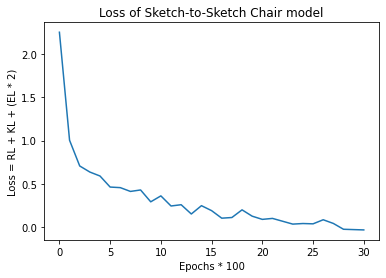

In [2]:
import matplotlib.pyplot as plt
data = [2.2534, 1.0040, 0.7070, 0.6366, 0.5908, 0.4630, 0.4564, 0.4125, 0.4295, 0.2923, 0.3610, 0.2441, 0.2588, 0.1516, 0.2477, 0.1903, 0.1031, 0.1108, 0.1995, 0.1262, 0.0893, 0.1005, 0.0676, 0.0346, 0.0413, 0.0377, 0.0849, 0.0423, -0.0251, -0.0289, -0.0326] 
plt.plot(data)
plt.title('Loss of Sketch-to-Sketch Chair model')
plt.xlabel('Epochs * 100')
plt.ylabel('Loss = RL + KL + (EL * 2)')
